In [1]:
!pip install pillow matplotlib

# Homework2 Face Generation
In HW2, You'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using CelebA datasets in this homework, we provide the code for you to download the dataset and preprocess data

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import warnings 
warnings.filterwarnings("ignore")

import os
import helper
import matplotlib.pyplot as plt
from glob import glob

In [3]:
data_dir = './data'
# helper.download_extract(data_dir)

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

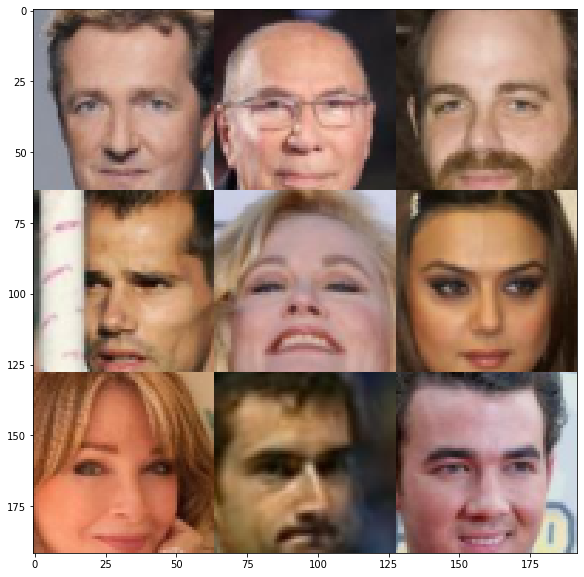

254.0 0.0
(9, 64, 64, 3)


In [4]:
show_n_images = 3*3
image_size = 64
plt.figure(figsize=(10, 10))
images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], image_size, image_size, 'RGB')
plt.imshow(helper.images_square_grid(images))
plt.show()

print(images.max(), images.min())
print(images.shape)

# After train your generative model, please generate 9 images and save it by function "output_fig" below

In [5]:
# load whole data
print("loading whole data...")
X_train = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:], image_size, image_size, 'RGB')
IMG_NUM = X_train.shape[0]
print(X_train.shape)

loading whole data...
(202599, 64, 64, 3)


In [6]:
# dcgan
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np


class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.learning_rate = 1e-4
        
        self.img_size = 64
        self.gf = 64 # filter size of generator's last layer
        self.df = 64 # filter size of discriminator's last layer

        optimizer = Adam(self.learning_rate, beta_1=0.5, decay=0.00005)

        # Build the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        self.discriminator.trainable = False
        
        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # The discriminator takes generated images as input and determines validity(0 or 1)
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        # For the combined model we will only train the generator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.discriminator.trainable = True
        
        
    def build_generator(self):
        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((8, 8, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D()) 
        model.add(Conv2D(32, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)
    

    def build_discriminator(self):
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    
    def train(self, data, epochs, batch_size=128, save_interval=50):
        
        # Load the dataset
        X_train = data
        
        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1
        print(f"epochs: {epochs}, batch size: {batch_size}")
        print(f"X_train: {X_train.shape}, {X_train.max()}, {X_train.min()}")

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            for batch_index in range(int(X_train.shape[0]/batch_size)):
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random half of images
                # idx = np.random.randint(0, X_train.shape[0], batch_size)
                # imgs = X_train[idx]
                imgs = X_train[batch_index*batch_size:(batch_index+1)*batch_size]

                # Sample noise and generate a batch of new images
                # noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                noise = np.random.uniform(-1, 1, size=(batch_size, self.latent_dim))
                gen_imgs = self.generator.predict(noise)

                # Train the discriminator (real classified as ones and generated as zeros, 0.9 for label smoothing)
                self.discriminator.trainable = True
                d_loss_real = self.discriminator.train_on_batch(imgs, valid*0.9) 
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # ---------------------
                #  Train Generator
                # ---------------------

                # Train the generator (wants discriminator to mistake images as real)
                self.discriminator.trainable = False
                g_loss = self.combined.train_on_batch(noise, valid)

                # Plot the progress
                print("epoch: %d batch: %d [D loss: %f] [G loss: %f]" % (epoch, batch_index, d_loss[0], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                self.generator.save('dcgan/generator%04d.h5' % epoch)

                
    def save_imgs(self, epoch):
        r, c = 7, 7
        # noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        noise = np.random.uniform(-1, 1, size=(r*c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 255
        gen_imgs = (gen_imgs + 1) * 127.5
        print(gen_imgs.shape, gen_imgs.max(), gen_imgs.min())
        
        plt.figure(figsize=(10, 10))
        fig = helper.images_square_grid(gen_imgs)
        plt.imshow(fig)
        plt.savefig("dcgan/images/celeba_%04d.png" % epoch)
        plt.show()
        plt.close()


Using TensorFlow backend.


In [7]:
# wgan
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

class WGAN():
    def __init__(self):
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.0001, decay=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

#         model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
#         model.add(Reshape((7, 7, 128)))
#         model.add(UpSampling2D())
#         model.add(Conv2D(128, kernel_size=4, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Activation("relu"))
#         model.add(UpSampling2D())
#         model.add(Conv2D(64, kernel_size=4, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(Activation("relu"))
#         model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
#         model.add(Activation("tanh"))
        
        model.add(Dense(128 * 4 * 4, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((4, 4, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(512, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(256, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D()) 
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D()) 
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

#         model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.25))
#         model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
#         model.add(ZeroPadding2D(padding=((0,1),(0,1))))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.25))
#         model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.25))
#         model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
#         model.add(BatchNormalization(momentum=0.8))
#         model.add(LeakyReLU(alpha=0.2))
#         model.add(Dropout(0.25))
#         model.add(Flatten())
#         model.add(Dense(1))

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, data, epochs, batch_size=128, save_interval=50):
        
        # Load the dataset
        X_train = data
        
        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.
        print(f"epochs: {epochs}, batch size: {batch_size}")
        print(f"X_train: {X_train.shape}, {X_train.max()}, {X_train.min()}")

        # Adversarial ground truths(-1 for real, 1 for fake)
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):
            for batch_index in range(int(X_train.shape[0]/batch_size)):
                for _ in range(self.n_critic):

                    # ---------------------
                    #  Train Discriminator
                    # ---------------------

                    # Select a random batch of images
                    # idx = np.random.randint(0, X_train.shape[0], batch_size)
                    # imgs = X_train[idx]
                    imgs = X_train[batch_index*batch_size:(batch_index+1)*batch_size]

                    # Sample noise as generator input
                    noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                    # Generate a batch of new images
                    gen_imgs = self.generator.predict(noise)

                    # Train the critic
                    d_loss_real = self.critic.train_on_batch(imgs, valid)
                    d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                    d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                    # Clip critic weights
                    for l in self.critic.layers:
                        weights = l.get_weights()
                        weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                        l.set_weights(weights)


                # ---------------------
                #  Train Generator
                # ---------------------

                g_loss = self.combined.train_on_batch(noise, valid)

                # Plot the progress
                print ("epoch: %d batch: %d [D loss: %f] [G loss: %f]" % (epoch, batch_index, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
#             if epoch % save_interval == 0:
#                 self.save_images(epoch)
            if epoch % save_interval == 0:
                self.generator.save('wgan/generator%04d.h5' % epoch)

    def save_images(self, epoch):
        r, c = 7, 7
        noise = np.random.normal(0, 1, (r*c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        print(gen_imgs.shape, gen_imgs.max(), gen_imgs.min())

        # Rescale images 0 - 1
        gen_imgs = (gen_imgs + 1) * 127.5
        print(gen_imgs.shape, gen_imgs.max(), gen_imgs.min())

        plt.figure(figsize=(10, 10))
        fig = helper.images_square_grid(gen_imgs)
        plt.imshow(fig)
        plt.savefig("wgan/images/celeba_%04d.png" % epoch)
        plt.show()
        plt.close()








_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
___

epoch: 0 batch: 4 [D loss: 0.474813] [G loss: 1.943936]
epoch: 0 batch: 5 [D loss: 0.450892] [G loss: 1.984766]
epoch: 0 batch: 6 [D loss: 0.467087] [G loss: 2.057092]
epoch: 0 batch: 7 [D loss: 0.482010] [G loss: 2.372366]
epoch: 0 batch: 8 [D loss: 0.410826] [G loss: 2.692822]
epoch: 0 batch: 9 [D loss: 0.475847] [G loss: 2.466406]
epoch: 0 batch: 10 [D loss: 0.542777] [G loss: 2.704839]
epoch: 0 batch: 11 [D loss: 0.429064] [G loss: 2.912056]
epoch: 0 batch: 12 [D loss: 0.448474] [G loss: 2.771860]
epoch: 0 batch: 13 [D loss: 0.532904] [G loss: 2.539364]
epoch: 0 batch: 14 [D loss: 0.437183] [G loss: 2.575345]
epoch: 0 batch: 15 [D loss: 0.395942] [G loss: 2.582097]
epoch: 0 batch: 16 [D loss: 0.431672] [G loss: 2.469928]
epoch: 0 batch: 17 [D loss: 0.400082] [G loss: 2.350658]
epoch: 0 batch: 18 [D loss: 0.416578] [G loss: 2.345518]
epoch: 0 batch: 19 [D loss: 0.438036] [G loss: 2.245225]
epoch: 0 batch: 20 [D loss: 0.379664] [G loss: 2.399108]
epoch: 0 batch: 21 [D loss: 0.372489]

epoch: 0 batch: 148 [D loss: 0.501511] [G loss: 1.872431]
epoch: 0 batch: 149 [D loss: 0.611591] [G loss: 1.860332]
epoch: 0 batch: 150 [D loss: 0.680331] [G loss: 2.048729]
epoch: 0 batch: 151 [D loss: 0.588363] [G loss: 2.131818]
epoch: 0 batch: 152 [D loss: 0.628261] [G loss: 1.958343]
epoch: 0 batch: 153 [D loss: 0.669089] [G loss: 2.145233]
epoch: 0 batch: 154 [D loss: 0.601544] [G loss: 2.033976]
epoch: 0 batch: 155 [D loss: 0.597281] [G loss: 2.062916]
epoch: 0 batch: 156 [D loss: 0.587369] [G loss: 2.004055]
epoch: 0 batch: 157 [D loss: 0.581883] [G loss: 2.220294]
epoch: 0 batch: 158 [D loss: 0.654589] [G loss: 1.943127]
epoch: 0 batch: 159 [D loss: 0.473145] [G loss: 2.141596]
epoch: 0 batch: 160 [D loss: 0.559038] [G loss: 1.855918]
epoch: 0 batch: 161 [D loss: 0.550825] [G loss: 1.968262]
epoch: 0 batch: 162 [D loss: 0.575462] [G loss: 2.276999]
epoch: 0 batch: 163 [D loss: 0.493683] [G loss: 2.482460]
epoch: 0 batch: 164 [D loss: 0.629730] [G loss: 2.260021]
epoch: 0 batch

epoch: 0 batch: 290 [D loss: 0.746940] [G loss: 1.728085]
epoch: 0 batch: 291 [D loss: 0.589865] [G loss: 1.826627]
epoch: 0 batch: 292 [D loss: 0.673342] [G loss: 1.859790]
epoch: 0 batch: 293 [D loss: 0.631122] [G loss: 2.011880]
epoch: 0 batch: 294 [D loss: 0.574695] [G loss: 1.847400]
epoch: 0 batch: 295 [D loss: 0.669186] [G loss: 1.854317]
epoch: 0 batch: 296 [D loss: 0.588795] [G loss: 1.945648]
epoch: 0 batch: 297 [D loss: 0.641068] [G loss: 1.803584]
epoch: 0 batch: 298 [D loss: 0.629203] [G loss: 1.733850]
epoch: 0 batch: 299 [D loss: 0.639302] [G loss: 1.689205]
epoch: 0 batch: 300 [D loss: 0.577483] [G loss: 1.715492]
epoch: 0 batch: 301 [D loss: 0.602407] [G loss: 1.676871]
epoch: 0 batch: 302 [D loss: 0.562306] [G loss: 1.596006]
epoch: 0 batch: 303 [D loss: 0.593799] [G loss: 1.643787]
epoch: 0 batch: 304 [D loss: 0.632329] [G loss: 1.518456]
epoch: 0 batch: 305 [D loss: 0.675467] [G loss: 1.661050]
epoch: 0 batch: 306 [D loss: 0.660861] [G loss: 1.761374]
epoch: 0 batch

epoch: 0 batch: 432 [D loss: 0.646775] [G loss: 1.694441]
epoch: 0 batch: 433 [D loss: 0.735175] [G loss: 1.562498]
epoch: 0 batch: 434 [D loss: 0.631981] [G loss: 1.635093]
epoch: 0 batch: 435 [D loss: 0.680754] [G loss: 1.639016]
epoch: 0 batch: 436 [D loss: 0.598553] [G loss: 1.578719]
epoch: 0 batch: 437 [D loss: 0.667437] [G loss: 1.768244]
epoch: 0 batch: 438 [D loss: 0.619043] [G loss: 1.911445]
epoch: 0 batch: 439 [D loss: 0.613878] [G loss: 2.001379]
epoch: 0 batch: 440 [D loss: 0.544793] [G loss: 1.975638]
epoch: 0 batch: 441 [D loss: 0.578438] [G loss: 1.882532]
epoch: 0 batch: 442 [D loss: 0.555330] [G loss: 1.774740]
epoch: 0 batch: 443 [D loss: 0.614849] [G loss: 2.020354]
epoch: 0 batch: 444 [D loss: 0.535893] [G loss: 1.771958]
epoch: 0 batch: 445 [D loss: 0.568009] [G loss: 1.614421]
epoch: 0 batch: 446 [D loss: 0.576356] [G loss: 1.681182]
epoch: 0 batch: 447 [D loss: 0.574448] [G loss: 1.707283]
epoch: 0 batch: 448 [D loss: 0.643323] [G loss: 1.670594]
epoch: 0 batch

epoch: 0 batch: 574 [D loss: 0.672258] [G loss: 1.676279]
epoch: 0 batch: 575 [D loss: 0.670167] [G loss: 1.676895]
epoch: 0 batch: 576 [D loss: 0.617149] [G loss: 1.764138]
epoch: 0 batch: 577 [D loss: 0.652518] [G loss: 1.763027]
epoch: 0 batch: 578 [D loss: 0.602932] [G loss: 1.968279]
epoch: 0 batch: 579 [D loss: 0.689028] [G loss: 1.766357]
epoch: 0 batch: 580 [D loss: 0.557369] [G loss: 1.887514]
epoch: 0 batch: 581 [D loss: 0.496286] [G loss: 2.159669]
epoch: 0 batch: 582 [D loss: 0.488932] [G loss: 2.008270]
epoch: 0 batch: 583 [D loss: 0.537616] [G loss: 1.768542]
epoch: 0 batch: 584 [D loss: 0.554298] [G loss: 1.912051]
epoch: 0 batch: 585 [D loss: 0.508194] [G loss: 1.849786]
epoch: 0 batch: 586 [D loss: 0.531456] [G loss: 1.808630]
epoch: 0 batch: 587 [D loss: 0.465617] [G loss: 1.896765]
epoch: 0 batch: 588 [D loss: 0.509629] [G loss: 1.802955]
epoch: 0 batch: 589 [D loss: 0.567944] [G loss: 1.472373]
epoch: 0 batch: 590 [D loss: 0.567313] [G loss: 1.674762]
epoch: 0 batch

epoch: 0 batch: 716 [D loss: 0.542247] [G loss: 1.561968]
epoch: 0 batch: 717 [D loss: 0.651920] [G loss: 1.586344]
epoch: 0 batch: 718 [D loss: 0.692679] [G loss: 1.632215]
epoch: 0 batch: 719 [D loss: 0.660217] [G loss: 1.373165]
epoch: 0 batch: 720 [D loss: 0.588302] [G loss: 1.666487]
epoch: 0 batch: 721 [D loss: 0.540257] [G loss: 1.790073]
epoch: 0 batch: 722 [D loss: 0.691924] [G loss: 1.756696]
epoch: 0 batch: 723 [D loss: 0.560549] [G loss: 1.720552]
epoch: 0 batch: 724 [D loss: 0.535481] [G loss: 1.771865]
epoch: 0 batch: 725 [D loss: 0.721485] [G loss: 1.724143]
epoch: 0 batch: 726 [D loss: 0.540825] [G loss: 1.782730]
epoch: 0 batch: 727 [D loss: 0.544170] [G loss: 1.520198]
epoch: 0 batch: 728 [D loss: 0.540627] [G loss: 1.718883]
epoch: 0 batch: 729 [D loss: 0.573110] [G loss: 1.806312]
epoch: 0 batch: 730 [D loss: 0.534781] [G loss: 1.673657]
epoch: 0 batch: 731 [D loss: 0.562108] [G loss: 1.578217]
epoch: 0 batch: 732 [D loss: 0.558608] [G loss: 1.687323]
epoch: 0 batch

epoch: 0 batch: 858 [D loss: 0.532617] [G loss: 1.851245]
epoch: 0 batch: 859 [D loss: 0.651396] [G loss: 1.739002]
epoch: 0 batch: 860 [D loss: 0.620150] [G loss: 1.586906]
epoch: 0 batch: 861 [D loss: 0.585321] [G loss: 1.679821]
epoch: 0 batch: 862 [D loss: 0.587840] [G loss: 1.780858]
epoch: 0 batch: 863 [D loss: 0.700970] [G loss: 1.725124]
epoch: 0 batch: 864 [D loss: 0.590553] [G loss: 1.636459]
epoch: 0 batch: 865 [D loss: 0.579129] [G loss: 1.797307]
epoch: 0 batch: 866 [D loss: 0.631142] [G loss: 1.735755]
epoch: 0 batch: 867 [D loss: 0.625820] [G loss: 1.651845]
epoch: 0 batch: 868 [D loss: 0.525248] [G loss: 1.625994]
epoch: 0 batch: 869 [D loss: 0.588848] [G loss: 1.744180]
epoch: 0 batch: 870 [D loss: 0.591455] [G loss: 1.691005]
epoch: 0 batch: 871 [D loss: 0.581279] [G loss: 1.800431]
epoch: 0 batch: 872 [D loss: 0.589992] [G loss: 1.688637]
epoch: 0 batch: 873 [D loss: 0.629618] [G loss: 1.548866]
epoch: 0 batch: 874 [D loss: 0.570573] [G loss: 1.753605]
epoch: 0 batch

epoch: 0 batch: 1000 [D loss: 0.621229] [G loss: 1.591892]
epoch: 0 batch: 1001 [D loss: 0.626998] [G loss: 1.646982]
epoch: 0 batch: 1002 [D loss: 0.650967] [G loss: 1.617519]
epoch: 0 batch: 1003 [D loss: 0.615791] [G loss: 1.684501]
epoch: 0 batch: 1004 [D loss: 0.614180] [G loss: 1.768387]
epoch: 0 batch: 1005 [D loss: 0.677951] [G loss: 1.614009]
epoch: 0 batch: 1006 [D loss: 0.634316] [G loss: 1.770314]
epoch: 0 batch: 1007 [D loss: 0.610081] [G loss: 1.819497]
epoch: 0 batch: 1008 [D loss: 0.665957] [G loss: 1.821827]
epoch: 0 batch: 1009 [D loss: 0.606974] [G loss: 1.739232]
epoch: 0 batch: 1010 [D loss: 0.652392] [G loss: 1.452448]
epoch: 0 batch: 1011 [D loss: 0.628172] [G loss: 1.601197]
epoch: 0 batch: 1012 [D loss: 0.632935] [G loss: 1.755487]
epoch: 0 batch: 1013 [D loss: 0.580155] [G loss: 1.673934]
epoch: 0 batch: 1014 [D loss: 0.648327] [G loss: 1.431030]
epoch: 0 batch: 1015 [D loss: 0.606723] [G loss: 1.447831]
epoch: 0 batch: 1016 [D loss: 0.676650] [G loss: 1.49831

epoch: 0 batch: 1139 [D loss: 0.496309] [G loss: 1.678199]
epoch: 0 batch: 1140 [D loss: 0.543291] [G loss: 1.640674]
epoch: 0 batch: 1141 [D loss: 0.568067] [G loss: 1.726033]
epoch: 0 batch: 1142 [D loss: 0.647099] [G loss: 1.557403]
epoch: 0 batch: 1143 [D loss: 0.608527] [G loss: 1.361137]
epoch: 0 batch: 1144 [D loss: 0.627391] [G loss: 1.446869]
epoch: 0 batch: 1145 [D loss: 0.703304] [G loss: 1.530661]
epoch: 0 batch: 1146 [D loss: 0.570894] [G loss: 1.527330]
epoch: 0 batch: 1147 [D loss: 0.702230] [G loss: 1.431804]
epoch: 0 batch: 1148 [D loss: 0.687858] [G loss: 1.438230]
epoch: 0 batch: 1149 [D loss: 0.631988] [G loss: 1.586110]
epoch: 0 batch: 1150 [D loss: 0.632497] [G loss: 1.444357]
epoch: 0 batch: 1151 [D loss: 0.647396] [G loss: 1.399846]
epoch: 0 batch: 1152 [D loss: 0.598433] [G loss: 1.485102]
epoch: 0 batch: 1153 [D loss: 0.613729] [G loss: 1.476748]
epoch: 0 batch: 1154 [D loss: 0.705341] [G loss: 1.498721]
epoch: 0 batch: 1155 [D loss: 0.656144] [G loss: 1.45154

epoch: 0 batch: 1278 [D loss: 0.639040] [G loss: 1.491552]
epoch: 0 batch: 1279 [D loss: 0.588531] [G loss: 1.601216]
epoch: 0 batch: 1280 [D loss: 0.599959] [G loss: 1.633081]
epoch: 0 batch: 1281 [D loss: 0.635571] [G loss: 1.636788]
epoch: 0 batch: 1282 [D loss: 0.628031] [G loss: 1.558523]
epoch: 0 batch: 1283 [D loss: 0.601060] [G loss: 1.741006]
epoch: 0 batch: 1284 [D loss: 0.652356] [G loss: 1.494465]
epoch: 0 batch: 1285 [D loss: 0.629002] [G loss: 1.431749]
epoch: 0 batch: 1286 [D loss: 0.677448] [G loss: 1.589102]
epoch: 0 batch: 1287 [D loss: 0.624043] [G loss: 1.582853]
epoch: 0 batch: 1288 [D loss: 0.607223] [G loss: 1.519820]
epoch: 0 batch: 1289 [D loss: 0.621980] [G loss: 1.448195]
epoch: 0 batch: 1290 [D loss: 0.679662] [G loss: 1.482816]
epoch: 0 batch: 1291 [D loss: 0.630854] [G loss: 1.497399]
epoch: 0 batch: 1292 [D loss: 0.631685] [G loss: 1.518170]
epoch: 0 batch: 1293 [D loss: 0.631573] [G loss: 1.476976]
epoch: 0 batch: 1294 [D loss: 0.639758] [G loss: 1.66004

epoch: 0 batch: 1417 [D loss: 0.657112] [G loss: 1.573985]
epoch: 0 batch: 1418 [D loss: 0.626627] [G loss: 1.557357]
epoch: 0 batch: 1419 [D loss: 0.633253] [G loss: 1.420524]
epoch: 0 batch: 1420 [D loss: 0.553723] [G loss: 1.541006]
epoch: 0 batch: 1421 [D loss: 0.588984] [G loss: 1.561479]
epoch: 0 batch: 1422 [D loss: 0.580314] [G loss: 1.621777]
epoch: 0 batch: 1423 [D loss: 0.577623] [G loss: 1.539362]
epoch: 0 batch: 1424 [D loss: 0.585730] [G loss: 1.496093]
epoch: 0 batch: 1425 [D loss: 0.627719] [G loss: 1.580296]
epoch: 0 batch: 1426 [D loss: 0.617340] [G loss: 1.589202]
epoch: 0 batch: 1427 [D loss: 0.572758] [G loss: 1.504062]
epoch: 0 batch: 1428 [D loss: 0.651631] [G loss: 1.527568]
epoch: 0 batch: 1429 [D loss: 0.630874] [G loss: 1.595542]
epoch: 0 batch: 1430 [D loss: 0.608577] [G loss: 1.610140]
epoch: 0 batch: 1431 [D loss: 0.580719] [G loss: 1.655241]
epoch: 0 batch: 1432 [D loss: 0.667073] [G loss: 1.726632]
epoch: 0 batch: 1433 [D loss: 0.617112] [G loss: 1.52979

epoch: 0 batch: 1556 [D loss: 0.637244] [G loss: 1.562386]
epoch: 0 batch: 1557 [D loss: 0.631692] [G loss: 1.542295]
epoch: 0 batch: 1558 [D loss: 0.672116] [G loss: 1.409380]
epoch: 0 batch: 1559 [D loss: 0.615465] [G loss: 1.582755]
epoch: 0 batch: 1560 [D loss: 0.653167] [G loss: 1.475862]
epoch: 0 batch: 1561 [D loss: 0.608867] [G loss: 1.571045]
epoch: 0 batch: 1562 [D loss: 0.576562] [G loss: 1.589170]
epoch: 0 batch: 1563 [D loss: 0.663629] [G loss: 1.444978]
epoch: 0 batch: 1564 [D loss: 0.620833] [G loss: 1.479537]
epoch: 0 batch: 1565 [D loss: 0.569543] [G loss: 1.452756]
epoch: 0 batch: 1566 [D loss: 0.599321] [G loss: 1.423255]
epoch: 0 batch: 1567 [D loss: 0.563370] [G loss: 1.487830]
epoch: 0 batch: 1568 [D loss: 0.609112] [G loss: 1.554036]
epoch: 0 batch: 1569 [D loss: 0.592139] [G loss: 1.504348]
epoch: 0 batch: 1570 [D loss: 0.582811] [G loss: 1.661652]
epoch: 0 batch: 1571 [D loss: 0.591464] [G loss: 1.639869]
epoch: 0 batch: 1572 [D loss: 0.643330] [G loss: 1.56799

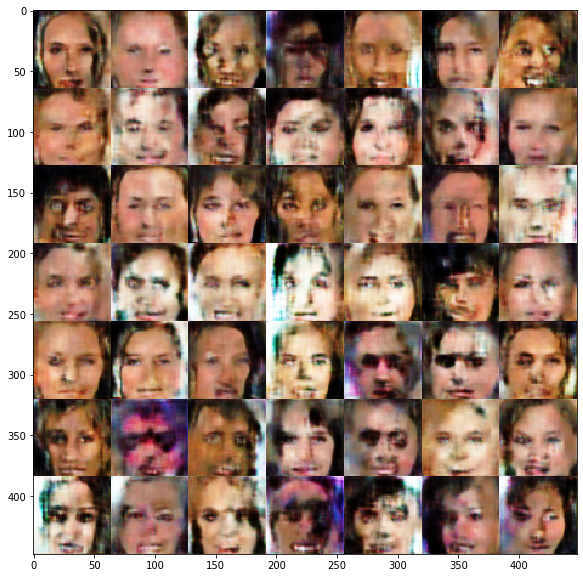

epoch: 1 batch: 0 [D loss: 0.641808] [G loss: 1.566345]
epoch: 1 batch: 1 [D loss: 0.602111] [G loss: 1.448645]
epoch: 1 batch: 2 [D loss: 0.636228] [G loss: 1.413809]
epoch: 1 batch: 3 [D loss: 0.580644] [G loss: 1.627819]
epoch: 1 batch: 4 [D loss: 0.645976] [G loss: 1.468603]
epoch: 1 batch: 5 [D loss: 0.664092] [G loss: 1.520712]
epoch: 1 batch: 6 [D loss: 0.646614] [G loss: 1.539690]
epoch: 1 batch: 7 [D loss: 0.711324] [G loss: 1.452272]
epoch: 1 batch: 8 [D loss: 0.606304] [G loss: 1.446220]
epoch: 1 batch: 9 [D loss: 0.633448] [G loss: 1.544231]
epoch: 1 batch: 10 [D loss: 0.627585] [G loss: 1.557911]
epoch: 1 batch: 11 [D loss: 0.641850] [G loss: 1.557301]
epoch: 1 batch: 12 [D loss: 0.654597] [G loss: 1.385196]
epoch: 1 batch: 13 [D loss: 0.634537] [G loss: 1.532499]
epoch: 1 batch: 14 [D loss: 0.637775] [G loss: 1.416825]
epoch: 1 batch: 15 [D loss: 0.631406] [G loss: 1.529318]
epoch: 1 batch: 16 [D loss: 0.690214] [G loss: 1.390194]
epoch: 1 batch: 17 [D loss: 0.650480] [G 

epoch: 1 batch: 144 [D loss: 0.659318] [G loss: 1.441040]
epoch: 1 batch: 145 [D loss: 0.680136] [G loss: 1.384808]
epoch: 1 batch: 146 [D loss: 0.548651] [G loss: 1.367665]
epoch: 1 batch: 147 [D loss: 0.656255] [G loss: 1.486418]
epoch: 1 batch: 148 [D loss: 0.565923] [G loss: 1.526867]
epoch: 1 batch: 149 [D loss: 0.678679] [G loss: 1.376782]
epoch: 1 batch: 150 [D loss: 0.626217] [G loss: 1.470437]
epoch: 1 batch: 151 [D loss: 0.590129] [G loss: 1.369242]
epoch: 1 batch: 152 [D loss: 0.722223] [G loss: 1.355718]
epoch: 1 batch: 153 [D loss: 0.610996] [G loss: 1.383478]
epoch: 1 batch: 154 [D loss: 0.646703] [G loss: 1.478994]
epoch: 1 batch: 155 [D loss: 0.663137] [G loss: 1.526158]
epoch: 1 batch: 156 [D loss: 0.664005] [G loss: 1.418342]
epoch: 1 batch: 157 [D loss: 0.630855] [G loss: 1.357680]
epoch: 1 batch: 158 [D loss: 0.604466] [G loss: 1.436651]
epoch: 1 batch: 159 [D loss: 0.588230] [G loss: 1.373121]
epoch: 1 batch: 160 [D loss: 0.673398] [G loss: 1.390553]
epoch: 1 batch

epoch: 1 batch: 286 [D loss: 0.636260] [G loss: 1.435979]
epoch: 1 batch: 287 [D loss: 0.693077] [G loss: 1.357382]
epoch: 1 batch: 288 [D loss: 0.681376] [G loss: 1.484208]
epoch: 1 batch: 289 [D loss: 0.593109] [G loss: 1.314357]
epoch: 1 batch: 290 [D loss: 0.671946] [G loss: 1.250408]
epoch: 1 batch: 291 [D loss: 0.637740] [G loss: 1.413134]
epoch: 1 batch: 292 [D loss: 0.696737] [G loss: 1.298435]
epoch: 1 batch: 293 [D loss: 0.682757] [G loss: 1.261945]
epoch: 1 batch: 294 [D loss: 0.713177] [G loss: 1.346490]
epoch: 1 batch: 295 [D loss: 0.673821] [G loss: 1.319625]
epoch: 1 batch: 296 [D loss: 0.719157] [G loss: 1.297083]
epoch: 1 batch: 297 [D loss: 0.635790] [G loss: 1.468787]
epoch: 1 batch: 298 [D loss: 0.714234] [G loss: 1.271417]
epoch: 1 batch: 299 [D loss: 0.590549] [G loss: 1.514022]
epoch: 1 batch: 300 [D loss: 0.693395] [G loss: 1.353444]
epoch: 1 batch: 301 [D loss: 0.678321] [G loss: 1.540724]
epoch: 1 batch: 302 [D loss: 0.617800] [G loss: 1.306562]
epoch: 1 batch

epoch: 1 batch: 428 [D loss: 0.579408] [G loss: 1.405196]
epoch: 1 batch: 429 [D loss: 0.612856] [G loss: 1.345038]
epoch: 1 batch: 430 [D loss: 0.701845] [G loss: 1.297980]
epoch: 1 batch: 431 [D loss: 0.667950] [G loss: 1.214307]
epoch: 1 batch: 432 [D loss: 0.667053] [G loss: 1.257835]
epoch: 1 batch: 433 [D loss: 0.628803] [G loss: 1.415591]
epoch: 1 batch: 434 [D loss: 0.631494] [G loss: 1.262480]
epoch: 1 batch: 435 [D loss: 0.690943] [G loss: 1.277941]
epoch: 1 batch: 436 [D loss: 0.741036] [G loss: 1.301507]
epoch: 1 batch: 437 [D loss: 0.652133] [G loss: 1.377452]
epoch: 1 batch: 438 [D loss: 0.660477] [G loss: 1.270144]
epoch: 1 batch: 439 [D loss: 0.613851] [G loss: 1.387392]
epoch: 1 batch: 440 [D loss: 0.681525] [G loss: 1.466386]
epoch: 1 batch: 441 [D loss: 0.712319] [G loss: 1.395057]
epoch: 1 batch: 442 [D loss: 0.689429] [G loss: 1.322585]
epoch: 1 batch: 443 [D loss: 0.619053] [G loss: 1.412935]
epoch: 1 batch: 444 [D loss: 0.674170] [G loss: 1.442249]
epoch: 1 batch

epoch: 1 batch: 570 [D loss: 0.638275] [G loss: 1.331713]
epoch: 1 batch: 571 [D loss: 0.663945] [G loss: 1.293794]
epoch: 1 batch: 572 [D loss: 0.668035] [G loss: 1.185004]
epoch: 1 batch: 573 [D loss: 0.620003] [G loss: 1.385026]
epoch: 1 batch: 574 [D loss: 0.650257] [G loss: 1.301449]
epoch: 1 batch: 575 [D loss: 0.681511] [G loss: 1.252855]
epoch: 1 batch: 576 [D loss: 0.652865] [G loss: 1.190406]
epoch: 1 batch: 577 [D loss: 0.644282] [G loss: 1.286790]
epoch: 1 batch: 578 [D loss: 0.663040] [G loss: 1.351597]
epoch: 1 batch: 579 [D loss: 0.734205] [G loss: 1.390563]
epoch: 1 batch: 580 [D loss: 0.729910] [G loss: 1.308439]
epoch: 1 batch: 581 [D loss: 0.667123] [G loss: 1.319263]
epoch: 1 batch: 582 [D loss: 0.624803] [G loss: 1.439984]
epoch: 1 batch: 583 [D loss: 0.643374] [G loss: 1.291931]
epoch: 1 batch: 584 [D loss: 0.697828] [G loss: 1.342498]
epoch: 1 batch: 585 [D loss: 0.703081] [G loss: 1.275859]
epoch: 1 batch: 586 [D loss: 0.697198] [G loss: 1.474452]
epoch: 1 batch

epoch: 1 batch: 712 [D loss: 0.675440] [G loss: 1.327269]
epoch: 1 batch: 713 [D loss: 0.665704] [G loss: 1.318538]
epoch: 1 batch: 714 [D loss: 0.659024] [G loss: 1.348427]
epoch: 1 batch: 715 [D loss: 0.669804] [G loss: 1.356243]
epoch: 1 batch: 716 [D loss: 0.682945] [G loss: 1.292497]
epoch: 1 batch: 717 [D loss: 0.681540] [G loss: 1.312030]
epoch: 1 batch: 718 [D loss: 0.625810] [G loss: 1.281346]
epoch: 1 batch: 719 [D loss: 0.688815] [G loss: 1.206304]
epoch: 1 batch: 720 [D loss: 0.647470] [G loss: 1.320453]
epoch: 1 batch: 721 [D loss: 0.689008] [G loss: 1.317415]
epoch: 1 batch: 722 [D loss: 0.644789] [G loss: 1.184738]
epoch: 1 batch: 723 [D loss: 0.658204] [G loss: 1.345663]
epoch: 1 batch: 724 [D loss: 0.655630] [G loss: 1.380379]
epoch: 1 batch: 725 [D loss: 0.665440] [G loss: 1.234113]
epoch: 1 batch: 726 [D loss: 0.649105] [G loss: 1.272228]
epoch: 1 batch: 727 [D loss: 0.678418] [G loss: 1.274852]
epoch: 1 batch: 728 [D loss: 0.635549] [G loss: 1.230004]
epoch: 1 batch

epoch: 1 batch: 854 [D loss: 0.668427] [G loss: 1.209776]
epoch: 1 batch: 855 [D loss: 0.712334] [G loss: 1.200969]
epoch: 1 batch: 856 [D loss: 0.693772] [G loss: 1.341430]
epoch: 1 batch: 857 [D loss: 0.682454] [G loss: 1.230724]
epoch: 1 batch: 858 [D loss: 0.638947] [G loss: 1.358541]
epoch: 1 batch: 859 [D loss: 0.682821] [G loss: 1.409811]
epoch: 1 batch: 860 [D loss: 0.686705] [G loss: 1.247273]
epoch: 1 batch: 861 [D loss: 0.693384] [G loss: 1.273568]
epoch: 1 batch: 862 [D loss: 0.667976] [G loss: 1.322657]
epoch: 1 batch: 863 [D loss: 0.639418] [G loss: 1.266437]
epoch: 1 batch: 864 [D loss: 0.622065] [G loss: 1.259279]
epoch: 1 batch: 865 [D loss: 0.661228] [G loss: 1.312394]
epoch: 1 batch: 866 [D loss: 0.605906] [G loss: 1.241249]
epoch: 1 batch: 867 [D loss: 0.683423] [G loss: 1.263624]
epoch: 1 batch: 868 [D loss: 0.648561] [G loss: 1.193760]
epoch: 1 batch: 869 [D loss: 0.668551] [G loss: 1.232382]
epoch: 1 batch: 870 [D loss: 0.643997] [G loss: 1.310431]
epoch: 1 batch

epoch: 1 batch: 996 [D loss: 0.663011] [G loss: 1.351207]
epoch: 1 batch: 997 [D loss: 0.664786] [G loss: 1.322539]
epoch: 1 batch: 998 [D loss: 0.650326] [G loss: 1.308385]
epoch: 1 batch: 999 [D loss: 0.710625] [G loss: 1.226966]
epoch: 1 batch: 1000 [D loss: 0.634161] [G loss: 1.255376]
epoch: 1 batch: 1001 [D loss: 0.674553] [G loss: 1.146336]
epoch: 1 batch: 1002 [D loss: 0.643569] [G loss: 1.299622]
epoch: 1 batch: 1003 [D loss: 0.699641] [G loss: 1.246832]
epoch: 1 batch: 1004 [D loss: 0.666513] [G loss: 1.143609]
epoch: 1 batch: 1005 [D loss: 0.702190] [G loss: 1.148065]
epoch: 1 batch: 1006 [D loss: 0.650815] [G loss: 1.260279]
epoch: 1 batch: 1007 [D loss: 0.717527] [G loss: 1.218692]
epoch: 1 batch: 1008 [D loss: 0.682533] [G loss: 1.219692]
epoch: 1 batch: 1009 [D loss: 0.604458] [G loss: 1.213698]
epoch: 1 batch: 1010 [D loss: 0.685358] [G loss: 1.222913]
epoch: 1 batch: 1011 [D loss: 0.686401] [G loss: 1.200791]
epoch: 1 batch: 1012 [D loss: 0.612840] [G loss: 1.213390]
e

epoch: 1 batch: 1135 [D loss: 0.632729] [G loss: 1.180796]
epoch: 1 batch: 1136 [D loss: 0.654743] [G loss: 1.160823]
epoch: 1 batch: 1137 [D loss: 0.660162] [G loss: 1.274466]
epoch: 1 batch: 1138 [D loss: 0.675409] [G loss: 1.249359]
epoch: 1 batch: 1139 [D loss: 0.694147] [G loss: 1.147859]
epoch: 1 batch: 1140 [D loss: 0.661163] [G loss: 1.276231]
epoch: 1 batch: 1141 [D loss: 0.691186] [G loss: 1.236246]
epoch: 1 batch: 1142 [D loss: 0.706988] [G loss: 1.339391]
epoch: 1 batch: 1143 [D loss: 0.641373] [G loss: 1.273605]
epoch: 1 batch: 1144 [D loss: 0.603153] [G loss: 1.343040]
epoch: 1 batch: 1145 [D loss: 0.715441] [G loss: 1.160612]
epoch: 1 batch: 1146 [D loss: 0.649338] [G loss: 1.165122]
epoch: 1 batch: 1147 [D loss: 0.677774] [G loss: 1.313179]
epoch: 1 batch: 1148 [D loss: 0.719243] [G loss: 1.214499]
epoch: 1 batch: 1149 [D loss: 0.628363] [G loss: 1.337874]
epoch: 1 batch: 1150 [D loss: 0.663680] [G loss: 1.307327]
epoch: 1 batch: 1151 [D loss: 0.737554] [G loss: 1.25587

epoch: 1 batch: 1274 [D loss: 0.641457] [G loss: 1.268885]
epoch: 1 batch: 1275 [D loss: 0.662865] [G loss: 1.312791]
epoch: 1 batch: 1276 [D loss: 0.674879] [G loss: 1.235851]
epoch: 1 batch: 1277 [D loss: 0.638044] [G loss: 1.192278]
epoch: 1 batch: 1278 [D loss: 0.643813] [G loss: 1.266567]
epoch: 1 batch: 1279 [D loss: 0.638158] [G loss: 1.401424]
epoch: 1 batch: 1280 [D loss: 0.639090] [G loss: 1.313710]
epoch: 1 batch: 1281 [D loss: 0.663048] [G loss: 1.173921]
epoch: 1 batch: 1282 [D loss: 0.647759] [G loss: 1.134676]
epoch: 1 batch: 1283 [D loss: 0.693161] [G loss: 1.287614]
epoch: 1 batch: 1284 [D loss: 0.683437] [G loss: 1.313727]
epoch: 1 batch: 1285 [D loss: 0.676633] [G loss: 1.339672]
epoch: 1 batch: 1286 [D loss: 0.662470] [G loss: 1.245052]
epoch: 1 batch: 1287 [D loss: 0.655736] [G loss: 1.409410]
epoch: 1 batch: 1288 [D loss: 0.700056] [G loss: 1.200196]
epoch: 1 batch: 1289 [D loss: 0.664418] [G loss: 1.189004]
epoch: 1 batch: 1290 [D loss: 0.664931] [G loss: 1.26805

epoch: 1 batch: 1413 [D loss: 0.647418] [G loss: 1.267301]
epoch: 1 batch: 1414 [D loss: 0.640266] [G loss: 1.235113]
epoch: 1 batch: 1415 [D loss: 0.648407] [G loss: 1.231695]
epoch: 1 batch: 1416 [D loss: 0.669407] [G loss: 1.219567]
epoch: 1 batch: 1417 [D loss: 0.652364] [G loss: 1.279886]
epoch: 1 batch: 1418 [D loss: 0.658732] [G loss: 1.248348]
epoch: 1 batch: 1419 [D loss: 0.666020] [G loss: 1.291212]
epoch: 1 batch: 1420 [D loss: 0.672899] [G loss: 1.374074]
epoch: 1 batch: 1421 [D loss: 0.644528] [G loss: 1.266140]
epoch: 1 batch: 1422 [D loss: 0.692122] [G loss: 1.161502]
epoch: 1 batch: 1423 [D loss: 0.665696] [G loss: 1.166790]
epoch: 1 batch: 1424 [D loss: 0.708760] [G loss: 1.236415]
epoch: 1 batch: 1425 [D loss: 0.651330] [G loss: 1.296450]
epoch: 1 batch: 1426 [D loss: 0.672963] [G loss: 1.152321]
epoch: 1 batch: 1427 [D loss: 0.667268] [G loss: 1.179581]
epoch: 1 batch: 1428 [D loss: 0.617993] [G loss: 1.231158]
epoch: 1 batch: 1429 [D loss: 0.701270] [G loss: 1.18176

epoch: 1 batch: 1552 [D loss: 0.653428] [G loss: 1.190279]
epoch: 1 batch: 1553 [D loss: 0.697378] [G loss: 1.213427]
epoch: 1 batch: 1554 [D loss: 0.702088] [G loss: 1.183614]
epoch: 1 batch: 1555 [D loss: 0.680450] [G loss: 1.262573]
epoch: 1 batch: 1556 [D loss: 0.649736] [G loss: 1.283161]
epoch: 1 batch: 1557 [D loss: 0.672914] [G loss: 1.254465]
epoch: 1 batch: 1558 [D loss: 0.686272] [G loss: 1.183807]
epoch: 1 batch: 1559 [D loss: 0.690499] [G loss: 1.247358]
epoch: 1 batch: 1560 [D loss: 0.679548] [G loss: 1.276762]
epoch: 1 batch: 1561 [D loss: 0.671022] [G loss: 1.231298]
epoch: 1 batch: 1562 [D loss: 0.634253] [G loss: 1.268028]
epoch: 1 batch: 1563 [D loss: 0.619052] [G loss: 1.268639]
epoch: 1 batch: 1564 [D loss: 0.671300] [G loss: 1.204947]
epoch: 1 batch: 1565 [D loss: 0.668947] [G loss: 1.131050]
epoch: 1 batch: 1566 [D loss: 0.653351] [G loss: 1.182627]
epoch: 1 batch: 1567 [D loss: 0.661999] [G loss: 1.151566]
epoch: 1 batch: 1568 [D loss: 0.649452] [G loss: 1.13920

epoch: 2 batch: 113 [D loss: 0.686391] [G loss: 1.128251]
epoch: 2 batch: 114 [D loss: 0.669017] [G loss: 1.242298]
epoch: 2 batch: 115 [D loss: 0.651958] [G loss: 1.281475]
epoch: 2 batch: 116 [D loss: 0.677959] [G loss: 1.161019]
epoch: 2 batch: 117 [D loss: 0.637386] [G loss: 1.223609]
epoch: 2 batch: 118 [D loss: 0.669852] [G loss: 1.162212]
epoch: 2 batch: 119 [D loss: 0.625821] [G loss: 1.225137]
epoch: 2 batch: 120 [D loss: 0.655956] [G loss: 1.121784]
epoch: 2 batch: 121 [D loss: 0.685668] [G loss: 1.232114]
epoch: 2 batch: 122 [D loss: 0.681765] [G loss: 1.100321]
epoch: 2 batch: 123 [D loss: 0.715550] [G loss: 1.127166]
epoch: 2 batch: 124 [D loss: 0.697493] [G loss: 1.120284]
epoch: 2 batch: 125 [D loss: 0.653380] [G loss: 1.177705]
epoch: 2 batch: 126 [D loss: 0.639636] [G loss: 1.253392]
epoch: 2 batch: 127 [D loss: 0.708778] [G loss: 1.132169]
epoch: 2 batch: 128 [D loss: 0.645532] [G loss: 1.185000]
epoch: 2 batch: 129 [D loss: 0.643768] [G loss: 1.311872]
epoch: 2 batch

epoch: 2 batch: 255 [D loss: 0.713168] [G loss: 1.155357]
epoch: 2 batch: 256 [D loss: 0.681716] [G loss: 1.183559]
epoch: 2 batch: 257 [D loss: 0.672282] [G loss: 1.184350]
epoch: 2 batch: 258 [D loss: 0.661684] [G loss: 1.212854]
epoch: 2 batch: 259 [D loss: 0.657849] [G loss: 1.198760]
epoch: 2 batch: 260 [D loss: 0.641416] [G loss: 1.302939]
epoch: 2 batch: 261 [D loss: 0.692340] [G loss: 1.246278]
epoch: 2 batch: 262 [D loss: 0.657719] [G loss: 1.295000]
epoch: 2 batch: 263 [D loss: 0.673506] [G loss: 1.258996]
epoch: 2 batch: 264 [D loss: 0.650496] [G loss: 1.242078]
epoch: 2 batch: 265 [D loss: 0.650709] [G loss: 1.182483]
epoch: 2 batch: 266 [D loss: 0.705101] [G loss: 1.129381]
epoch: 2 batch: 267 [D loss: 0.654132] [G loss: 1.289253]
epoch: 2 batch: 268 [D loss: 0.646385] [G loss: 1.312963]
epoch: 2 batch: 269 [D loss: 0.684729] [G loss: 1.210863]
epoch: 2 batch: 270 [D loss: 0.679717] [G loss: 1.232436]
epoch: 2 batch: 271 [D loss: 0.651469] [G loss: 1.270833]
epoch: 2 batch

epoch: 2 batch: 397 [D loss: 0.663979] [G loss: 1.086716]
epoch: 2 batch: 398 [D loss: 0.666981] [G loss: 1.192232]
epoch: 2 batch: 399 [D loss: 0.673448] [G loss: 1.164322]
epoch: 2 batch: 400 [D loss: 0.691776] [G loss: 1.196859]
epoch: 2 batch: 401 [D loss: 0.690822] [G loss: 1.189171]
epoch: 2 batch: 402 [D loss: 0.645972] [G loss: 1.226907]
epoch: 2 batch: 403 [D loss: 0.660972] [G loss: 1.179919]
epoch: 2 batch: 404 [D loss: 0.674770] [G loss: 1.066442]
epoch: 2 batch: 405 [D loss: 0.678608] [G loss: 1.144500]
epoch: 2 batch: 406 [D loss: 0.662996] [G loss: 1.066057]
epoch: 2 batch: 407 [D loss: 0.687838] [G loss: 1.175485]
epoch: 2 batch: 408 [D loss: 0.641579] [G loss: 1.180517]
epoch: 2 batch: 409 [D loss: 0.661002] [G loss: 1.307345]
epoch: 2 batch: 410 [D loss: 0.668066] [G loss: 1.264010]
epoch: 2 batch: 411 [D loss: 0.685625] [G loss: 1.148117]
epoch: 2 batch: 412 [D loss: 0.672776] [G loss: 1.102325]
epoch: 2 batch: 413 [D loss: 0.683748] [G loss: 1.258741]
epoch: 2 batch

epoch: 2 batch: 539 [D loss: 0.687655] [G loss: 1.215529]
epoch: 2 batch: 540 [D loss: 0.636857] [G loss: 1.205920]
epoch: 2 batch: 541 [D loss: 0.682035] [G loss: 1.291994]
epoch: 2 batch: 542 [D loss: 0.693515] [G loss: 1.170829]
epoch: 2 batch: 543 [D loss: 0.642352] [G loss: 1.192420]
epoch: 2 batch: 544 [D loss: 0.648937] [G loss: 1.184659]
epoch: 2 batch: 545 [D loss: 0.652405] [G loss: 1.161208]
epoch: 2 batch: 546 [D loss: 0.689344] [G loss: 1.213325]
epoch: 2 batch: 547 [D loss: 0.661225] [G loss: 1.190421]
epoch: 2 batch: 548 [D loss: 0.661259] [G loss: 1.298317]
epoch: 2 batch: 549 [D loss: 0.669413] [G loss: 1.218809]
epoch: 2 batch: 550 [D loss: 0.664499] [G loss: 1.186371]
epoch: 2 batch: 551 [D loss: 0.679550] [G loss: 1.164966]
epoch: 2 batch: 552 [D loss: 0.681183] [G loss: 1.229175]
epoch: 2 batch: 553 [D loss: 0.670201] [G loss: 1.224756]
epoch: 2 batch: 554 [D loss: 0.608449] [G loss: 1.157119]
epoch: 2 batch: 555 [D loss: 0.729606] [G loss: 1.178288]
epoch: 2 batch

epoch: 2 batch: 681 [D loss: 0.653202] [G loss: 1.194771]
epoch: 2 batch: 682 [D loss: 0.628564] [G loss: 1.306592]
epoch: 2 batch: 683 [D loss: 0.639438] [G loss: 1.190001]
epoch: 2 batch: 684 [D loss: 0.676701] [G loss: 1.188604]
epoch: 2 batch: 685 [D loss: 0.671555] [G loss: 1.151845]
epoch: 2 batch: 686 [D loss: 0.708433] [G loss: 1.117551]
epoch: 2 batch: 687 [D loss: 0.709799] [G loss: 1.191568]
epoch: 2 batch: 688 [D loss: 0.656492] [G loss: 1.142785]
epoch: 2 batch: 689 [D loss: 0.624954] [G loss: 1.132597]
epoch: 2 batch: 690 [D loss: 0.644268] [G loss: 1.271162]
epoch: 2 batch: 691 [D loss: 0.633832] [G loss: 1.281747]
epoch: 2 batch: 692 [D loss: 0.713336] [G loss: 1.185297]
epoch: 2 batch: 693 [D loss: 0.662173] [G loss: 1.188468]
epoch: 2 batch: 694 [D loss: 0.633609] [G loss: 1.161641]
epoch: 2 batch: 695 [D loss: 0.651173] [G loss: 1.188892]
epoch: 2 batch: 696 [D loss: 0.713556] [G loss: 1.107651]
epoch: 2 batch: 697 [D loss: 0.626964] [G loss: 1.204063]
epoch: 2 batch

epoch: 2 batch: 823 [D loss: 0.658039] [G loss: 1.187611]
epoch: 2 batch: 824 [D loss: 0.650593] [G loss: 1.105082]
epoch: 2 batch: 825 [D loss: 0.643893] [G loss: 1.275040]
epoch: 2 batch: 826 [D loss: 0.683571] [G loss: 1.041595]
epoch: 2 batch: 827 [D loss: 0.688337] [G loss: 1.227275]
epoch: 2 batch: 828 [D loss: 0.654886] [G loss: 1.169876]
epoch: 2 batch: 829 [D loss: 0.698991] [G loss: 1.179357]
epoch: 2 batch: 830 [D loss: 0.654584] [G loss: 1.132316]
epoch: 2 batch: 831 [D loss: 0.635270] [G loss: 1.201144]
epoch: 2 batch: 832 [D loss: 0.653171] [G loss: 1.291791]
epoch: 2 batch: 833 [D loss: 0.671350] [G loss: 1.184220]
epoch: 2 batch: 834 [D loss: 0.644774] [G loss: 1.195282]
epoch: 2 batch: 835 [D loss: 0.636582] [G loss: 1.191138]
epoch: 2 batch: 836 [D loss: 0.672476] [G loss: 1.217332]
epoch: 2 batch: 837 [D loss: 0.676885] [G loss: 1.158747]
epoch: 2 batch: 838 [D loss: 0.673473] [G loss: 1.278026]
epoch: 2 batch: 839 [D loss: 0.676446] [G loss: 1.145684]
epoch: 2 batch

epoch: 2 batch: 965 [D loss: 0.627922] [G loss: 1.141652]
epoch: 2 batch: 966 [D loss: 0.660392] [G loss: 1.164740]
epoch: 2 batch: 967 [D loss: 0.657233] [G loss: 1.198297]
epoch: 2 batch: 968 [D loss: 0.652745] [G loss: 1.249958]
epoch: 2 batch: 969 [D loss: 0.627785] [G loss: 1.199272]
epoch: 2 batch: 970 [D loss: 0.681229] [G loss: 1.209138]
epoch: 2 batch: 971 [D loss: 0.642119] [G loss: 1.245945]
epoch: 2 batch: 972 [D loss: 0.681667] [G loss: 1.167908]
epoch: 2 batch: 973 [D loss: 0.637669] [G loss: 1.190631]
epoch: 2 batch: 974 [D loss: 0.654780] [G loss: 1.358127]
epoch: 2 batch: 975 [D loss: 0.623775] [G loss: 1.336363]
epoch: 2 batch: 976 [D loss: 0.666197] [G loss: 1.221045]
epoch: 2 batch: 977 [D loss: 0.620812] [G loss: 1.297340]
epoch: 2 batch: 978 [D loss: 0.654014] [G loss: 1.297408]
epoch: 2 batch: 979 [D loss: 0.635310] [G loss: 1.264013]
epoch: 2 batch: 980 [D loss: 0.641623] [G loss: 1.175102]
epoch: 2 batch: 981 [D loss: 0.654338] [G loss: 1.194640]
epoch: 2 batch

epoch: 2 batch: 1105 [D loss: 0.657115] [G loss: 1.097108]
epoch: 2 batch: 1106 [D loss: 0.655614] [G loss: 1.134774]
epoch: 2 batch: 1107 [D loss: 0.620559] [G loss: 1.223392]
epoch: 2 batch: 1108 [D loss: 0.691265] [G loss: 1.145470]
epoch: 2 batch: 1109 [D loss: 0.671557] [G loss: 1.119512]
epoch: 2 batch: 1110 [D loss: 0.700006] [G loss: 1.100015]
epoch: 2 batch: 1111 [D loss: 0.584785] [G loss: 1.176541]
epoch: 2 batch: 1112 [D loss: 0.629564] [G loss: 1.192143]
epoch: 2 batch: 1113 [D loss: 0.635758] [G loss: 1.202356]
epoch: 2 batch: 1114 [D loss: 0.662277] [G loss: 1.108104]
epoch: 2 batch: 1115 [D loss: 0.641369] [G loss: 1.267342]
epoch: 2 batch: 1116 [D loss: 0.627357] [G loss: 1.227279]
epoch: 2 batch: 1117 [D loss: 0.673250] [G loss: 1.193039]
epoch: 2 batch: 1118 [D loss: 0.635703] [G loss: 1.163848]
epoch: 2 batch: 1119 [D loss: 0.599186] [G loss: 1.233724]
epoch: 2 batch: 1120 [D loss: 0.638632] [G loss: 1.234432]
epoch: 2 batch: 1121 [D loss: 0.668122] [G loss: 1.17613

epoch: 2 batch: 1244 [D loss: 0.686674] [G loss: 1.096656]
epoch: 2 batch: 1245 [D loss: 0.678090] [G loss: 1.169984]
epoch: 2 batch: 1246 [D loss: 0.673608] [G loss: 1.121019]
epoch: 2 batch: 1247 [D loss: 0.686162] [G loss: 1.121819]
epoch: 2 batch: 1248 [D loss: 0.675047] [G loss: 1.211811]
epoch: 2 batch: 1249 [D loss: 0.697050] [G loss: 1.145170]
epoch: 2 batch: 1250 [D loss: 0.669284] [G loss: 1.165191]
epoch: 2 batch: 1251 [D loss: 0.652944] [G loss: 1.210353]
epoch: 2 batch: 1252 [D loss: 0.670741] [G loss: 1.097182]
epoch: 2 batch: 1253 [D loss: 0.650152] [G loss: 1.135263]
epoch: 2 batch: 1254 [D loss: 0.651173] [G loss: 1.167184]
epoch: 2 batch: 1255 [D loss: 0.637198] [G loss: 1.222186]
epoch: 2 batch: 1256 [D loss: 0.678293] [G loss: 1.144136]
epoch: 2 batch: 1257 [D loss: 0.662760] [G loss: 1.153961]
epoch: 2 batch: 1258 [D loss: 0.673894] [G loss: 1.155465]
epoch: 2 batch: 1259 [D loss: 0.686061] [G loss: 1.106716]
epoch: 2 batch: 1260 [D loss: 0.660471] [G loss: 1.24207

epoch: 2 batch: 1383 [D loss: 0.658906] [G loss: 1.204335]
epoch: 2 batch: 1384 [D loss: 0.688693] [G loss: 1.214592]
epoch: 2 batch: 1385 [D loss: 0.666412] [G loss: 1.181808]
epoch: 2 batch: 1386 [D loss: 0.679798] [G loss: 1.173948]
epoch: 2 batch: 1387 [D loss: 0.629471] [G loss: 1.214547]
epoch: 2 batch: 1388 [D loss: 0.631141] [G loss: 1.176603]
epoch: 2 batch: 1389 [D loss: 0.661861] [G loss: 1.254179]
epoch: 2 batch: 1390 [D loss: 0.683640] [G loss: 1.208027]
epoch: 2 batch: 1391 [D loss: 0.642776] [G loss: 1.305244]
epoch: 2 batch: 1392 [D loss: 0.646419] [G loss: 1.193926]
epoch: 2 batch: 1393 [D loss: 0.677325] [G loss: 1.186558]
epoch: 2 batch: 1394 [D loss: 0.612349] [G loss: 1.201152]
epoch: 2 batch: 1395 [D loss: 0.659406] [G loss: 1.281273]
epoch: 2 batch: 1396 [D loss: 0.621823] [G loss: 1.207909]
epoch: 2 batch: 1397 [D loss: 0.670649] [G loss: 1.203341]
epoch: 2 batch: 1398 [D loss: 0.646545] [G loss: 1.362827]
epoch: 2 batch: 1399 [D loss: 0.657847] [G loss: 1.13876

epoch: 2 batch: 1522 [D loss: 0.664298] [G loss: 1.146894]
epoch: 2 batch: 1523 [D loss: 0.604160] [G loss: 1.258798]
epoch: 2 batch: 1524 [D loss: 0.650139] [G loss: 1.120306]
epoch: 2 batch: 1525 [D loss: 0.645273] [G loss: 1.167645]
epoch: 2 batch: 1526 [D loss: 0.692519] [G loss: 1.134904]
epoch: 2 batch: 1527 [D loss: 0.688453] [G loss: 1.195994]
epoch: 2 batch: 1528 [D loss: 0.653062] [G loss: 1.201465]
epoch: 2 batch: 1529 [D loss: 0.605411] [G loss: 1.247301]
epoch: 2 batch: 1530 [D loss: 0.716615] [G loss: 1.146847]
epoch: 2 batch: 1531 [D loss: 0.634586] [G loss: 1.207652]
epoch: 2 batch: 1532 [D loss: 0.628560] [G loss: 1.228399]
epoch: 2 batch: 1533 [D loss: 0.697285] [G loss: 1.209823]
epoch: 2 batch: 1534 [D loss: 0.651326] [G loss: 1.262003]
epoch: 2 batch: 1535 [D loss: 0.617786] [G loss: 1.242798]
epoch: 2 batch: 1536 [D loss: 0.662614] [G loss: 1.185089]
epoch: 2 batch: 1537 [D loss: 0.656655] [G loss: 1.184318]
epoch: 2 batch: 1538 [D loss: 0.656832] [G loss: 1.16958

epoch: 3 batch: 82 [D loss: 0.649034] [G loss: 1.124341]
epoch: 3 batch: 83 [D loss: 0.640897] [G loss: 1.209298]
epoch: 3 batch: 84 [D loss: 0.667688] [G loss: 1.145228]
epoch: 3 batch: 85 [D loss: 0.635181] [G loss: 1.187687]
epoch: 3 batch: 86 [D loss: 0.670602] [G loss: 1.133803]
epoch: 3 batch: 87 [D loss: 0.669074] [G loss: 1.081553]
epoch: 3 batch: 88 [D loss: 0.625489] [G loss: 1.138127]
epoch: 3 batch: 89 [D loss: 0.644573] [G loss: 1.189944]
epoch: 3 batch: 90 [D loss: 0.652264] [G loss: 1.197485]
epoch: 3 batch: 91 [D loss: 0.624064] [G loss: 1.186596]
epoch: 3 batch: 92 [D loss: 0.641228] [G loss: 1.211540]
epoch: 3 batch: 93 [D loss: 0.620495] [G loss: 1.262527]
epoch: 3 batch: 94 [D loss: 0.659524] [G loss: 1.214262]
epoch: 3 batch: 95 [D loss: 0.652024] [G loss: 1.129577]
epoch: 3 batch: 96 [D loss: 0.658947] [G loss: 1.105577]
epoch: 3 batch: 97 [D loss: 0.689962] [G loss: 1.116344]
epoch: 3 batch: 98 [D loss: 0.689412] [G loss: 1.142798]
epoch: 3 batch: 99 [D loss: 0.6

epoch: 3 batch: 224 [D loss: 0.630598] [G loss: 1.178697]
epoch: 3 batch: 225 [D loss: 0.655958] [G loss: 1.230331]
epoch: 3 batch: 226 [D loss: 0.616948] [G loss: 1.216619]
epoch: 3 batch: 227 [D loss: 0.659564] [G loss: 1.177529]
epoch: 3 batch: 228 [D loss: 0.686825] [G loss: 1.208581]
epoch: 3 batch: 229 [D loss: 0.653396] [G loss: 1.292565]
epoch: 3 batch: 230 [D loss: 0.642702] [G loss: 1.199518]
epoch: 3 batch: 231 [D loss: 0.607026] [G loss: 1.248162]
epoch: 3 batch: 232 [D loss: 0.697795] [G loss: 1.152016]
epoch: 3 batch: 233 [D loss: 0.669770] [G loss: 1.205403]
epoch: 3 batch: 234 [D loss: 0.606575] [G loss: 1.234005]
epoch: 3 batch: 235 [D loss: 0.689107] [G loss: 1.153509]
epoch: 3 batch: 236 [D loss: 0.691146] [G loss: 1.159143]
epoch: 3 batch: 237 [D loss: 0.666226] [G loss: 1.183135]
epoch: 3 batch: 238 [D loss: 0.671959] [G loss: 1.033878]
epoch: 3 batch: 239 [D loss: 0.645237] [G loss: 1.266180]
epoch: 3 batch: 240 [D loss: 0.633164] [G loss: 1.197659]
epoch: 3 batch

epoch: 3 batch: 366 [D loss: 0.673838] [G loss: 1.102479]
epoch: 3 batch: 367 [D loss: 0.651620] [G loss: 1.246084]
epoch: 3 batch: 368 [D loss: 0.643883] [G loss: 1.099587]
epoch: 3 batch: 369 [D loss: 0.622957] [G loss: 1.145635]
epoch: 3 batch: 370 [D loss: 0.656761] [G loss: 1.156960]
epoch: 3 batch: 371 [D loss: 0.632433] [G loss: 1.160898]
epoch: 3 batch: 372 [D loss: 0.655993] [G loss: 1.126394]
epoch: 3 batch: 373 [D loss: 0.613111] [G loss: 1.109604]
epoch: 3 batch: 374 [D loss: 0.613713] [G loss: 1.147803]
epoch: 3 batch: 375 [D loss: 0.672374] [G loss: 1.115822]
epoch: 3 batch: 376 [D loss: 0.644948] [G loss: 1.221863]
epoch: 3 batch: 377 [D loss: 0.662280] [G loss: 1.229516]
epoch: 3 batch: 378 [D loss: 0.669228] [G loss: 1.184071]
epoch: 3 batch: 379 [D loss: 0.622079] [G loss: 1.157477]
epoch: 3 batch: 380 [D loss: 0.607905] [G loss: 1.205747]
epoch: 3 batch: 381 [D loss: 0.638821] [G loss: 1.187760]
epoch: 3 batch: 382 [D loss: 0.674041] [G loss: 1.055326]
epoch: 3 batch

epoch: 3 batch: 508 [D loss: 0.684916] [G loss: 1.128648]
epoch: 3 batch: 509 [D loss: 0.671903] [G loss: 1.054060]
epoch: 3 batch: 510 [D loss: 0.637305] [G loss: 1.180252]
epoch: 3 batch: 511 [D loss: 0.646538] [G loss: 1.137615]
epoch: 3 batch: 512 [D loss: 0.635029] [G loss: 1.134396]
epoch: 3 batch: 513 [D loss: 0.661700] [G loss: 1.197230]
epoch: 3 batch: 514 [D loss: 0.668991] [G loss: 1.091694]
epoch: 3 batch: 515 [D loss: 0.656901] [G loss: 1.150774]
epoch: 3 batch: 516 [D loss: 0.613386] [G loss: 1.201522]
epoch: 3 batch: 517 [D loss: 0.675233] [G loss: 1.193832]
epoch: 3 batch: 518 [D loss: 0.687201] [G loss: 1.193415]
epoch: 3 batch: 519 [D loss: 0.659714] [G loss: 1.196479]
epoch: 3 batch: 520 [D loss: 0.677456] [G loss: 1.177321]
epoch: 3 batch: 521 [D loss: 0.688503] [G loss: 1.170777]
epoch: 3 batch: 522 [D loss: 0.651081] [G loss: 1.299959]
epoch: 3 batch: 523 [D loss: 0.661570] [G loss: 1.243892]
epoch: 3 batch: 524 [D loss: 0.649031] [G loss: 1.250192]
epoch: 3 batch

epoch: 3 batch: 650 [D loss: 0.605041] [G loss: 1.156738]
epoch: 3 batch: 651 [D loss: 0.643066] [G loss: 1.163983]
epoch: 3 batch: 652 [D loss: 0.709346] [G loss: 1.163915]
epoch: 3 batch: 653 [D loss: 0.682918] [G loss: 1.134165]
epoch: 3 batch: 654 [D loss: 0.630278] [G loss: 1.210602]
epoch: 3 batch: 655 [D loss: 0.653493] [G loss: 1.269807]
epoch: 3 batch: 656 [D loss: 0.642054] [G loss: 1.269763]
epoch: 3 batch: 657 [D loss: 0.678093] [G loss: 1.208250]
epoch: 3 batch: 658 [D loss: 0.665450] [G loss: 1.168257]
epoch: 3 batch: 659 [D loss: 0.696041] [G loss: 1.142200]
epoch: 3 batch: 660 [D loss: 0.639721] [G loss: 1.186477]
epoch: 3 batch: 661 [D loss: 0.661542] [G loss: 1.233116]
epoch: 3 batch: 662 [D loss: 0.646507] [G loss: 1.141950]
epoch: 3 batch: 663 [D loss: 0.661425] [G loss: 1.197306]
epoch: 3 batch: 664 [D loss: 0.690418] [G loss: 1.161323]
epoch: 3 batch: 665 [D loss: 0.618632] [G loss: 1.145336]
epoch: 3 batch: 666 [D loss: 0.639956] [G loss: 1.139130]
epoch: 3 batch

epoch: 3 batch: 792 [D loss: 0.627327] [G loss: 1.066449]
epoch: 3 batch: 793 [D loss: 0.622623] [G loss: 1.132118]
epoch: 3 batch: 794 [D loss: 0.642004] [G loss: 1.219372]
epoch: 3 batch: 795 [D loss: 0.649865] [G loss: 1.250408]
epoch: 3 batch: 796 [D loss: 0.602754] [G loss: 1.192134]
epoch: 3 batch: 797 [D loss: 0.670930] [G loss: 1.190464]
epoch: 3 batch: 798 [D loss: 0.642801] [G loss: 1.161890]
epoch: 3 batch: 799 [D loss: 0.638345] [G loss: 1.151090]
epoch: 3 batch: 800 [D loss: 0.613218] [G loss: 1.150409]
epoch: 3 batch: 801 [D loss: 0.605152] [G loss: 1.173322]
epoch: 3 batch: 802 [D loss: 0.652202] [G loss: 1.228916]
epoch: 3 batch: 803 [D loss: 0.624891] [G loss: 1.208906]
epoch: 3 batch: 804 [D loss: 0.693773] [G loss: 1.156525]
epoch: 3 batch: 805 [D loss: 0.644477] [G loss: 1.219834]
epoch: 3 batch: 806 [D loss: 0.637693] [G loss: 1.219751]
epoch: 3 batch: 807 [D loss: 0.593490] [G loss: 1.202331]
epoch: 3 batch: 808 [D loss: 0.650687] [G loss: 1.156196]
epoch: 3 batch

epoch: 3 batch: 934 [D loss: 0.669592] [G loss: 1.139018]
epoch: 3 batch: 935 [D loss: 0.622103] [G loss: 1.197343]
epoch: 3 batch: 936 [D loss: 0.649169] [G loss: 1.243322]
epoch: 3 batch: 937 [D loss: 0.650829] [G loss: 1.202180]
epoch: 3 batch: 938 [D loss: 0.659714] [G loss: 1.250131]
epoch: 3 batch: 939 [D loss: 0.675216] [G loss: 1.135148]
epoch: 3 batch: 940 [D loss: 0.629050] [G loss: 1.198353]
epoch: 3 batch: 941 [D loss: 0.711825] [G loss: 1.017633]
epoch: 3 batch: 942 [D loss: 0.643420] [G loss: 1.168514]
epoch: 3 batch: 943 [D loss: 0.603271] [G loss: 1.173287]
epoch: 3 batch: 944 [D loss: 0.683679] [G loss: 1.155933]
epoch: 3 batch: 945 [D loss: 0.618463] [G loss: 1.169441]
epoch: 3 batch: 946 [D loss: 0.612368] [G loss: 1.173601]
epoch: 3 batch: 947 [D loss: 0.667345] [G loss: 1.204566]
epoch: 3 batch: 948 [D loss: 0.620972] [G loss: 1.235370]
epoch: 3 batch: 949 [D loss: 0.667333] [G loss: 1.111708]
epoch: 3 batch: 950 [D loss: 0.596352] [G loss: 1.185742]
epoch: 3 batch

epoch: 3 batch: 1074 [D loss: 0.628114] [G loss: 1.146480]
epoch: 3 batch: 1075 [D loss: 0.661115] [G loss: 1.171566]
epoch: 3 batch: 1076 [D loss: 0.603072] [G loss: 1.201550]
epoch: 3 batch: 1077 [D loss: 0.642540] [G loss: 1.288687]
epoch: 3 batch: 1078 [D loss: 0.611280] [G loss: 1.207933]
epoch: 3 batch: 1079 [D loss: 0.628528] [G loss: 1.134802]
epoch: 3 batch: 1080 [D loss: 0.636275] [G loss: 1.223797]
epoch: 3 batch: 1081 [D loss: 0.691850] [G loss: 1.141516]
epoch: 3 batch: 1082 [D loss: 0.642280] [G loss: 1.113402]
epoch: 3 batch: 1083 [D loss: 0.633054] [G loss: 1.185781]
epoch: 3 batch: 1084 [D loss: 0.675579] [G loss: 1.159813]
epoch: 3 batch: 1085 [D loss: 0.634519] [G loss: 1.161510]
epoch: 3 batch: 1086 [D loss: 0.635425] [G loss: 1.131020]
epoch: 3 batch: 1087 [D loss: 0.685762] [G loss: 1.083454]
epoch: 3 batch: 1088 [D loss: 0.650356] [G loss: 1.178598]
epoch: 3 batch: 1089 [D loss: 0.649383] [G loss: 1.110635]
epoch: 3 batch: 1090 [D loss: 0.670129] [G loss: 1.07980

epoch: 3 batch: 1213 [D loss: 0.625264] [G loss: 1.159867]
epoch: 3 batch: 1214 [D loss: 0.591527] [G loss: 1.156052]
epoch: 3 batch: 1215 [D loss: 0.707769] [G loss: 1.158335]
epoch: 3 batch: 1216 [D loss: 0.632012] [G loss: 1.222623]
epoch: 3 batch: 1217 [D loss: 0.639447] [G loss: 1.158671]
epoch: 3 batch: 1218 [D loss: 0.649277] [G loss: 1.238565]
epoch: 3 batch: 1219 [D loss: 0.648171] [G loss: 1.183408]
epoch: 3 batch: 1220 [D loss: 0.646027] [G loss: 1.139177]
epoch: 3 batch: 1221 [D loss: 0.644503] [G loss: 1.167798]
epoch: 3 batch: 1222 [D loss: 0.645254] [G loss: 1.174315]
epoch: 3 batch: 1223 [D loss: 0.628364] [G loss: 1.257076]
epoch: 3 batch: 1224 [D loss: 0.660934] [G loss: 1.199529]
epoch: 3 batch: 1225 [D loss: 0.622654] [G loss: 1.107861]
epoch: 3 batch: 1226 [D loss: 0.614844] [G loss: 1.204451]
epoch: 3 batch: 1227 [D loss: 0.626479] [G loss: 1.076830]
epoch: 3 batch: 1228 [D loss: 0.635322] [G loss: 1.176043]
epoch: 3 batch: 1229 [D loss: 0.620141] [G loss: 1.22206

epoch: 3 batch: 1352 [D loss: 0.657230] [G loss: 1.127752]
epoch: 3 batch: 1353 [D loss: 0.671502] [G loss: 1.129458]
epoch: 3 batch: 1354 [D loss: 0.655300] [G loss: 1.152030]
epoch: 3 batch: 1355 [D loss: 0.656877] [G loss: 1.122342]
epoch: 3 batch: 1356 [D loss: 0.642449] [G loss: 1.255267]
epoch: 3 batch: 1357 [D loss: 0.613153] [G loss: 1.189586]
epoch: 3 batch: 1358 [D loss: 0.610329] [G loss: 1.143371]
epoch: 3 batch: 1359 [D loss: 0.603005] [G loss: 1.151494]
epoch: 3 batch: 1360 [D loss: 0.646470] [G loss: 1.239867]
epoch: 3 batch: 1361 [D loss: 0.620086] [G loss: 1.210433]
epoch: 3 batch: 1362 [D loss: 0.628235] [G loss: 1.148911]
epoch: 3 batch: 1363 [D loss: 0.687140] [G loss: 1.100790]
epoch: 3 batch: 1364 [D loss: 0.654030] [G loss: 1.146637]
epoch: 3 batch: 1365 [D loss: 0.589200] [G loss: 1.168729]
epoch: 3 batch: 1366 [D loss: 0.652002] [G loss: 1.174150]
epoch: 3 batch: 1367 [D loss: 0.627804] [G loss: 1.143985]
epoch: 3 batch: 1368 [D loss: 0.629805] [G loss: 1.16512

epoch: 3 batch: 1491 [D loss: 0.620982] [G loss: 1.231836]
epoch: 3 batch: 1492 [D loss: 0.604569] [G loss: 1.223589]
epoch: 3 batch: 1493 [D loss: 0.664322] [G loss: 1.123959]
epoch: 3 batch: 1494 [D loss: 0.628330] [G loss: 1.080450]
epoch: 3 batch: 1495 [D loss: 0.616067] [G loss: 1.198638]
epoch: 3 batch: 1496 [D loss: 0.659192] [G loss: 1.110561]
epoch: 3 batch: 1497 [D loss: 0.661559] [G loss: 1.141555]
epoch: 3 batch: 1498 [D loss: 0.645585] [G loss: 1.173049]
epoch: 3 batch: 1499 [D loss: 0.643797] [G loss: 1.123001]
epoch: 3 batch: 1500 [D loss: 0.641407] [G loss: 1.182139]
epoch: 3 batch: 1501 [D loss: 0.628121] [G loss: 1.182051]
epoch: 3 batch: 1502 [D loss: 0.670033] [G loss: 1.158655]
epoch: 3 batch: 1503 [D loss: 0.626212] [G loss: 1.189562]
epoch: 3 batch: 1504 [D loss: 0.614778] [G loss: 1.180223]
epoch: 3 batch: 1505 [D loss: 0.618090] [G loss: 1.181919]
epoch: 3 batch: 1506 [D loss: 0.645575] [G loss: 1.237828]
epoch: 3 batch: 1507 [D loss: 0.652165] [G loss: 1.13745

epoch: 4 batch: 50 [D loss: 0.666010] [G loss: 1.095686]
epoch: 4 batch: 51 [D loss: 0.600271] [G loss: 1.145209]
epoch: 4 batch: 52 [D loss: 0.635686] [G loss: 1.250638]
epoch: 4 batch: 53 [D loss: 0.611029] [G loss: 1.183687]
epoch: 4 batch: 54 [D loss: 0.663782] [G loss: 1.163867]
epoch: 4 batch: 55 [D loss: 0.653756] [G loss: 1.191757]
epoch: 4 batch: 56 [D loss: 0.619753] [G loss: 1.224759]
epoch: 4 batch: 57 [D loss: 0.629913] [G loss: 1.126359]
epoch: 4 batch: 58 [D loss: 0.650425] [G loss: 1.231552]
epoch: 4 batch: 59 [D loss: 0.621798] [G loss: 1.164573]
epoch: 4 batch: 60 [D loss: 0.656578] [G loss: 1.187477]
epoch: 4 batch: 61 [D loss: 0.590702] [G loss: 1.232103]
epoch: 4 batch: 62 [D loss: 0.613173] [G loss: 1.246601]
epoch: 4 batch: 63 [D loss: 0.673794] [G loss: 1.092230]
epoch: 4 batch: 64 [D loss: 0.608301] [G loss: 1.109056]
epoch: 4 batch: 65 [D loss: 0.634945] [G loss: 1.129689]
epoch: 4 batch: 66 [D loss: 0.633079] [G loss: 1.195463]
epoch: 4 batch: 67 [D loss: 0.6

epoch: 4 batch: 193 [D loss: 0.630913] [G loss: 1.117715]
epoch: 4 batch: 194 [D loss: 0.577866] [G loss: 1.171455]
epoch: 4 batch: 195 [D loss: 0.631126] [G loss: 1.219735]
epoch: 4 batch: 196 [D loss: 0.666177] [G loss: 1.140395]
epoch: 4 batch: 197 [D loss: 0.664705] [G loss: 1.146774]
epoch: 4 batch: 198 [D loss: 0.606947] [G loss: 1.085576]
epoch: 4 batch: 199 [D loss: 0.650661] [G loss: 1.101338]
epoch: 4 batch: 200 [D loss: 0.653572] [G loss: 1.165262]
epoch: 4 batch: 201 [D loss: 0.621710] [G loss: 1.121357]
epoch: 4 batch: 202 [D loss: 0.657670] [G loss: 1.112184]
epoch: 4 batch: 203 [D loss: 0.611427] [G loss: 1.175291]
epoch: 4 batch: 204 [D loss: 0.621793] [G loss: 1.161166]
epoch: 4 batch: 205 [D loss: 0.693627] [G loss: 1.132542]
epoch: 4 batch: 206 [D loss: 0.620167] [G loss: 1.203036]
epoch: 4 batch: 207 [D loss: 0.625703] [G loss: 1.315857]
epoch: 4 batch: 208 [D loss: 0.626155] [G loss: 1.214613]
epoch: 4 batch: 209 [D loss: 0.633478] [G loss: 1.241023]
epoch: 4 batch

epoch: 4 batch: 335 [D loss: 0.624117] [G loss: 1.176361]
epoch: 4 batch: 336 [D loss: 0.650650] [G loss: 1.126807]
epoch: 4 batch: 337 [D loss: 0.646747] [G loss: 1.227591]
epoch: 4 batch: 338 [D loss: 0.634161] [G loss: 1.101084]
epoch: 4 batch: 339 [D loss: 0.627324] [G loss: 1.236726]
epoch: 4 batch: 340 [D loss: 0.630924] [G loss: 1.275921]
epoch: 4 batch: 341 [D loss: 0.639315] [G loss: 1.206444]
epoch: 4 batch: 342 [D loss: 0.666540] [G loss: 1.244132]
epoch: 4 batch: 343 [D loss: 0.638102] [G loss: 1.213417]
epoch: 4 batch: 344 [D loss: 0.667712] [G loss: 1.189656]
epoch: 4 batch: 345 [D loss: 0.599070] [G loss: 1.170131]
epoch: 4 batch: 346 [D loss: 0.609662] [G loss: 1.161025]
epoch: 4 batch: 347 [D loss: 0.674545] [G loss: 1.114626]
epoch: 4 batch: 348 [D loss: 0.648931] [G loss: 1.032549]
epoch: 4 batch: 349 [D loss: 0.603036] [G loss: 1.038055]
epoch: 4 batch: 350 [D loss: 0.679043] [G loss: 1.187869]
epoch: 4 batch: 351 [D loss: 0.611006] [G loss: 1.214324]
epoch: 4 batch

epoch: 4 batch: 477 [D loss: 0.600044] [G loss: 1.240848]
epoch: 4 batch: 478 [D loss: 0.625118] [G loss: 1.260123]
epoch: 4 batch: 479 [D loss: 0.645029] [G loss: 1.257462]
epoch: 4 batch: 480 [D loss: 0.645199] [G loss: 1.209718]
epoch: 4 batch: 481 [D loss: 0.594051] [G loss: 1.122683]
epoch: 4 batch: 482 [D loss: 0.612979] [G loss: 1.197800]
epoch: 4 batch: 483 [D loss: 0.619267] [G loss: 1.209610]
epoch: 4 batch: 484 [D loss: 0.675441] [G loss: 1.123581]
epoch: 4 batch: 485 [D loss: 0.633145] [G loss: 1.173727]
epoch: 4 batch: 486 [D loss: 0.661808] [G loss: 1.146105]
epoch: 4 batch: 487 [D loss: 0.626367] [G loss: 1.202854]
epoch: 4 batch: 488 [D loss: 0.655281] [G loss: 1.244673]
epoch: 4 batch: 489 [D loss: 0.607106] [G loss: 1.249425]
epoch: 4 batch: 490 [D loss: 0.653743] [G loss: 1.208945]
epoch: 4 batch: 491 [D loss: 0.651807] [G loss: 1.156210]
epoch: 4 batch: 492 [D loss: 0.641594] [G loss: 1.202448]
epoch: 4 batch: 493 [D loss: 0.677411] [G loss: 1.190938]
epoch: 4 batch

epoch: 4 batch: 619 [D loss: 0.649581] [G loss: 1.166889]
epoch: 4 batch: 620 [D loss: 0.649322] [G loss: 1.163231]
epoch: 4 batch: 621 [D loss: 0.622742] [G loss: 1.134752]
epoch: 4 batch: 622 [D loss: 0.649952] [G loss: 1.219483]
epoch: 4 batch: 623 [D loss: 0.647603] [G loss: 1.242165]
epoch: 4 batch: 624 [D loss: 0.624124] [G loss: 1.155472]
epoch: 4 batch: 625 [D loss: 0.638793] [G loss: 1.184771]
epoch: 4 batch: 626 [D loss: 0.623343] [G loss: 1.173196]
epoch: 4 batch: 627 [D loss: 0.670131] [G loss: 1.146746]
epoch: 4 batch: 628 [D loss: 0.628442] [G loss: 1.084228]
epoch: 4 batch: 629 [D loss: 0.628360] [G loss: 1.259900]
epoch: 4 batch: 630 [D loss: 0.647318] [G loss: 1.247546]
epoch: 4 batch: 631 [D loss: 0.638629] [G loss: 1.192387]
epoch: 4 batch: 632 [D loss: 0.661804] [G loss: 1.135223]
epoch: 4 batch: 633 [D loss: 0.682242] [G loss: 1.085827]
epoch: 4 batch: 634 [D loss: 0.629267] [G loss: 1.123923]
epoch: 4 batch: 635 [D loss: 0.661932] [G loss: 1.136412]
epoch: 4 batch

epoch: 4 batch: 761 [D loss: 0.643438] [G loss: 1.114813]
epoch: 4 batch: 762 [D loss: 0.651514] [G loss: 1.181951]
epoch: 4 batch: 763 [D loss: 0.608737] [G loss: 1.253215]
epoch: 4 batch: 764 [D loss: 0.617662] [G loss: 1.193122]
epoch: 4 batch: 765 [D loss: 0.635910] [G loss: 1.145430]
epoch: 4 batch: 766 [D loss: 0.603844] [G loss: 1.183380]
epoch: 4 batch: 767 [D loss: 0.672624] [G loss: 1.187212]
epoch: 4 batch: 768 [D loss: 0.647346] [G loss: 1.201344]
epoch: 4 batch: 769 [D loss: 0.641311] [G loss: 1.087162]
epoch: 4 batch: 770 [D loss: 0.676172] [G loss: 1.097578]
epoch: 4 batch: 771 [D loss: 0.654350] [G loss: 1.156518]
epoch: 4 batch: 772 [D loss: 0.679976] [G loss: 1.155835]
epoch: 4 batch: 773 [D loss: 0.628798] [G loss: 1.217597]
epoch: 4 batch: 774 [D loss: 0.603182] [G loss: 1.211935]
epoch: 4 batch: 775 [D loss: 0.624263] [G loss: 1.178591]
epoch: 4 batch: 776 [D loss: 0.628130] [G loss: 1.202453]
epoch: 4 batch: 777 [D loss: 0.600909] [G loss: 1.148845]
epoch: 4 batch

epoch: 4 batch: 903 [D loss: 0.690042] [G loss: 1.174083]
epoch: 4 batch: 904 [D loss: 0.581652] [G loss: 1.255005]
epoch: 4 batch: 905 [D loss: 0.608724] [G loss: 1.339383]
epoch: 4 batch: 906 [D loss: 0.604989] [G loss: 1.221643]
epoch: 4 batch: 907 [D loss: 0.670424] [G loss: 1.114438]
epoch: 4 batch: 908 [D loss: 0.631291] [G loss: 1.199874]
epoch: 4 batch: 909 [D loss: 0.642314] [G loss: 1.125976]
epoch: 4 batch: 910 [D loss: 0.636626] [G loss: 1.096000]
epoch: 4 batch: 911 [D loss: 0.673265] [G loss: 1.217128]
epoch: 4 batch: 912 [D loss: 0.644382] [G loss: 1.128015]
epoch: 4 batch: 913 [D loss: 0.613769] [G loss: 1.218333]
epoch: 4 batch: 914 [D loss: 0.642745] [G loss: 1.225034]
epoch: 4 batch: 915 [D loss: 0.672551] [G loss: 1.217688]
epoch: 4 batch: 916 [D loss: 0.649827] [G loss: 1.179657]
epoch: 4 batch: 917 [D loss: 0.667492] [G loss: 1.086976]
epoch: 4 batch: 918 [D loss: 0.644767] [G loss: 1.177978]
epoch: 4 batch: 919 [D loss: 0.598995] [G loss: 1.114450]
epoch: 4 batch

epoch: 4 batch: 1044 [D loss: 0.647394] [G loss: 1.089048]
epoch: 4 batch: 1045 [D loss: 0.655140] [G loss: 1.151509]
epoch: 4 batch: 1046 [D loss: 0.610735] [G loss: 1.150716]
epoch: 4 batch: 1047 [D loss: 0.657654] [G loss: 1.109721]
epoch: 4 batch: 1048 [D loss: 0.639799] [G loss: 1.184024]
epoch: 4 batch: 1049 [D loss: 0.671258] [G loss: 1.073617]
epoch: 4 batch: 1050 [D loss: 0.649379] [G loss: 1.139699]
epoch: 4 batch: 1051 [D loss: 0.676733] [G loss: 1.135852]
epoch: 4 batch: 1052 [D loss: 0.579596] [G loss: 1.076037]
epoch: 4 batch: 1053 [D loss: 0.612107] [G loss: 1.132916]
epoch: 4 batch: 1054 [D loss: 0.639344] [G loss: 1.115548]
epoch: 4 batch: 1055 [D loss: 0.648488] [G loss: 1.183664]
epoch: 4 batch: 1056 [D loss: 0.644728] [G loss: 1.165902]
epoch: 4 batch: 1057 [D loss: 0.660555] [G loss: 1.060912]
epoch: 4 batch: 1058 [D loss: 0.658464] [G loss: 1.255924]
epoch: 4 batch: 1059 [D loss: 0.636398] [G loss: 1.140026]
epoch: 4 batch: 1060 [D loss: 0.615773] [G loss: 1.16378

epoch: 4 batch: 1183 [D loss: 0.637774] [G loss: 1.136389]
epoch: 4 batch: 1184 [D loss: 0.663618] [G loss: 1.205701]
epoch: 4 batch: 1185 [D loss: 0.612199] [G loss: 1.235012]
epoch: 4 batch: 1186 [D loss: 0.621803] [G loss: 1.145307]
epoch: 4 batch: 1187 [D loss: 0.621704] [G loss: 1.167644]
epoch: 4 batch: 1188 [D loss: 0.651176] [G loss: 1.173144]
epoch: 4 batch: 1189 [D loss: 0.626259] [G loss: 1.175324]
epoch: 4 batch: 1190 [D loss: 0.658519] [G loss: 1.171910]
epoch: 4 batch: 1191 [D loss: 0.608826] [G loss: 1.283671]
epoch: 4 batch: 1192 [D loss: 0.636845] [G loss: 1.186263]
epoch: 4 batch: 1193 [D loss: 0.673212] [G loss: 1.169206]
epoch: 4 batch: 1194 [D loss: 0.637759] [G loss: 1.165824]
epoch: 4 batch: 1195 [D loss: 0.631582] [G loss: 1.253529]
epoch: 4 batch: 1196 [D loss: 0.645319] [G loss: 1.174990]
epoch: 4 batch: 1197 [D loss: 0.589701] [G loss: 1.119348]
epoch: 4 batch: 1198 [D loss: 0.629864] [G loss: 1.191134]
epoch: 4 batch: 1199 [D loss: 0.631941] [G loss: 1.12234

epoch: 4 batch: 1322 [D loss: 0.664069] [G loss: 1.159581]
epoch: 4 batch: 1323 [D loss: 0.690805] [G loss: 1.065320]
epoch: 4 batch: 1324 [D loss: 0.607460] [G loss: 1.112974]
epoch: 4 batch: 1325 [D loss: 0.684522] [G loss: 1.103090]
epoch: 4 batch: 1326 [D loss: 0.655094] [G loss: 1.141685]
epoch: 4 batch: 1327 [D loss: 0.628343] [G loss: 1.166190]
epoch: 4 batch: 1328 [D loss: 0.655239] [G loss: 1.081701]
epoch: 4 batch: 1329 [D loss: 0.640428] [G loss: 1.195231]
epoch: 4 batch: 1330 [D loss: 0.644338] [G loss: 1.173793]
epoch: 4 batch: 1331 [D loss: 0.623684] [G loss: 1.182322]
epoch: 4 batch: 1332 [D loss: 0.661411] [G loss: 1.238872]
epoch: 4 batch: 1333 [D loss: 0.637264] [G loss: 1.220385]
epoch: 4 batch: 1334 [D loss: 0.688947] [G loss: 1.192650]
epoch: 4 batch: 1335 [D loss: 0.621221] [G loss: 1.157988]
epoch: 4 batch: 1336 [D loss: 0.652195] [G loss: 1.185538]
epoch: 4 batch: 1337 [D loss: 0.660125] [G loss: 1.195109]
epoch: 4 batch: 1338 [D loss: 0.660776] [G loss: 1.14063

epoch: 4 batch: 1461 [D loss: 0.651003] [G loss: 1.177866]
epoch: 4 batch: 1462 [D loss: 0.690317] [G loss: 1.129517]
epoch: 4 batch: 1463 [D loss: 0.628107] [G loss: 1.125549]
epoch: 4 batch: 1464 [D loss: 0.654927] [G loss: 1.129682]
epoch: 4 batch: 1465 [D loss: 0.654253] [G loss: 1.152192]
epoch: 4 batch: 1466 [D loss: 0.633300] [G loss: 1.146666]
epoch: 4 batch: 1467 [D loss: 0.611334] [G loss: 1.196461]
epoch: 4 batch: 1468 [D loss: 0.634629] [G loss: 1.209199]
epoch: 4 batch: 1469 [D loss: 0.670035] [G loss: 1.213602]
epoch: 4 batch: 1470 [D loss: 0.666718] [G loss: 1.170401]
epoch: 4 batch: 1471 [D loss: 0.616773] [G loss: 1.142502]
epoch: 4 batch: 1472 [D loss: 0.614034] [G loss: 1.217245]
epoch: 4 batch: 1473 [D loss: 0.643421] [G loss: 1.191879]
epoch: 4 batch: 1474 [D loss: 0.657087] [G loss: 1.264071]
epoch: 4 batch: 1475 [D loss: 0.643804] [G loss: 1.134215]
epoch: 4 batch: 1476 [D loss: 0.641196] [G loss: 1.149940]
epoch: 4 batch: 1477 [D loss: 0.665892] [G loss: 1.10770

epoch: 5 batch: 19 [D loss: 0.669819] [G loss: 1.122690]
epoch: 5 batch: 20 [D loss: 0.710246] [G loss: 1.112701]
epoch: 5 batch: 21 [D loss: 0.612470] [G loss: 1.205952]
epoch: 5 batch: 22 [D loss: 0.651485] [G loss: 1.216717]
epoch: 5 batch: 23 [D loss: 0.673959] [G loss: 1.013789]
epoch: 5 batch: 24 [D loss: 0.679378] [G loss: 1.147649]
epoch: 5 batch: 25 [D loss: 0.647476] [G loss: 1.184197]
epoch: 5 batch: 26 [D loss: 0.658698] [G loss: 1.191063]
epoch: 5 batch: 27 [D loss: 0.667406] [G loss: 1.168324]
epoch: 5 batch: 28 [D loss: 0.646550] [G loss: 1.124112]
epoch: 5 batch: 29 [D loss: 0.631495] [G loss: 1.093595]
epoch: 5 batch: 30 [D loss: 0.674029] [G loss: 1.048758]
epoch: 5 batch: 31 [D loss: 0.618476] [G loss: 1.212108]
epoch: 5 batch: 32 [D loss: 0.658203] [G loss: 1.186194]
epoch: 5 batch: 33 [D loss: 0.671704] [G loss: 1.141515]
epoch: 5 batch: 34 [D loss: 0.625789] [G loss: 1.089170]
epoch: 5 batch: 35 [D loss: 0.661025] [G loss: 1.131085]
epoch: 5 batch: 36 [D loss: 0.6

epoch: 5 batch: 162 [D loss: 0.662128] [G loss: 1.153192]
epoch: 5 batch: 163 [D loss: 0.639829] [G loss: 1.146505]
epoch: 5 batch: 164 [D loss: 0.642909] [G loss: 1.195015]
epoch: 5 batch: 165 [D loss: 0.639530] [G loss: 1.156269]
epoch: 5 batch: 166 [D loss: 0.641069] [G loss: 1.180062]
epoch: 5 batch: 167 [D loss: 0.638942] [G loss: 1.206630]
epoch: 5 batch: 168 [D loss: 0.629205] [G loss: 1.108357]
epoch: 5 batch: 169 [D loss: 0.649937] [G loss: 1.094481]
epoch: 5 batch: 170 [D loss: 0.676230] [G loss: 1.110808]
epoch: 5 batch: 171 [D loss: 0.621715] [G loss: 1.231623]
epoch: 5 batch: 172 [D loss: 0.669591] [G loss: 1.175320]
epoch: 5 batch: 173 [D loss: 0.686014] [G loss: 1.201143]
epoch: 5 batch: 174 [D loss: 0.652310] [G loss: 1.199851]
epoch: 5 batch: 175 [D loss: 0.679645] [G loss: 1.135336]
epoch: 5 batch: 176 [D loss: 0.606296] [G loss: 1.164982]
epoch: 5 batch: 177 [D loss: 0.654975] [G loss: 1.104908]
epoch: 5 batch: 178 [D loss: 0.674412] [G loss: 1.132617]
epoch: 5 batch

epoch: 5 batch: 304 [D loss: 0.646732] [G loss: 1.150203]
epoch: 5 batch: 305 [D loss: 0.613385] [G loss: 1.131948]
epoch: 5 batch: 306 [D loss: 0.675475] [G loss: 1.134303]
epoch: 5 batch: 307 [D loss: 0.640605] [G loss: 1.075644]
epoch: 5 batch: 308 [D loss: 0.662866] [G loss: 1.130560]
epoch: 5 batch: 309 [D loss: 0.619361] [G loss: 1.045137]
epoch: 5 batch: 310 [D loss: 0.688151] [G loss: 1.097379]
epoch: 5 batch: 311 [D loss: 0.663312] [G loss: 1.060523]
epoch: 5 batch: 312 [D loss: 0.641329] [G loss: 1.082665]
epoch: 5 batch: 313 [D loss: 0.658155] [G loss: 1.131673]
epoch: 5 batch: 314 [D loss: 0.640751] [G loss: 1.207012]
epoch: 5 batch: 315 [D loss: 0.592045] [G loss: 1.155075]
epoch: 5 batch: 316 [D loss: 0.648280] [G loss: 1.225024]
epoch: 5 batch: 317 [D loss: 0.636309] [G loss: 1.305795]
epoch: 5 batch: 318 [D loss: 0.641363] [G loss: 1.207260]
epoch: 5 batch: 319 [D loss: 0.703444] [G loss: 1.172349]
epoch: 5 batch: 320 [D loss: 0.619124] [G loss: 1.079171]
epoch: 5 batch

epoch: 5 batch: 446 [D loss: 0.611618] [G loss: 1.166530]
epoch: 5 batch: 447 [D loss: 0.677142] [G loss: 1.112806]
epoch: 5 batch: 448 [D loss: 0.683555] [G loss: 1.157027]
epoch: 5 batch: 449 [D loss: 0.654831] [G loss: 1.169289]
epoch: 5 batch: 450 [D loss: 0.673514] [G loss: 1.167778]
epoch: 5 batch: 451 [D loss: 0.629178] [G loss: 1.170289]
epoch: 5 batch: 452 [D loss: 0.648044] [G loss: 1.166366]
epoch: 5 batch: 453 [D loss: 0.600096] [G loss: 1.206416]
epoch: 5 batch: 454 [D loss: 0.633053] [G loss: 1.147092]
epoch: 5 batch: 455 [D loss: 0.661648] [G loss: 1.138819]
epoch: 5 batch: 456 [D loss: 0.673857] [G loss: 1.089766]
epoch: 5 batch: 457 [D loss: 0.648456] [G loss: 1.120966]
epoch: 5 batch: 458 [D loss: 0.613677] [G loss: 1.129819]
epoch: 5 batch: 459 [D loss: 0.618538] [G loss: 1.147851]
epoch: 5 batch: 460 [D loss: 0.654569] [G loss: 1.147835]
epoch: 5 batch: 461 [D loss: 0.629686] [G loss: 1.250683]
epoch: 5 batch: 462 [D loss: 0.616475] [G loss: 1.191787]
epoch: 5 batch

epoch: 5 batch: 588 [D loss: 0.685558] [G loss: 1.130406]
epoch: 5 batch: 589 [D loss: 0.632912] [G loss: 1.175668]
epoch: 5 batch: 590 [D loss: 0.661187] [G loss: 1.173062]
epoch: 5 batch: 591 [D loss: 0.664305] [G loss: 1.168382]
epoch: 5 batch: 592 [D loss: 0.668471] [G loss: 1.133607]
epoch: 5 batch: 593 [D loss: 0.646434] [G loss: 1.130698]
epoch: 5 batch: 594 [D loss: 0.632473] [G loss: 1.136053]
epoch: 5 batch: 595 [D loss: 0.696985] [G loss: 1.170880]
epoch: 5 batch: 596 [D loss: 0.635897] [G loss: 1.053812]
epoch: 5 batch: 597 [D loss: 0.638022] [G loss: 1.073372]
epoch: 5 batch: 598 [D loss: 0.630350] [G loss: 1.161910]
epoch: 5 batch: 599 [D loss: 0.638897] [G loss: 1.215115]
epoch: 5 batch: 600 [D loss: 0.679315] [G loss: 1.139911]
epoch: 5 batch: 601 [D loss: 0.654408] [G loss: 1.146554]
epoch: 5 batch: 602 [D loss: 0.629773] [G loss: 1.149101]
epoch: 5 batch: 603 [D loss: 0.620960] [G loss: 1.181140]
epoch: 5 batch: 604 [D loss: 0.631741] [G loss: 1.107489]
epoch: 5 batch

epoch: 5 batch: 730 [D loss: 0.637136] [G loss: 1.157620]
epoch: 5 batch: 731 [D loss: 0.634666] [G loss: 1.180222]
epoch: 5 batch: 732 [D loss: 0.601652] [G loss: 1.095071]
epoch: 5 batch: 733 [D loss: 0.650677] [G loss: 1.216651]
epoch: 5 batch: 734 [D loss: 0.661935] [G loss: 1.164145]
epoch: 5 batch: 735 [D loss: 0.650219] [G loss: 1.089478]
epoch: 5 batch: 736 [D loss: 0.655649] [G loss: 1.149584]
epoch: 5 batch: 737 [D loss: 0.631057] [G loss: 1.082907]
epoch: 5 batch: 738 [D loss: 0.635663] [G loss: 1.223473]
epoch: 5 batch: 739 [D loss: 0.641173] [G loss: 1.173436]
epoch: 5 batch: 740 [D loss: 0.632046] [G loss: 1.179727]
epoch: 5 batch: 741 [D loss: 0.672992] [G loss: 1.030714]
epoch: 5 batch: 742 [D loss: 0.645322] [G loss: 1.158426]
epoch: 5 batch: 743 [D loss: 0.664472] [G loss: 1.116577]
epoch: 5 batch: 744 [D loss: 0.619940] [G loss: 1.018330]
epoch: 5 batch: 745 [D loss: 0.634127] [G loss: 1.043272]
epoch: 5 batch: 746 [D loss: 0.631298] [G loss: 1.044969]
epoch: 5 batch

epoch: 5 batch: 872 [D loss: 0.661494] [G loss: 1.101269]
epoch: 5 batch: 873 [D loss: 0.636237] [G loss: 1.162486]
epoch: 5 batch: 874 [D loss: 0.633435] [G loss: 1.130139]
epoch: 5 batch: 875 [D loss: 0.639036] [G loss: 1.177624]
epoch: 5 batch: 876 [D loss: 0.652691] [G loss: 1.103595]
epoch: 5 batch: 877 [D loss: 0.664731] [G loss: 1.057470]
epoch: 5 batch: 878 [D loss: 0.673246] [G loss: 1.122251]
epoch: 5 batch: 879 [D loss: 0.628456] [G loss: 1.122820]
epoch: 5 batch: 880 [D loss: 0.597742] [G loss: 1.162762]
epoch: 5 batch: 881 [D loss: 0.614468] [G loss: 1.068533]
epoch: 5 batch: 882 [D loss: 0.628737] [G loss: 1.085129]
epoch: 5 batch: 883 [D loss: 0.660782] [G loss: 1.092618]
epoch: 5 batch: 884 [D loss: 0.668688] [G loss: 1.194910]
epoch: 5 batch: 885 [D loss: 0.632307] [G loss: 1.094103]
epoch: 5 batch: 886 [D loss: 0.686568] [G loss: 1.099138]
epoch: 5 batch: 887 [D loss: 0.605508] [G loss: 1.177479]
epoch: 5 batch: 888 [D loss: 0.616957] [G loss: 1.139675]
epoch: 5 batch

epoch: 5 batch: 1014 [D loss: 0.695033] [G loss: 1.188323]
epoch: 5 batch: 1015 [D loss: 0.659278] [G loss: 1.195552]
epoch: 5 batch: 1016 [D loss: 0.644365] [G loss: 1.162890]
epoch: 5 batch: 1017 [D loss: 0.635804] [G loss: 1.152233]
epoch: 5 batch: 1018 [D loss: 0.650045] [G loss: 1.269582]
epoch: 5 batch: 1019 [D loss: 0.661630] [G loss: 1.031317]
epoch: 5 batch: 1020 [D loss: 0.646430] [G loss: 1.162974]
epoch: 5 batch: 1021 [D loss: 0.665773] [G loss: 1.108298]
epoch: 5 batch: 1022 [D loss: 0.639766] [G loss: 1.169580]
epoch: 5 batch: 1023 [D loss: 0.649905] [G loss: 1.161031]
epoch: 5 batch: 1024 [D loss: 0.635080] [G loss: 1.171911]
epoch: 5 batch: 1025 [D loss: 0.631109] [G loss: 1.176149]
epoch: 5 batch: 1026 [D loss: 0.637293] [G loss: 1.162428]
epoch: 5 batch: 1027 [D loss: 0.674395] [G loss: 1.138637]
epoch: 5 batch: 1028 [D loss: 0.625368] [G loss: 1.160313]
epoch: 5 batch: 1029 [D loss: 0.654666] [G loss: 1.176210]
epoch: 5 batch: 1030 [D loss: 0.615940] [G loss: 1.14706

epoch: 5 batch: 1153 [D loss: 0.629971] [G loss: 1.107935]
epoch: 5 batch: 1154 [D loss: 0.631607] [G loss: 1.199523]
epoch: 5 batch: 1155 [D loss: 0.647308] [G loss: 1.159433]
epoch: 5 batch: 1156 [D loss: 0.632291] [G loss: 1.102443]
epoch: 5 batch: 1157 [D loss: 0.698474] [G loss: 1.152570]
epoch: 5 batch: 1158 [D loss: 0.587071] [G loss: 1.124103]
epoch: 5 batch: 1159 [D loss: 0.644201] [G loss: 1.169208]
epoch: 5 batch: 1160 [D loss: 0.662214] [G loss: 1.210242]
epoch: 5 batch: 1161 [D loss: 0.621391] [G loss: 1.240449]
epoch: 5 batch: 1162 [D loss: 0.619796] [G loss: 1.209737]
epoch: 5 batch: 1163 [D loss: 0.715948] [G loss: 1.086413]
epoch: 5 batch: 1164 [D loss: 0.662180] [G loss: 1.190184]
epoch: 5 batch: 1165 [D loss: 0.635629] [G loss: 1.193087]
epoch: 5 batch: 1166 [D loss: 0.675680] [G loss: 1.147229]
epoch: 5 batch: 1167 [D loss: 0.648831] [G loss: 1.085449]
epoch: 5 batch: 1168 [D loss: 0.652853] [G loss: 1.133014]
epoch: 5 batch: 1169 [D loss: 0.647471] [G loss: 1.15011

epoch: 5 batch: 1292 [D loss: 0.650935] [G loss: 1.160713]
epoch: 5 batch: 1293 [D loss: 0.694834] [G loss: 1.126008]
epoch: 5 batch: 1294 [D loss: 0.655479] [G loss: 1.178719]
epoch: 5 batch: 1295 [D loss: 0.632289] [G loss: 1.185354]
epoch: 5 batch: 1296 [D loss: 0.640832] [G loss: 1.127355]
epoch: 5 batch: 1297 [D loss: 0.650999] [G loss: 1.091563]
epoch: 5 batch: 1298 [D loss: 0.645906] [G loss: 1.016274]
epoch: 5 batch: 1299 [D loss: 0.648986] [G loss: 1.075224]
epoch: 5 batch: 1300 [D loss: 0.662266] [G loss: 1.112009]
epoch: 5 batch: 1301 [D loss: 0.652908] [G loss: 1.095349]
epoch: 5 batch: 1302 [D loss: 0.623172] [G loss: 1.193150]
epoch: 5 batch: 1303 [D loss: 0.620329] [G loss: 1.337574]
epoch: 5 batch: 1304 [D loss: 0.700087] [G loss: 1.096417]
epoch: 5 batch: 1305 [D loss: 0.635356] [G loss: 1.105025]
epoch: 5 batch: 1306 [D loss: 0.665929] [G loss: 1.121611]
epoch: 5 batch: 1307 [D loss: 0.673806] [G loss: 1.109411]
epoch: 5 batch: 1308 [D loss: 0.637477] [G loss: 1.07837

epoch: 5 batch: 1431 [D loss: 0.685503] [G loss: 1.134998]
epoch: 5 batch: 1432 [D loss: 0.646999] [G loss: 1.233372]
epoch: 5 batch: 1433 [D loss: 0.669674] [G loss: 1.073755]
epoch: 5 batch: 1434 [D loss: 0.653723] [G loss: 1.074536]
epoch: 5 batch: 1435 [D loss: 0.642347] [G loss: 1.143959]
epoch: 5 batch: 1436 [D loss: 0.649106] [G loss: 1.045825]
epoch: 5 batch: 1437 [D loss: 0.654864] [G loss: 1.017373]
epoch: 5 batch: 1438 [D loss: 0.651902] [G loss: 1.192930]
epoch: 5 batch: 1439 [D loss: 0.635324] [G loss: 1.138856]
epoch: 5 batch: 1440 [D loss: 0.646761] [G loss: 1.173985]
epoch: 5 batch: 1441 [D loss: 0.630993] [G loss: 1.117933]
epoch: 5 batch: 1442 [D loss: 0.627650] [G loss: 1.165644]
epoch: 5 batch: 1443 [D loss: 0.679535] [G loss: 1.183456]
epoch: 5 batch: 1444 [D loss: 0.657424] [G loss: 1.057809]
epoch: 5 batch: 1445 [D loss: 0.707043] [G loss: 1.154155]
epoch: 5 batch: 1446 [D loss: 0.685709] [G loss: 1.135749]
epoch: 5 batch: 1447 [D loss: 0.637460] [G loss: 1.02846

epoch: 5 batch: 1570 [D loss: 0.651176] [G loss: 1.181346]
epoch: 5 batch: 1571 [D loss: 0.681371] [G loss: 1.137257]
epoch: 5 batch: 1572 [D loss: 0.589699] [G loss: 1.095462]
epoch: 5 batch: 1573 [D loss: 0.667954] [G loss: 1.108729]
epoch: 5 batch: 1574 [D loss: 0.643875] [G loss: 1.146259]
epoch: 5 batch: 1575 [D loss: 0.666861] [G loss: 1.137841]
epoch: 5 batch: 1576 [D loss: 0.641768] [G loss: 1.133980]
epoch: 5 batch: 1577 [D loss: 0.663400] [G loss: 1.040093]
epoch: 5 batch: 1578 [D loss: 0.613655] [G loss: 1.076923]
epoch: 5 batch: 1579 [D loss: 0.652642] [G loss: 1.042691]
epoch: 5 batch: 1580 [D loss: 0.650645] [G loss: 1.078048]
epoch: 5 batch: 1581 [D loss: 0.673734] [G loss: 1.112978]
(49, 64, 64, 3) 254.5108 0.20779565


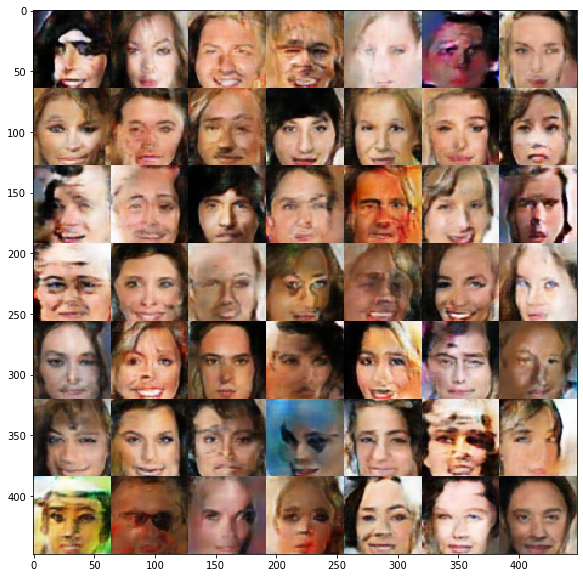

epoch: 6 batch: 0 [D loss: 0.684096] [G loss: 1.087490]
epoch: 6 batch: 1 [D loss: 0.649458] [G loss: 1.131555]
epoch: 6 batch: 2 [D loss: 0.656577] [G loss: 1.121298]
epoch: 6 batch: 3 [D loss: 0.662219] [G loss: 1.031150]
epoch: 6 batch: 4 [D loss: 0.643517] [G loss: 1.122639]
epoch: 6 batch: 5 [D loss: 0.658279] [G loss: 1.180788]
epoch: 6 batch: 6 [D loss: 0.654855] [G loss: 1.123469]
epoch: 6 batch: 7 [D loss: 0.649770] [G loss: 1.106369]
epoch: 6 batch: 8 [D loss: 0.645071] [G loss: 1.153985]
epoch: 6 batch: 9 [D loss: 0.581463] [G loss: 1.130187]
epoch: 6 batch: 10 [D loss: 0.643207] [G loss: 1.203964]
epoch: 6 batch: 11 [D loss: 0.689028] [G loss: 1.197926]
epoch: 6 batch: 12 [D loss: 0.614831] [G loss: 1.063638]
epoch: 6 batch: 13 [D loss: 0.652633] [G loss: 1.186625]
epoch: 6 batch: 14 [D loss: 0.657184] [G loss: 1.170860]
epoch: 6 batch: 15 [D loss: 0.614055] [G loss: 1.189646]
epoch: 6 batch: 16 [D loss: 0.666133] [G loss: 1.207423]
epoch: 6 batch: 17 [D loss: 0.620313] [G 

epoch: 6 batch: 144 [D loss: 0.613632] [G loss: 1.107432]
epoch: 6 batch: 145 [D loss: 0.668059] [G loss: 1.067885]
epoch: 6 batch: 146 [D loss: 0.636000] [G loss: 1.199934]
epoch: 6 batch: 147 [D loss: 0.650808] [G loss: 1.163975]
epoch: 6 batch: 148 [D loss: 0.661710] [G loss: 1.097534]
epoch: 6 batch: 149 [D loss: 0.622222] [G loss: 1.115283]
epoch: 6 batch: 150 [D loss: 0.658506] [G loss: 1.122186]
epoch: 6 batch: 151 [D loss: 0.663197] [G loss: 1.068958]
epoch: 6 batch: 152 [D loss: 0.684771] [G loss: 1.114894]
epoch: 6 batch: 153 [D loss: 0.644305] [G loss: 1.180919]
epoch: 6 batch: 154 [D loss: 0.656792] [G loss: 1.027094]
epoch: 6 batch: 155 [D loss: 0.660961] [G loss: 1.013446]
epoch: 6 batch: 156 [D loss: 0.667306] [G loss: 1.152375]
epoch: 6 batch: 157 [D loss: 0.657945] [G loss: 1.220180]
epoch: 6 batch: 158 [D loss: 0.630780] [G loss: 1.239555]
epoch: 6 batch: 159 [D loss: 0.677426] [G loss: 1.070478]
epoch: 6 batch: 160 [D loss: 0.663780] [G loss: 1.232668]
epoch: 6 batch

epoch: 6 batch: 286 [D loss: 0.634243] [G loss: 1.087147]
epoch: 6 batch: 287 [D loss: 0.660731] [G loss: 1.156862]
epoch: 6 batch: 288 [D loss: 0.668081] [G loss: 1.034485]
epoch: 6 batch: 289 [D loss: 0.676621] [G loss: 1.064929]
epoch: 6 batch: 290 [D loss: 0.671824] [G loss: 1.117365]
epoch: 6 batch: 291 [D loss: 0.676256] [G loss: 1.159513]
epoch: 6 batch: 292 [D loss: 0.642772] [G loss: 1.058750]
epoch: 6 batch: 293 [D loss: 0.639016] [G loss: 1.100428]
epoch: 6 batch: 294 [D loss: 0.688170] [G loss: 1.057217]
epoch: 6 batch: 295 [D loss: 0.684218] [G loss: 1.071926]
epoch: 6 batch: 296 [D loss: 0.676803] [G loss: 1.019409]
epoch: 6 batch: 297 [D loss: 0.632678] [G loss: 1.114806]
epoch: 6 batch: 298 [D loss: 0.693688] [G loss: 1.061039]
epoch: 6 batch: 299 [D loss: 0.655449] [G loss: 1.112695]
epoch: 6 batch: 300 [D loss: 0.671073] [G loss: 1.049663]
epoch: 6 batch: 301 [D loss: 0.620521] [G loss: 1.112936]
epoch: 6 batch: 302 [D loss: 0.647737] [G loss: 1.126741]
epoch: 6 batch

epoch: 6 batch: 428 [D loss: 0.634209] [G loss: 1.094884]
epoch: 6 batch: 429 [D loss: 0.666611] [G loss: 1.074722]
epoch: 6 batch: 430 [D loss: 0.645945] [G loss: 1.166516]
epoch: 6 batch: 431 [D loss: 0.660998] [G loss: 1.103141]
epoch: 6 batch: 432 [D loss: 0.662497] [G loss: 1.126810]
epoch: 6 batch: 433 [D loss: 0.656961] [G loss: 1.111282]
epoch: 6 batch: 434 [D loss: 0.645539] [G loss: 1.151769]
epoch: 6 batch: 435 [D loss: 0.631659] [G loss: 1.198465]
epoch: 6 batch: 436 [D loss: 0.656188] [G loss: 1.133582]
epoch: 6 batch: 437 [D loss: 0.635564] [G loss: 1.029566]
epoch: 6 batch: 438 [D loss: 0.627826] [G loss: 1.103637]
epoch: 6 batch: 439 [D loss: 0.703216] [G loss: 1.103676]
epoch: 6 batch: 440 [D loss: 0.697296] [G loss: 1.107095]
epoch: 6 batch: 441 [D loss: 0.689166] [G loss: 1.043177]
epoch: 6 batch: 442 [D loss: 0.618412] [G loss: 1.117563]
epoch: 6 batch: 443 [D loss: 0.653229] [G loss: 1.151629]
epoch: 6 batch: 444 [D loss: 0.642477] [G loss: 1.135618]
epoch: 6 batch

epoch: 6 batch: 570 [D loss: 0.639776] [G loss: 1.135282]
epoch: 6 batch: 571 [D loss: 0.674725] [G loss: 1.084564]
epoch: 6 batch: 572 [D loss: 0.660134] [G loss: 1.164362]
epoch: 6 batch: 573 [D loss: 0.635952] [G loss: 1.102932]
epoch: 6 batch: 574 [D loss: 0.628085] [G loss: 1.086257]
epoch: 6 batch: 575 [D loss: 0.690627] [G loss: 1.084800]
epoch: 6 batch: 576 [D loss: 0.672232] [G loss: 1.040187]
epoch: 6 batch: 577 [D loss: 0.671836] [G loss: 1.053218]
epoch: 6 batch: 578 [D loss: 0.644867] [G loss: 1.011917]
epoch: 6 batch: 579 [D loss: 0.652869] [G loss: 1.158071]
epoch: 6 batch: 580 [D loss: 0.657137] [G loss: 1.061700]
epoch: 6 batch: 581 [D loss: 0.629965] [G loss: 1.132537]
epoch: 6 batch: 582 [D loss: 0.645041] [G loss: 1.104546]
epoch: 6 batch: 583 [D loss: 0.644281] [G loss: 1.215864]
epoch: 6 batch: 584 [D loss: 0.670555] [G loss: 1.051797]
epoch: 6 batch: 585 [D loss: 0.620144] [G loss: 1.131148]
epoch: 6 batch: 586 [D loss: 0.657674] [G loss: 1.035909]
epoch: 6 batch

epoch: 6 batch: 712 [D loss: 0.624554] [G loss: 1.060756]
epoch: 6 batch: 713 [D loss: 0.650136] [G loss: 1.084736]
epoch: 6 batch: 714 [D loss: 0.633262] [G loss: 1.116747]
epoch: 6 batch: 715 [D loss: 0.664705] [G loss: 1.085186]
epoch: 6 batch: 716 [D loss: 0.647493] [G loss: 1.158963]
epoch: 6 batch: 717 [D loss: 0.692255] [G loss: 1.138634]
epoch: 6 batch: 718 [D loss: 0.677245] [G loss: 1.168843]
epoch: 6 batch: 719 [D loss: 0.637516] [G loss: 1.122301]
epoch: 6 batch: 720 [D loss: 0.711422] [G loss: 1.011539]
epoch: 6 batch: 721 [D loss: 0.674703] [G loss: 1.072721]
epoch: 6 batch: 722 [D loss: 0.657855] [G loss: 1.113048]
epoch: 6 batch: 723 [D loss: 0.642070] [G loss: 1.070925]
epoch: 6 batch: 724 [D loss: 0.699933] [G loss: 1.011984]
epoch: 6 batch: 725 [D loss: 0.605360] [G loss: 1.054582]
epoch: 6 batch: 726 [D loss: 0.659585] [G loss: 1.111480]
epoch: 6 batch: 727 [D loss: 0.681930] [G loss: 1.155711]
epoch: 6 batch: 728 [D loss: 0.665321] [G loss: 1.145901]
epoch: 6 batch

epoch: 6 batch: 854 [D loss: 0.673962] [G loss: 1.094183]
epoch: 6 batch: 855 [D loss: 0.674918] [G loss: 1.067901]
epoch: 6 batch: 856 [D loss: 0.652927] [G loss: 1.107433]
epoch: 6 batch: 857 [D loss: 0.644468] [G loss: 1.067570]
epoch: 6 batch: 858 [D loss: 0.651392] [G loss: 1.197874]
epoch: 6 batch: 859 [D loss: 0.637630] [G loss: 1.174485]
epoch: 6 batch: 860 [D loss: 0.661521] [G loss: 1.060153]
epoch: 6 batch: 861 [D loss: 0.675488] [G loss: 1.034398]
epoch: 6 batch: 862 [D loss: 0.669502] [G loss: 1.109732]
epoch: 6 batch: 863 [D loss: 0.661110] [G loss: 1.115753]
epoch: 6 batch: 864 [D loss: 0.617672] [G loss: 1.056764]
epoch: 6 batch: 865 [D loss: 0.632576] [G loss: 1.106347]
epoch: 6 batch: 866 [D loss: 0.640233] [G loss: 1.080426]
epoch: 6 batch: 867 [D loss: 0.695449] [G loss: 0.969678]
epoch: 6 batch: 868 [D loss: 0.656934] [G loss: 1.026794]
epoch: 6 batch: 869 [D loss: 0.681782] [G loss: 1.149424]
epoch: 6 batch: 870 [D loss: 0.695721] [G loss: 1.070412]
epoch: 6 batch

epoch: 6 batch: 996 [D loss: 0.606848] [G loss: 1.112650]
epoch: 6 batch: 997 [D loss: 0.654202] [G loss: 1.117808]
epoch: 6 batch: 998 [D loss: 0.638302] [G loss: 1.069689]
epoch: 6 batch: 999 [D loss: 0.627041] [G loss: 1.040856]
epoch: 6 batch: 1000 [D loss: 0.709957] [G loss: 1.064129]
epoch: 6 batch: 1001 [D loss: 0.635301] [G loss: 1.063931]
epoch: 6 batch: 1002 [D loss: 0.643786] [G loss: 1.119913]
epoch: 6 batch: 1003 [D loss: 0.655809] [G loss: 1.018015]
epoch: 6 batch: 1004 [D loss: 0.694238] [G loss: 1.071960]
epoch: 6 batch: 1005 [D loss: 0.664077] [G loss: 1.054557]
epoch: 6 batch: 1006 [D loss: 0.655032] [G loss: 1.166494]
epoch: 6 batch: 1007 [D loss: 0.649834] [G loss: 1.071400]
epoch: 6 batch: 1008 [D loss: 0.675825] [G loss: 1.115671]
epoch: 6 batch: 1009 [D loss: 0.657156] [G loss: 1.151469]
epoch: 6 batch: 1010 [D loss: 0.603127] [G loss: 1.138293]
epoch: 6 batch: 1011 [D loss: 0.636873] [G loss: 1.092085]
epoch: 6 batch: 1012 [D loss: 0.651629] [G loss: 1.151077]
e

epoch: 6 batch: 1135 [D loss: 0.649004] [G loss: 1.127633]
epoch: 6 batch: 1136 [D loss: 0.642574] [G loss: 1.138147]
epoch: 6 batch: 1137 [D loss: 0.628646] [G loss: 1.063576]
epoch: 6 batch: 1138 [D loss: 0.690173] [G loss: 1.099597]
epoch: 6 batch: 1139 [D loss: 0.636858] [G loss: 1.033265]
epoch: 6 batch: 1140 [D loss: 0.680717] [G loss: 1.018904]
epoch: 6 batch: 1141 [D loss: 0.609840] [G loss: 1.116355]
epoch: 6 batch: 1142 [D loss: 0.728618] [G loss: 0.999244]
epoch: 6 batch: 1143 [D loss: 0.662693] [G loss: 1.047582]
epoch: 6 batch: 1144 [D loss: 0.682157] [G loss: 1.103150]
epoch: 6 batch: 1145 [D loss: 0.645975] [G loss: 1.123618]
epoch: 6 batch: 1146 [D loss: 0.643743] [G loss: 1.122525]
epoch: 6 batch: 1147 [D loss: 0.701154] [G loss: 1.065535]
epoch: 6 batch: 1148 [D loss: 0.675244] [G loss: 1.050634]
epoch: 6 batch: 1149 [D loss: 0.702119] [G loss: 1.120171]
epoch: 6 batch: 1150 [D loss: 0.652335] [G loss: 1.168138]
epoch: 6 batch: 1151 [D loss: 0.711018] [G loss: 1.05115

epoch: 6 batch: 1274 [D loss: 0.664092] [G loss: 1.068144]
epoch: 6 batch: 1275 [D loss: 0.634023] [G loss: 1.055080]
epoch: 6 batch: 1276 [D loss: 0.659473] [G loss: 1.026877]
epoch: 6 batch: 1277 [D loss: 0.671156] [G loss: 1.113487]
epoch: 6 batch: 1278 [D loss: 0.643471] [G loss: 1.093103]
epoch: 6 batch: 1279 [D loss: 0.635180] [G loss: 1.157228]
epoch: 6 batch: 1280 [D loss: 0.666771] [G loss: 1.164047]
epoch: 6 batch: 1281 [D loss: 0.650615] [G loss: 1.137796]
epoch: 6 batch: 1282 [D loss: 0.678427] [G loss: 1.022726]
epoch: 6 batch: 1283 [D loss: 0.660643] [G loss: 1.085809]
epoch: 6 batch: 1284 [D loss: 0.640197] [G loss: 1.028161]
epoch: 6 batch: 1285 [D loss: 0.688835] [G loss: 1.050758]
epoch: 6 batch: 1286 [D loss: 0.625966] [G loss: 1.065911]
epoch: 6 batch: 1287 [D loss: 0.667586] [G loss: 1.091505]
epoch: 6 batch: 1288 [D loss: 0.648404] [G loss: 1.128237]
epoch: 6 batch: 1289 [D loss: 0.631114] [G loss: 1.097633]
epoch: 6 batch: 1290 [D loss: 0.651952] [G loss: 1.08964

epoch: 6 batch: 1413 [D loss: 0.670632] [G loss: 1.132660]
epoch: 6 batch: 1414 [D loss: 0.592778] [G loss: 1.161519]
epoch: 6 batch: 1415 [D loss: 0.670905] [G loss: 1.026381]
epoch: 6 batch: 1416 [D loss: 0.669830] [G loss: 1.061423]
epoch: 6 batch: 1417 [D loss: 0.619781] [G loss: 1.112371]
epoch: 6 batch: 1418 [D loss: 0.629038] [G loss: 1.109788]
epoch: 6 batch: 1419 [D loss: 0.669082] [G loss: 1.086559]
epoch: 6 batch: 1420 [D loss: 0.627295] [G loss: 1.047631]
epoch: 6 batch: 1421 [D loss: 0.689888] [G loss: 1.075814]
epoch: 6 batch: 1422 [D loss: 0.688961] [G loss: 1.010140]
epoch: 6 batch: 1423 [D loss: 0.636858] [G loss: 1.114874]
epoch: 6 batch: 1424 [D loss: 0.676057] [G loss: 1.001619]
epoch: 6 batch: 1425 [D loss: 0.643369] [G loss: 1.063923]
epoch: 6 batch: 1426 [D loss: 0.635601] [G loss: 1.124577]
epoch: 6 batch: 1427 [D loss: 0.673761] [G loss: 1.080361]
epoch: 6 batch: 1428 [D loss: 0.626740] [G loss: 1.077541]
epoch: 6 batch: 1429 [D loss: 0.659549] [G loss: 1.04170

epoch: 6 batch: 1552 [D loss: 0.661569] [G loss: 1.058396]
epoch: 6 batch: 1553 [D loss: 0.688620] [G loss: 1.103155]
epoch: 6 batch: 1554 [D loss: 0.677542] [G loss: 1.024006]
epoch: 6 batch: 1555 [D loss: 0.683318] [G loss: 1.144583]
epoch: 6 batch: 1556 [D loss: 0.667676] [G loss: 1.020538]
epoch: 6 batch: 1557 [D loss: 0.671939] [G loss: 1.046377]
epoch: 6 batch: 1558 [D loss: 0.685952] [G loss: 1.007519]
epoch: 6 batch: 1559 [D loss: 0.642730] [G loss: 1.154176]
epoch: 6 batch: 1560 [D loss: 0.675362] [G loss: 1.047860]
epoch: 6 batch: 1561 [D loss: 0.676971] [G loss: 1.157591]
epoch: 6 batch: 1562 [D loss: 0.662800] [G loss: 1.108213]
epoch: 6 batch: 1563 [D loss: 0.671516] [G loss: 1.145323]
epoch: 6 batch: 1564 [D loss: 0.650418] [G loss: 1.093925]
epoch: 6 batch: 1565 [D loss: 0.668310] [G loss: 1.132633]
epoch: 6 batch: 1566 [D loss: 0.703204] [G loss: 1.057028]
epoch: 6 batch: 1567 [D loss: 0.658520] [G loss: 1.127367]
epoch: 6 batch: 1568 [D loss: 0.654977] [G loss: 1.09273

epoch: 7 batch: 113 [D loss: 0.631752] [G loss: 1.090805]
epoch: 7 batch: 114 [D loss: 0.688212] [G loss: 1.030856]
epoch: 7 batch: 115 [D loss: 0.648865] [G loss: 1.131929]
epoch: 7 batch: 116 [D loss: 0.660328] [G loss: 1.145144]
epoch: 7 batch: 117 [D loss: 0.644445] [G loss: 1.084800]
epoch: 7 batch: 118 [D loss: 0.706702] [G loss: 1.036590]
epoch: 7 batch: 119 [D loss: 0.616839] [G loss: 1.169775]
epoch: 7 batch: 120 [D loss: 0.659906] [G loss: 1.113976]
epoch: 7 batch: 121 [D loss: 0.642062] [G loss: 1.042941]
epoch: 7 batch: 122 [D loss: 0.628906] [G loss: 1.158500]
epoch: 7 batch: 123 [D loss: 0.649807] [G loss: 1.044390]
epoch: 7 batch: 124 [D loss: 0.646294] [G loss: 1.078298]
epoch: 7 batch: 125 [D loss: 0.625893] [G loss: 1.090475]
epoch: 7 batch: 126 [D loss: 0.654289] [G loss: 1.104485]
epoch: 7 batch: 127 [D loss: 0.665966] [G loss: 1.097121]
epoch: 7 batch: 128 [D loss: 0.651317] [G loss: 1.132748]
epoch: 7 batch: 129 [D loss: 0.621570] [G loss: 1.116897]
epoch: 7 batch

epoch: 7 batch: 255 [D loss: 0.684998] [G loss: 1.013793]
epoch: 7 batch: 256 [D loss: 0.613673] [G loss: 1.155619]
epoch: 7 batch: 257 [D loss: 0.661371] [G loss: 1.051112]
epoch: 7 batch: 258 [D loss: 0.669310] [G loss: 1.110705]
epoch: 7 batch: 259 [D loss: 0.653145] [G loss: 1.122389]
epoch: 7 batch: 260 [D loss: 0.666632] [G loss: 1.092073]
epoch: 7 batch: 261 [D loss: 0.654438] [G loss: 1.115583]
epoch: 7 batch: 262 [D loss: 0.658298] [G loss: 1.127187]
epoch: 7 batch: 263 [D loss: 0.692387] [G loss: 1.050456]
epoch: 7 batch: 264 [D loss: 0.644776] [G loss: 1.009655]
epoch: 7 batch: 265 [D loss: 0.634647] [G loss: 1.122608]
epoch: 7 batch: 266 [D loss: 0.664185] [G loss: 1.097881]
epoch: 7 batch: 267 [D loss: 0.674322] [G loss: 1.068874]
epoch: 7 batch: 268 [D loss: 0.621521] [G loss: 1.086005]
epoch: 7 batch: 269 [D loss: 0.678935] [G loss: 1.045878]
epoch: 7 batch: 270 [D loss: 0.652358] [G loss: 1.100277]
epoch: 7 batch: 271 [D loss: 0.657998] [G loss: 1.140873]
epoch: 7 batch

epoch: 7 batch: 397 [D loss: 0.672414] [G loss: 1.095708]
epoch: 7 batch: 398 [D loss: 0.660412] [G loss: 1.081756]
epoch: 7 batch: 399 [D loss: 0.695161] [G loss: 1.067893]
epoch: 7 batch: 400 [D loss: 0.673425] [G loss: 1.062164]
epoch: 7 batch: 401 [D loss: 0.669547] [G loss: 1.080701]
epoch: 7 batch: 402 [D loss: 0.646584] [G loss: 1.111951]
epoch: 7 batch: 403 [D loss: 0.658207] [G loss: 1.108148]
epoch: 7 batch: 404 [D loss: 0.600645] [G loss: 1.090075]
epoch: 7 batch: 405 [D loss: 0.658881] [G loss: 1.156131]
epoch: 7 batch: 406 [D loss: 0.677983] [G loss: 1.061874]
epoch: 7 batch: 407 [D loss: 0.682793] [G loss: 1.056595]
epoch: 7 batch: 408 [D loss: 0.670623] [G loss: 1.093248]
epoch: 7 batch: 409 [D loss: 0.675825] [G loss: 1.080480]
epoch: 7 batch: 410 [D loss: 0.648369] [G loss: 1.046036]
epoch: 7 batch: 411 [D loss: 0.687443] [G loss: 0.989401]
epoch: 7 batch: 412 [D loss: 0.667506] [G loss: 1.099045]
epoch: 7 batch: 413 [D loss: 0.646127] [G loss: 1.102610]
epoch: 7 batch

epoch: 7 batch: 539 [D loss: 0.648512] [G loss: 0.971028]
epoch: 7 batch: 540 [D loss: 0.674481] [G loss: 1.085719]
epoch: 7 batch: 541 [D loss: 0.628172] [G loss: 1.143109]
epoch: 7 batch: 542 [D loss: 0.650361] [G loss: 1.085757]
epoch: 7 batch: 543 [D loss: 0.657273] [G loss: 0.996714]
epoch: 7 batch: 544 [D loss: 0.643877] [G loss: 1.080246]
epoch: 7 batch: 545 [D loss: 0.696084] [G loss: 0.995583]
epoch: 7 batch: 546 [D loss: 0.629492] [G loss: 1.083311]
epoch: 7 batch: 547 [D loss: 0.640693] [G loss: 1.069273]
epoch: 7 batch: 548 [D loss: 0.662725] [G loss: 1.041779]
epoch: 7 batch: 549 [D loss: 0.665751] [G loss: 1.083512]
epoch: 7 batch: 550 [D loss: 0.695562] [G loss: 1.075737]
epoch: 7 batch: 551 [D loss: 0.703268] [G loss: 1.058945]
epoch: 7 batch: 552 [D loss: 0.663945] [G loss: 1.109969]
epoch: 7 batch: 553 [D loss: 0.637095] [G loss: 1.079806]
epoch: 7 batch: 554 [D loss: 0.673904] [G loss: 1.028706]
epoch: 7 batch: 555 [D loss: 0.674725] [G loss: 1.014606]
epoch: 7 batch

epoch: 7 batch: 681 [D loss: 0.680203] [G loss: 1.108112]
epoch: 7 batch: 682 [D loss: 0.645486] [G loss: 1.100533]
epoch: 7 batch: 683 [D loss: 0.657190] [G loss: 1.119144]
epoch: 7 batch: 684 [D loss: 0.646419] [G loss: 1.130909]
epoch: 7 batch: 685 [D loss: 0.647490] [G loss: 0.970277]
epoch: 7 batch: 686 [D loss: 0.676624] [G loss: 1.072060]
epoch: 7 batch: 687 [D loss: 0.642280] [G loss: 1.063006]
epoch: 7 batch: 688 [D loss: 0.679009] [G loss: 1.015579]
epoch: 7 batch: 689 [D loss: 0.622298] [G loss: 1.078374]
epoch: 7 batch: 690 [D loss: 0.621480] [G loss: 1.122023]
epoch: 7 batch: 691 [D loss: 0.687917] [G loss: 1.037793]
epoch: 7 batch: 692 [D loss: 0.680880] [G loss: 1.074940]
epoch: 7 batch: 693 [D loss: 0.686126] [G loss: 1.125167]
epoch: 7 batch: 694 [D loss: 0.721220] [G loss: 1.142487]
epoch: 7 batch: 695 [D loss: 0.689977] [G loss: 1.102896]
epoch: 7 batch: 696 [D loss: 0.646021] [G loss: 1.096927]
epoch: 7 batch: 697 [D loss: 0.689700] [G loss: 1.060739]
epoch: 7 batch

epoch: 7 batch: 823 [D loss: 0.650269] [G loss: 1.096253]
epoch: 7 batch: 824 [D loss: 0.676262] [G loss: 1.023641]
epoch: 7 batch: 825 [D loss: 0.636894] [G loss: 1.088774]
epoch: 7 batch: 826 [D loss: 0.642730] [G loss: 1.056896]
epoch: 7 batch: 827 [D loss: 0.675399] [G loss: 1.029322]
epoch: 7 batch: 828 [D loss: 0.705020] [G loss: 1.060221]
epoch: 7 batch: 829 [D loss: 0.670822] [G loss: 1.037509]
epoch: 7 batch: 830 [D loss: 0.634643] [G loss: 1.094573]
epoch: 7 batch: 831 [D loss: 0.677489] [G loss: 1.087905]
epoch: 7 batch: 832 [D loss: 0.685724] [G loss: 1.075279]
epoch: 7 batch: 833 [D loss: 0.658872] [G loss: 1.062098]
epoch: 7 batch: 834 [D loss: 0.627461] [G loss: 0.988255]
epoch: 7 batch: 835 [D loss: 0.631555] [G loss: 1.095759]
epoch: 7 batch: 836 [D loss: 0.711164] [G loss: 1.020483]
epoch: 7 batch: 837 [D loss: 0.686409] [G loss: 0.961362]
epoch: 7 batch: 838 [D loss: 0.665531] [G loss: 1.034633]
epoch: 7 batch: 839 [D loss: 0.671262] [G loss: 0.954308]
epoch: 7 batch

epoch: 7 batch: 965 [D loss: 0.651745] [G loss: 1.086483]
epoch: 7 batch: 966 [D loss: 0.671511] [G loss: 1.067353]
epoch: 7 batch: 967 [D loss: 0.696371] [G loss: 1.016548]
epoch: 7 batch: 968 [D loss: 0.675719] [G loss: 1.082770]
epoch: 7 batch: 969 [D loss: 0.669180] [G loss: 0.964862]
epoch: 7 batch: 970 [D loss: 0.652490] [G loss: 1.103601]
epoch: 7 batch: 971 [D loss: 0.690057] [G loss: 1.108472]
epoch: 7 batch: 972 [D loss: 0.657747] [G loss: 1.081644]
epoch: 7 batch: 973 [D loss: 0.675775] [G loss: 1.081390]
epoch: 7 batch: 974 [D loss: 0.726965] [G loss: 1.107108]
epoch: 7 batch: 975 [D loss: 0.669420] [G loss: 1.062997]
epoch: 7 batch: 976 [D loss: 0.652252] [G loss: 1.089790]
epoch: 7 batch: 977 [D loss: 0.671276] [G loss: 1.073460]
epoch: 7 batch: 978 [D loss: 0.643285] [G loss: 1.058455]
epoch: 7 batch: 979 [D loss: 0.669755] [G loss: 1.021462]
epoch: 7 batch: 980 [D loss: 0.649874] [G loss: 1.040954]
epoch: 7 batch: 981 [D loss: 0.681965] [G loss: 1.067947]
epoch: 7 batch

epoch: 7 batch: 1105 [D loss: 0.661310] [G loss: 1.129301]
epoch: 7 batch: 1106 [D loss: 0.690956] [G loss: 0.992592]
epoch: 7 batch: 1107 [D loss: 0.654399] [G loss: 1.038276]
epoch: 7 batch: 1108 [D loss: 0.649891] [G loss: 1.069542]
epoch: 7 batch: 1109 [D loss: 0.640766] [G loss: 1.067986]
epoch: 7 batch: 1110 [D loss: 0.702111] [G loss: 1.066347]
epoch: 7 batch: 1111 [D loss: 0.665139] [G loss: 1.061870]
epoch: 7 batch: 1112 [D loss: 0.648959] [G loss: 1.100183]
epoch: 7 batch: 1113 [D loss: 0.692775] [G loss: 1.169770]
epoch: 7 batch: 1114 [D loss: 0.625268] [G loss: 1.087206]
epoch: 7 batch: 1115 [D loss: 0.664965] [G loss: 1.127320]
epoch: 7 batch: 1116 [D loss: 0.670402] [G loss: 1.073087]
epoch: 7 batch: 1117 [D loss: 0.655806] [G loss: 1.076322]
epoch: 7 batch: 1118 [D loss: 0.677593] [G loss: 1.136359]
epoch: 7 batch: 1119 [D loss: 0.636204] [G loss: 1.082292]
epoch: 7 batch: 1120 [D loss: 0.648871] [G loss: 1.070212]
epoch: 7 batch: 1121 [D loss: 0.662463] [G loss: 1.03092

epoch: 7 batch: 1244 [D loss: 0.651266] [G loss: 1.025245]
epoch: 7 batch: 1245 [D loss: 0.644344] [G loss: 1.033728]
epoch: 7 batch: 1246 [D loss: 0.651463] [G loss: 1.190004]
epoch: 7 batch: 1247 [D loss: 0.677325] [G loss: 1.085248]
epoch: 7 batch: 1248 [D loss: 0.648354] [G loss: 1.091971]
epoch: 7 batch: 1249 [D loss: 0.662404] [G loss: 1.026750]
epoch: 7 batch: 1250 [D loss: 0.695500] [G loss: 0.994101]
epoch: 7 batch: 1251 [D loss: 0.672413] [G loss: 1.040098]
epoch: 7 batch: 1252 [D loss: 0.642859] [G loss: 1.079926]
epoch: 7 batch: 1253 [D loss: 0.658238] [G loss: 1.054098]
epoch: 7 batch: 1254 [D loss: 0.610237] [G loss: 1.110300]
epoch: 7 batch: 1255 [D loss: 0.634495] [G loss: 1.047663]
epoch: 7 batch: 1256 [D loss: 0.675424] [G loss: 1.042215]
epoch: 7 batch: 1257 [D loss: 0.669180] [G loss: 1.102961]
epoch: 7 batch: 1258 [D loss: 0.648130] [G loss: 1.089175]
epoch: 7 batch: 1259 [D loss: 0.679563] [G loss: 1.056998]
epoch: 7 batch: 1260 [D loss: 0.651102] [G loss: 1.09867

epoch: 7 batch: 1383 [D loss: 0.710459] [G loss: 1.082424]
epoch: 7 batch: 1384 [D loss: 0.640236] [G loss: 1.125762]
epoch: 7 batch: 1385 [D loss: 0.670777] [G loss: 1.072458]
epoch: 7 batch: 1386 [D loss: 0.688428] [G loss: 1.110661]
epoch: 7 batch: 1387 [D loss: 0.681750] [G loss: 0.997245]
epoch: 7 batch: 1388 [D loss: 0.644113] [G loss: 1.038279]
epoch: 7 batch: 1389 [D loss: 0.683368] [G loss: 1.050631]
epoch: 7 batch: 1390 [D loss: 0.661440] [G loss: 1.063501]
epoch: 7 batch: 1391 [D loss: 0.616724] [G loss: 1.070255]
epoch: 7 batch: 1392 [D loss: 0.610780] [G loss: 1.164769]
epoch: 7 batch: 1393 [D loss: 0.699219] [G loss: 1.172372]
epoch: 7 batch: 1394 [D loss: 0.715995] [G loss: 1.067452]
epoch: 7 batch: 1395 [D loss: 0.687497] [G loss: 1.126616]
epoch: 7 batch: 1396 [D loss: 0.659716] [G loss: 1.028255]
epoch: 7 batch: 1397 [D loss: 0.655754] [G loss: 1.083401]
epoch: 7 batch: 1398 [D loss: 0.700182] [G loss: 1.058498]
epoch: 7 batch: 1399 [D loss: 0.658649] [G loss: 1.05195

epoch: 7 batch: 1522 [D loss: 0.711082] [G loss: 0.990981]
epoch: 7 batch: 1523 [D loss: 0.622101] [G loss: 1.030719]
epoch: 7 batch: 1524 [D loss: 0.679732] [G loss: 1.052252]
epoch: 7 batch: 1525 [D loss: 0.645669] [G loss: 1.076997]
epoch: 7 batch: 1526 [D loss: 0.694140] [G loss: 1.031389]
epoch: 7 batch: 1527 [D loss: 0.680394] [G loss: 1.007824]
epoch: 7 batch: 1528 [D loss: 0.659009] [G loss: 0.934589]
epoch: 7 batch: 1529 [D loss: 0.656246] [G loss: 1.061040]
epoch: 7 batch: 1530 [D loss: 0.685103] [G loss: 1.090196]
epoch: 7 batch: 1531 [D loss: 0.664620] [G loss: 1.077505]
epoch: 7 batch: 1532 [D loss: 0.638750] [G loss: 1.009119]
epoch: 7 batch: 1533 [D loss: 0.644972] [G loss: 1.020076]
epoch: 7 batch: 1534 [D loss: 0.683503] [G loss: 1.039485]
epoch: 7 batch: 1535 [D loss: 0.688280] [G loss: 1.147941]
epoch: 7 batch: 1536 [D loss: 0.714153] [G loss: 0.992655]
epoch: 7 batch: 1537 [D loss: 0.674100] [G loss: 0.995056]
epoch: 7 batch: 1538 [D loss: 0.694720] [G loss: 1.03682

epoch: 8 batch: 82 [D loss: 0.673852] [G loss: 0.996756]
epoch: 8 batch: 83 [D loss: 0.656549] [G loss: 1.008829]
epoch: 8 batch: 84 [D loss: 0.707184] [G loss: 1.098544]
epoch: 8 batch: 85 [D loss: 0.656730] [G loss: 1.038180]
epoch: 8 batch: 86 [D loss: 0.681663] [G loss: 1.089862]
epoch: 8 batch: 87 [D loss: 0.675350] [G loss: 1.021587]
epoch: 8 batch: 88 [D loss: 0.640525] [G loss: 1.052995]
epoch: 8 batch: 89 [D loss: 0.645179] [G loss: 1.174481]
epoch: 8 batch: 90 [D loss: 0.684749] [G loss: 1.018072]
epoch: 8 batch: 91 [D loss: 0.674301] [G loss: 1.056694]
epoch: 8 batch: 92 [D loss: 0.620681] [G loss: 1.061268]
epoch: 8 batch: 93 [D loss: 0.657134] [G loss: 1.044545]
epoch: 8 batch: 94 [D loss: 0.648021] [G loss: 1.077942]
epoch: 8 batch: 95 [D loss: 0.616139] [G loss: 1.081436]
epoch: 8 batch: 96 [D loss: 0.657845] [G loss: 1.062668]
epoch: 8 batch: 97 [D loss: 0.676004] [G loss: 1.117971]
epoch: 8 batch: 98 [D loss: 0.668379] [G loss: 1.023677]
epoch: 8 batch: 99 [D loss: 0.6

epoch: 8 batch: 224 [D loss: 0.672083] [G loss: 1.038987]
epoch: 8 batch: 225 [D loss: 0.647599] [G loss: 1.140992]
epoch: 8 batch: 226 [D loss: 0.677446] [G loss: 1.106226]
epoch: 8 batch: 227 [D loss: 0.664000] [G loss: 0.993543]
epoch: 8 batch: 228 [D loss: 0.669269] [G loss: 1.018735]
epoch: 8 batch: 229 [D loss: 0.685346] [G loss: 1.001291]
epoch: 8 batch: 230 [D loss: 0.664700] [G loss: 0.919468]
epoch: 8 batch: 231 [D loss: 0.665511] [G loss: 1.125515]
epoch: 8 batch: 232 [D loss: 0.661420] [G loss: 1.051006]
epoch: 8 batch: 233 [D loss: 0.682174] [G loss: 1.046350]
epoch: 8 batch: 234 [D loss: 0.629086] [G loss: 1.046594]
epoch: 8 batch: 235 [D loss: 0.616651] [G loss: 1.154653]
epoch: 8 batch: 236 [D loss: 0.657176] [G loss: 1.048095]
epoch: 8 batch: 237 [D loss: 0.666909] [G loss: 1.042372]
epoch: 8 batch: 238 [D loss: 0.676727] [G loss: 1.112367]
epoch: 8 batch: 239 [D loss: 0.651173] [G loss: 1.059336]
epoch: 8 batch: 240 [D loss: 0.666246] [G loss: 1.062171]
epoch: 8 batch

epoch: 8 batch: 366 [D loss: 0.680654] [G loss: 1.062632]
epoch: 8 batch: 367 [D loss: 0.650727] [G loss: 1.063540]
epoch: 8 batch: 368 [D loss: 0.683112] [G loss: 1.060862]
epoch: 8 batch: 369 [D loss: 0.633756] [G loss: 1.000110]
epoch: 8 batch: 370 [D loss: 0.630901] [G loss: 1.087058]
epoch: 8 batch: 371 [D loss: 0.645934] [G loss: 1.031965]
epoch: 8 batch: 372 [D loss: 0.647528] [G loss: 0.960929]
epoch: 8 batch: 373 [D loss: 0.657061] [G loss: 1.012488]
epoch: 8 batch: 374 [D loss: 0.659233] [G loss: 1.087844]
epoch: 8 batch: 375 [D loss: 0.672088] [G loss: 0.998154]
epoch: 8 batch: 376 [D loss: 0.629228] [G loss: 1.037151]
epoch: 8 batch: 377 [D loss: 0.658449] [G loss: 1.052201]
epoch: 8 batch: 378 [D loss: 0.685661] [G loss: 0.985771]
epoch: 8 batch: 379 [D loss: 0.637574] [G loss: 1.032431]
epoch: 8 batch: 380 [D loss: 0.616473] [G loss: 1.074845]
epoch: 8 batch: 381 [D loss: 0.650387] [G loss: 1.052675]
epoch: 8 batch: 382 [D loss: 0.661666] [G loss: 1.041023]
epoch: 8 batch

epoch: 8 batch: 508 [D loss: 0.678375] [G loss: 1.090385]
epoch: 8 batch: 509 [D loss: 0.663885] [G loss: 0.943409]
epoch: 8 batch: 510 [D loss: 0.674268] [G loss: 1.059901]
epoch: 8 batch: 511 [D loss: 0.638951] [G loss: 1.053718]
epoch: 8 batch: 512 [D loss: 0.647903] [G loss: 1.107203]
epoch: 8 batch: 513 [D loss: 0.637334] [G loss: 0.978810]
epoch: 8 batch: 514 [D loss: 0.639183] [G loss: 1.066453]
epoch: 8 batch: 515 [D loss: 0.654505] [G loss: 1.062034]
epoch: 8 batch: 516 [D loss: 0.688080] [G loss: 1.012395]
epoch: 8 batch: 517 [D loss: 0.637381] [G loss: 0.983110]
epoch: 8 batch: 518 [D loss: 0.647507] [G loss: 1.026862]
epoch: 8 batch: 519 [D loss: 0.703878] [G loss: 1.037490]
epoch: 8 batch: 520 [D loss: 0.661355] [G loss: 1.029763]
epoch: 8 batch: 521 [D loss: 0.682876] [G loss: 1.038880]
epoch: 8 batch: 522 [D loss: 0.635554] [G loss: 1.015960]
epoch: 8 batch: 523 [D loss: 0.662549] [G loss: 1.038504]
epoch: 8 batch: 524 [D loss: 0.680204] [G loss: 1.088535]
epoch: 8 batch

epoch: 8 batch: 650 [D loss: 0.649474] [G loss: 1.054381]
epoch: 8 batch: 651 [D loss: 0.662625] [G loss: 0.997930]
epoch: 8 batch: 652 [D loss: 0.690858] [G loss: 1.063169]
epoch: 8 batch: 653 [D loss: 0.660822] [G loss: 1.000516]
epoch: 8 batch: 654 [D loss: 0.660981] [G loss: 1.062915]
epoch: 8 batch: 655 [D loss: 0.650715] [G loss: 1.040499]
epoch: 8 batch: 656 [D loss: 0.638287] [G loss: 1.059391]
epoch: 8 batch: 657 [D loss: 0.679914] [G loss: 1.114754]
epoch: 8 batch: 658 [D loss: 0.659903] [G loss: 1.081259]
epoch: 8 batch: 659 [D loss: 0.670821] [G loss: 1.072313]
epoch: 8 batch: 660 [D loss: 0.618300] [G loss: 0.984605]
epoch: 8 batch: 661 [D loss: 0.660537] [G loss: 1.025102]
epoch: 8 batch: 662 [D loss: 0.681905] [G loss: 1.047867]
epoch: 8 batch: 663 [D loss: 0.660443] [G loss: 1.131673]
epoch: 8 batch: 664 [D loss: 0.624704] [G loss: 1.101857]
epoch: 8 batch: 665 [D loss: 0.642497] [G loss: 1.067823]
epoch: 8 batch: 666 [D loss: 0.687594] [G loss: 1.067494]
epoch: 8 batch

epoch: 8 batch: 792 [D loss: 0.684055] [G loss: 0.997055]
epoch: 8 batch: 793 [D loss: 0.683605] [G loss: 1.124950]
epoch: 8 batch: 794 [D loss: 0.658400] [G loss: 1.110918]
epoch: 8 batch: 795 [D loss: 0.672477] [G loss: 1.062607]
epoch: 8 batch: 796 [D loss: 0.609052] [G loss: 1.082637]
epoch: 8 batch: 797 [D loss: 0.609904] [G loss: 1.102795]
epoch: 8 batch: 798 [D loss: 0.709351] [G loss: 1.023334]
epoch: 8 batch: 799 [D loss: 0.712077] [G loss: 1.064852]
epoch: 8 batch: 800 [D loss: 0.630754] [G loss: 1.055408]
epoch: 8 batch: 801 [D loss: 0.677335] [G loss: 0.965079]
epoch: 8 batch: 802 [D loss: 0.670954] [G loss: 0.998134]
epoch: 8 batch: 803 [D loss: 0.645797] [G loss: 1.092637]
epoch: 8 batch: 804 [D loss: 0.664058] [G loss: 1.134781]
epoch: 8 batch: 805 [D loss: 0.643925] [G loss: 1.080850]
epoch: 8 batch: 806 [D loss: 0.644124] [G loss: 0.971274]
epoch: 8 batch: 807 [D loss: 0.679753] [G loss: 1.042509]
epoch: 8 batch: 808 [D loss: 0.700788] [G loss: 1.065339]
epoch: 8 batch

epoch: 8 batch: 934 [D loss: 0.642460] [G loss: 1.022050]
epoch: 8 batch: 935 [D loss: 0.687294] [G loss: 0.985894]
epoch: 8 batch: 936 [D loss: 0.644446] [G loss: 1.015281]
epoch: 8 batch: 937 [D loss: 0.648878] [G loss: 0.983351]
epoch: 8 batch: 938 [D loss: 0.634335] [G loss: 1.041532]
epoch: 8 batch: 939 [D loss: 0.646515] [G loss: 1.092226]
epoch: 8 batch: 940 [D loss: 0.713548] [G loss: 0.985597]
epoch: 8 batch: 941 [D loss: 0.694704] [G loss: 0.991914]
epoch: 8 batch: 942 [D loss: 0.658691] [G loss: 1.038848]
epoch: 8 batch: 943 [D loss: 0.658812] [G loss: 1.120635]
epoch: 8 batch: 944 [D loss: 0.662724] [G loss: 1.009983]
epoch: 8 batch: 945 [D loss: 0.664117] [G loss: 1.076237]
epoch: 8 batch: 946 [D loss: 0.655943] [G loss: 0.971803]
epoch: 8 batch: 947 [D loss: 0.643092] [G loss: 1.071505]
epoch: 8 batch: 948 [D loss: 0.674376] [G loss: 1.059646]
epoch: 8 batch: 949 [D loss: 0.698683] [G loss: 1.075631]
epoch: 8 batch: 950 [D loss: 0.633502] [G loss: 1.097234]
epoch: 8 batch

epoch: 8 batch: 1074 [D loss: 0.640885] [G loss: 1.038220]
epoch: 8 batch: 1075 [D loss: 0.656080] [G loss: 1.089286]
epoch: 8 batch: 1076 [D loss: 0.659524] [G loss: 1.042760]
epoch: 8 batch: 1077 [D loss: 0.687631] [G loss: 1.114163]
epoch: 8 batch: 1078 [D loss: 0.650604] [G loss: 1.078753]
epoch: 8 batch: 1079 [D loss: 0.670112] [G loss: 0.979212]
epoch: 8 batch: 1080 [D loss: 0.643687] [G loss: 1.102719]
epoch: 8 batch: 1081 [D loss: 0.669026] [G loss: 1.046309]
epoch: 8 batch: 1082 [D loss: 0.710643] [G loss: 1.072356]
epoch: 8 batch: 1083 [D loss: 0.660223] [G loss: 1.047885]
epoch: 8 batch: 1084 [D loss: 0.670749] [G loss: 1.046047]
epoch: 8 batch: 1085 [D loss: 0.670450] [G loss: 1.068043]
epoch: 8 batch: 1086 [D loss: 0.673888] [G loss: 1.054626]
epoch: 8 batch: 1087 [D loss: 0.669663] [G loss: 1.140349]
epoch: 8 batch: 1088 [D loss: 0.650302] [G loss: 1.085611]
epoch: 8 batch: 1089 [D loss: 0.649297] [G loss: 1.008324]
epoch: 8 batch: 1090 [D loss: 0.666909] [G loss: 1.09675

epoch: 8 batch: 1213 [D loss: 0.648893] [G loss: 0.948337]
epoch: 8 batch: 1214 [D loss: 0.642212] [G loss: 1.020125]
epoch: 8 batch: 1215 [D loss: 0.688868] [G loss: 1.051798]
epoch: 8 batch: 1216 [D loss: 0.706963] [G loss: 1.012494]
epoch: 8 batch: 1217 [D loss: 0.680881] [G loss: 1.003153]
epoch: 8 batch: 1218 [D loss: 0.688523] [G loss: 1.098370]
epoch: 8 batch: 1219 [D loss: 0.644743] [G loss: 1.025473]
epoch: 8 batch: 1220 [D loss: 0.687201] [G loss: 1.093645]
epoch: 8 batch: 1221 [D loss: 0.649639] [G loss: 1.033835]
epoch: 8 batch: 1222 [D loss: 0.677002] [G loss: 1.014897]
epoch: 8 batch: 1223 [D loss: 0.649114] [G loss: 1.025365]
epoch: 8 batch: 1224 [D loss: 0.629824] [G loss: 1.045565]
epoch: 8 batch: 1225 [D loss: 0.714509] [G loss: 1.025630]
epoch: 8 batch: 1226 [D loss: 0.667305] [G loss: 1.109453]
epoch: 8 batch: 1227 [D loss: 0.666033] [G loss: 1.016171]
epoch: 8 batch: 1228 [D loss: 0.666187] [G loss: 1.079393]
epoch: 8 batch: 1229 [D loss: 0.664703] [G loss: 1.04062

epoch: 8 batch: 1352 [D loss: 0.687194] [G loss: 1.090031]
epoch: 8 batch: 1353 [D loss: 0.676104] [G loss: 1.050577]
epoch: 8 batch: 1354 [D loss: 0.638885] [G loss: 0.991734]
epoch: 8 batch: 1355 [D loss: 0.645781] [G loss: 1.052158]
epoch: 8 batch: 1356 [D loss: 0.648039] [G loss: 0.998785]
epoch: 8 batch: 1357 [D loss: 0.690409] [G loss: 1.032124]
epoch: 8 batch: 1358 [D loss: 0.682132] [G loss: 1.019162]
epoch: 8 batch: 1359 [D loss: 0.697420] [G loss: 1.019227]
epoch: 8 batch: 1360 [D loss: 0.667218] [G loss: 1.046734]
epoch: 8 batch: 1361 [D loss: 0.651431] [G loss: 1.173179]
epoch: 8 batch: 1362 [D loss: 0.668652] [G loss: 1.070698]
epoch: 8 batch: 1363 [D loss: 0.648339] [G loss: 1.030067]
epoch: 8 batch: 1364 [D loss: 0.671667] [G loss: 1.016052]
epoch: 8 batch: 1365 [D loss: 0.643779] [G loss: 1.058075]
epoch: 8 batch: 1366 [D loss: 0.629617] [G loss: 1.068711]
epoch: 8 batch: 1367 [D loss: 0.661611] [G loss: 0.953928]
epoch: 8 batch: 1368 [D loss: 0.663706] [G loss: 1.10056

epoch: 8 batch: 1491 [D loss: 0.671440] [G loss: 1.016204]
epoch: 8 batch: 1492 [D loss: 0.663875] [G loss: 1.123089]
epoch: 8 batch: 1493 [D loss: 0.641721] [G loss: 1.068246]
epoch: 8 batch: 1494 [D loss: 0.668666] [G loss: 1.042635]
epoch: 8 batch: 1495 [D loss: 0.645988] [G loss: 1.047667]
epoch: 8 batch: 1496 [D loss: 0.679854] [G loss: 1.052872]
epoch: 8 batch: 1497 [D loss: 0.681291] [G loss: 1.069275]
epoch: 8 batch: 1498 [D loss: 0.659474] [G loss: 0.985694]
epoch: 8 batch: 1499 [D loss: 0.663024] [G loss: 1.116659]
epoch: 8 batch: 1500 [D loss: 0.655126] [G loss: 1.035494]
epoch: 8 batch: 1501 [D loss: 0.640259] [G loss: 1.103632]
epoch: 8 batch: 1502 [D loss: 0.641414] [G loss: 1.093188]
epoch: 8 batch: 1503 [D loss: 0.679264] [G loss: 1.030256]
epoch: 8 batch: 1504 [D loss: 0.676881] [G loss: 1.032886]
epoch: 8 batch: 1505 [D loss: 0.659281] [G loss: 1.122441]
epoch: 8 batch: 1506 [D loss: 0.668196] [G loss: 1.052757]
epoch: 8 batch: 1507 [D loss: 0.670751] [G loss: 1.08261

epoch: 9 batch: 50 [D loss: 0.677828] [G loss: 1.038484]
epoch: 9 batch: 51 [D loss: 0.656085] [G loss: 0.984770]
epoch: 9 batch: 52 [D loss: 0.624853] [G loss: 1.047732]
epoch: 9 batch: 53 [D loss: 0.629746] [G loss: 1.077893]
epoch: 9 batch: 54 [D loss: 0.661333] [G loss: 1.019872]
epoch: 9 batch: 55 [D loss: 0.661770] [G loss: 1.054919]
epoch: 9 batch: 56 [D loss: 0.660000] [G loss: 1.028641]
epoch: 9 batch: 57 [D loss: 0.681601] [G loss: 1.065238]
epoch: 9 batch: 58 [D loss: 0.711456] [G loss: 0.995954]
epoch: 9 batch: 59 [D loss: 0.697302] [G loss: 1.037411]
epoch: 9 batch: 60 [D loss: 0.685897] [G loss: 0.984921]
epoch: 9 batch: 61 [D loss: 0.636834] [G loss: 1.064259]
epoch: 9 batch: 62 [D loss: 0.662178] [G loss: 1.086572]
epoch: 9 batch: 63 [D loss: 0.686222] [G loss: 1.040170]
epoch: 9 batch: 64 [D loss: 0.653285] [G loss: 1.104340]
epoch: 9 batch: 65 [D loss: 0.665059] [G loss: 1.100083]
epoch: 9 batch: 66 [D loss: 0.658941] [G loss: 0.966854]
epoch: 9 batch: 67 [D loss: 0.6

epoch: 9 batch: 193 [D loss: 0.624626] [G loss: 1.123330]
epoch: 9 batch: 194 [D loss: 0.640285] [G loss: 0.986994]
epoch: 9 batch: 195 [D loss: 0.678347] [G loss: 1.036992]
epoch: 9 batch: 196 [D loss: 0.657339] [G loss: 1.023820]
epoch: 9 batch: 197 [D loss: 0.638689] [G loss: 1.116096]
epoch: 9 batch: 198 [D loss: 0.668016] [G loss: 1.104594]
epoch: 9 batch: 199 [D loss: 0.657557] [G loss: 1.046064]
epoch: 9 batch: 200 [D loss: 0.697377] [G loss: 1.020837]
epoch: 9 batch: 201 [D loss: 0.630256] [G loss: 1.093060]
epoch: 9 batch: 202 [D loss: 0.657097] [G loss: 0.957209]
epoch: 9 batch: 203 [D loss: 0.641984] [G loss: 1.006435]
epoch: 9 batch: 204 [D loss: 0.682823] [G loss: 1.034635]
epoch: 9 batch: 205 [D loss: 0.674865] [G loss: 0.995872]
epoch: 9 batch: 206 [D loss: 0.659471] [G loss: 1.071173]
epoch: 9 batch: 207 [D loss: 0.649350] [G loss: 0.998075]
epoch: 9 batch: 208 [D loss: 0.668508] [G loss: 1.041522]
epoch: 9 batch: 209 [D loss: 0.666549] [G loss: 1.041682]
epoch: 9 batch

epoch: 9 batch: 335 [D loss: 0.680244] [G loss: 1.062893]
epoch: 9 batch: 336 [D loss: 0.675177] [G loss: 1.008674]
epoch: 9 batch: 337 [D loss: 0.636626] [G loss: 1.056192]
epoch: 9 batch: 338 [D loss: 0.656654] [G loss: 1.110479]
epoch: 9 batch: 339 [D loss: 0.637386] [G loss: 1.048675]
epoch: 9 batch: 340 [D loss: 0.657548] [G loss: 1.021539]
epoch: 9 batch: 341 [D loss: 0.644124] [G loss: 1.034983]
epoch: 9 batch: 342 [D loss: 0.639327] [G loss: 1.027479]
epoch: 9 batch: 343 [D loss: 0.626663] [G loss: 1.029831]
epoch: 9 batch: 344 [D loss: 0.643568] [G loss: 1.002666]
epoch: 9 batch: 345 [D loss: 0.642297] [G loss: 1.139141]
epoch: 9 batch: 346 [D loss: 0.678398] [G loss: 1.111079]
epoch: 9 batch: 347 [D loss: 0.708042] [G loss: 1.043460]
epoch: 9 batch: 348 [D loss: 0.694989] [G loss: 1.026473]
epoch: 9 batch: 349 [D loss: 0.670810] [G loss: 1.017383]
epoch: 9 batch: 350 [D loss: 0.677090] [G loss: 0.992600]
epoch: 9 batch: 351 [D loss: 0.655522] [G loss: 1.113912]
epoch: 9 batch

epoch: 9 batch: 477 [D loss: 0.639737] [G loss: 1.078564]
epoch: 9 batch: 478 [D loss: 0.635425] [G loss: 1.105330]
epoch: 9 batch: 479 [D loss: 0.692053] [G loss: 1.009115]
epoch: 9 batch: 480 [D loss: 0.644807] [G loss: 1.014475]
epoch: 9 batch: 481 [D loss: 0.680255] [G loss: 1.033993]
epoch: 9 batch: 482 [D loss: 0.661771] [G loss: 1.061985]
epoch: 9 batch: 483 [D loss: 0.688876] [G loss: 0.959181]
epoch: 9 batch: 484 [D loss: 0.734481] [G loss: 0.949420]
epoch: 9 batch: 485 [D loss: 0.658868] [G loss: 1.115842]
epoch: 9 batch: 486 [D loss: 0.644009] [G loss: 1.107963]
epoch: 9 batch: 487 [D loss: 0.698328] [G loss: 1.049422]
epoch: 9 batch: 488 [D loss: 0.666727] [G loss: 0.997615]
epoch: 9 batch: 489 [D loss: 0.639124] [G loss: 1.067829]
epoch: 9 batch: 490 [D loss: 0.682265] [G loss: 1.074718]
epoch: 9 batch: 491 [D loss: 0.670338] [G loss: 0.998862]
epoch: 9 batch: 492 [D loss: 0.668683] [G loss: 1.088754]
epoch: 9 batch: 493 [D loss: 0.676092] [G loss: 1.058727]
epoch: 9 batch

epoch: 9 batch: 619 [D loss: 0.645438] [G loss: 1.109910]
epoch: 9 batch: 620 [D loss: 0.639832] [G loss: 1.063102]
epoch: 9 batch: 621 [D loss: 0.708012] [G loss: 1.032599]
epoch: 9 batch: 622 [D loss: 0.652796] [G loss: 1.084463]
epoch: 9 batch: 623 [D loss: 0.712690] [G loss: 1.010053]
epoch: 9 batch: 624 [D loss: 0.678860] [G loss: 0.971949]
epoch: 9 batch: 625 [D loss: 0.684537] [G loss: 1.060835]
epoch: 9 batch: 626 [D loss: 0.660826] [G loss: 0.972507]
epoch: 9 batch: 627 [D loss: 0.676735] [G loss: 1.012107]
epoch: 9 batch: 628 [D loss: 0.676799] [G loss: 1.010902]
epoch: 9 batch: 629 [D loss: 0.667144] [G loss: 1.149191]
epoch: 9 batch: 630 [D loss: 0.652964] [G loss: 1.042198]
epoch: 9 batch: 631 [D loss: 0.642784] [G loss: 1.068504]
epoch: 9 batch: 632 [D loss: 0.646511] [G loss: 1.029035]
epoch: 9 batch: 633 [D loss: 0.641605] [G loss: 1.046244]
epoch: 9 batch: 634 [D loss: 0.702086] [G loss: 0.965225]
epoch: 9 batch: 635 [D loss: 0.640728] [G loss: 1.059935]
epoch: 9 batch

epoch: 9 batch: 761 [D loss: 0.686534] [G loss: 1.120832]
epoch: 9 batch: 762 [D loss: 0.673161] [G loss: 1.026468]
epoch: 9 batch: 763 [D loss: 0.688027] [G loss: 0.975075]
epoch: 9 batch: 764 [D loss: 0.681111] [G loss: 1.029652]
epoch: 9 batch: 765 [D loss: 0.669279] [G loss: 1.040308]
epoch: 9 batch: 766 [D loss: 0.667914] [G loss: 1.000107]
epoch: 9 batch: 767 [D loss: 0.682752] [G loss: 1.032338]
epoch: 9 batch: 768 [D loss: 0.665748] [G loss: 1.034671]
epoch: 9 batch: 769 [D loss: 0.661050] [G loss: 1.022859]
epoch: 9 batch: 770 [D loss: 0.683085] [G loss: 1.099061]
epoch: 9 batch: 771 [D loss: 0.669411] [G loss: 1.013644]
epoch: 9 batch: 772 [D loss: 0.632866] [G loss: 1.088580]
epoch: 9 batch: 773 [D loss: 0.642450] [G loss: 1.002264]
epoch: 9 batch: 774 [D loss: 0.639486] [G loss: 1.109864]
epoch: 9 batch: 775 [D loss: 0.691992] [G loss: 1.103841]
epoch: 9 batch: 776 [D loss: 0.707358] [G loss: 1.028336]
epoch: 9 batch: 777 [D loss: 0.643243] [G loss: 1.035253]
epoch: 9 batch

epoch: 9 batch: 903 [D loss: 0.666197] [G loss: 0.991297]
epoch: 9 batch: 904 [D loss: 0.636182] [G loss: 1.070000]
epoch: 9 batch: 905 [D loss: 0.710958] [G loss: 1.103951]
epoch: 9 batch: 906 [D loss: 0.657608] [G loss: 1.055438]
epoch: 9 batch: 907 [D loss: 0.689108] [G loss: 1.017198]
epoch: 9 batch: 908 [D loss: 0.623695] [G loss: 1.068989]
epoch: 9 batch: 909 [D loss: 0.643993] [G loss: 0.986875]
epoch: 9 batch: 910 [D loss: 0.662883] [G loss: 1.052724]
epoch: 9 batch: 911 [D loss: 0.704670] [G loss: 1.027611]
epoch: 9 batch: 912 [D loss: 0.687340] [G loss: 1.012358]
epoch: 9 batch: 913 [D loss: 0.643638] [G loss: 0.970996]
epoch: 9 batch: 914 [D loss: 0.647349] [G loss: 0.959089]
epoch: 9 batch: 915 [D loss: 0.655075] [G loss: 1.005463]
epoch: 9 batch: 916 [D loss: 0.644635] [G loss: 1.015057]
epoch: 9 batch: 917 [D loss: 0.677832] [G loss: 0.974395]
epoch: 9 batch: 918 [D loss: 0.701972] [G loss: 1.119988]
epoch: 9 batch: 919 [D loss: 0.657880] [G loss: 1.052358]
epoch: 9 batch

epoch: 9 batch: 1044 [D loss: 0.709259] [G loss: 1.073012]
epoch: 9 batch: 1045 [D loss: 0.667087] [G loss: 1.065511]
epoch: 9 batch: 1046 [D loss: 0.698421] [G loss: 1.071322]
epoch: 9 batch: 1047 [D loss: 0.677903] [G loss: 0.993136]
epoch: 9 batch: 1048 [D loss: 0.662360] [G loss: 1.051256]
epoch: 9 batch: 1049 [D loss: 0.658497] [G loss: 1.060218]
epoch: 9 batch: 1050 [D loss: 0.668092] [G loss: 1.004223]
epoch: 9 batch: 1051 [D loss: 0.696438] [G loss: 0.995157]
epoch: 9 batch: 1052 [D loss: 0.638369] [G loss: 1.030818]
epoch: 9 batch: 1053 [D loss: 0.701685] [G loss: 1.013865]
epoch: 9 batch: 1054 [D loss: 0.651090] [G loss: 1.011779]
epoch: 9 batch: 1055 [D loss: 0.667653] [G loss: 0.981554]
epoch: 9 batch: 1056 [D loss: 0.662541] [G loss: 1.018120]
epoch: 9 batch: 1057 [D loss: 0.651111] [G loss: 1.010460]
epoch: 9 batch: 1058 [D loss: 0.683384] [G loss: 1.006791]
epoch: 9 batch: 1059 [D loss: 0.674695] [G loss: 1.102114]
epoch: 9 batch: 1060 [D loss: 0.670905] [G loss: 0.95956

epoch: 9 batch: 1183 [D loss: 0.661121] [G loss: 1.008395]
epoch: 9 batch: 1184 [D loss: 0.698536] [G loss: 1.064838]
epoch: 9 batch: 1185 [D loss: 0.649053] [G loss: 0.971426]
epoch: 9 batch: 1186 [D loss: 0.687438] [G loss: 1.033274]
epoch: 9 batch: 1187 [D loss: 0.665656] [G loss: 0.955218]
epoch: 9 batch: 1188 [D loss: 0.646240] [G loss: 1.099822]
epoch: 9 batch: 1189 [D loss: 0.659169] [G loss: 1.029208]
epoch: 9 batch: 1190 [D loss: 0.657276] [G loss: 1.101045]
epoch: 9 batch: 1191 [D loss: 0.651689] [G loss: 1.091594]
epoch: 9 batch: 1192 [D loss: 0.629974] [G loss: 1.018745]
epoch: 9 batch: 1193 [D loss: 0.698524] [G loss: 1.117398]
epoch: 9 batch: 1194 [D loss: 0.655803] [G loss: 1.142250]
epoch: 9 batch: 1195 [D loss: 0.660167] [G loss: 1.031966]
epoch: 9 batch: 1196 [D loss: 0.674688] [G loss: 1.008913]
epoch: 9 batch: 1197 [D loss: 0.643649] [G loss: 1.087331]
epoch: 9 batch: 1198 [D loss: 0.674489] [G loss: 1.057808]
epoch: 9 batch: 1199 [D loss: 0.685907] [G loss: 0.94376

epoch: 9 batch: 1322 [D loss: 0.673990] [G loss: 0.986266]
epoch: 9 batch: 1323 [D loss: 0.679171] [G loss: 1.090759]
epoch: 9 batch: 1324 [D loss: 0.649536] [G loss: 0.973617]
epoch: 9 batch: 1325 [D loss: 0.672575] [G loss: 0.990901]
epoch: 9 batch: 1326 [D loss: 0.676496] [G loss: 0.953042]
epoch: 9 batch: 1327 [D loss: 0.668185] [G loss: 1.029824]
epoch: 9 batch: 1328 [D loss: 0.656271] [G loss: 1.048420]
epoch: 9 batch: 1329 [D loss: 0.663485] [G loss: 0.961387]
epoch: 9 batch: 1330 [D loss: 0.686950] [G loss: 1.011938]
epoch: 9 batch: 1331 [D loss: 0.646078] [G loss: 1.116549]
epoch: 9 batch: 1332 [D loss: 0.657798] [G loss: 1.062132]
epoch: 9 batch: 1333 [D loss: 0.672422] [G loss: 1.070267]
epoch: 9 batch: 1334 [D loss: 0.661720] [G loss: 0.949188]
epoch: 9 batch: 1335 [D loss: 0.640488] [G loss: 1.021550]
epoch: 9 batch: 1336 [D loss: 0.649590] [G loss: 1.035599]
epoch: 9 batch: 1337 [D loss: 0.657525] [G loss: 1.011857]
epoch: 9 batch: 1338 [D loss: 0.634583] [G loss: 1.07742

epoch: 9 batch: 1461 [D loss: 0.681289] [G loss: 1.059017]
epoch: 9 batch: 1462 [D loss: 0.675981] [G loss: 1.060753]
epoch: 9 batch: 1463 [D loss: 0.672920] [G loss: 1.024296]
epoch: 9 batch: 1464 [D loss: 0.621953] [G loss: 1.101521]
epoch: 9 batch: 1465 [D loss: 0.670972] [G loss: 1.023192]
epoch: 9 batch: 1466 [D loss: 0.688797] [G loss: 1.066325]
epoch: 9 batch: 1467 [D loss: 0.625461] [G loss: 1.099817]
epoch: 9 batch: 1468 [D loss: 0.671435] [G loss: 1.036999]
epoch: 9 batch: 1469 [D loss: 0.700873] [G loss: 0.991064]
epoch: 9 batch: 1470 [D loss: 0.657448] [G loss: 1.123385]
epoch: 9 batch: 1471 [D loss: 0.676252] [G loss: 1.113051]
epoch: 9 batch: 1472 [D loss: 0.605546] [G loss: 0.981785]
epoch: 9 batch: 1473 [D loss: 0.644058] [G loss: 1.059504]
epoch: 9 batch: 1474 [D loss: 0.706740] [G loss: 1.064437]
epoch: 9 batch: 1475 [D loss: 0.643586] [G loss: 1.109178]
epoch: 9 batch: 1476 [D loss: 0.699646] [G loss: 1.009191]
epoch: 9 batch: 1477 [D loss: 0.647423] [G loss: 1.01669

epoch: 10 batch: 19 [D loss: 0.665199] [G loss: 1.101381]
epoch: 10 batch: 20 [D loss: 0.688208] [G loss: 1.099180]
epoch: 10 batch: 21 [D loss: 0.680812] [G loss: 1.047981]
epoch: 10 batch: 22 [D loss: 0.685988] [G loss: 1.071534]
epoch: 10 batch: 23 [D loss: 0.682330] [G loss: 0.970635]
epoch: 10 batch: 24 [D loss: 0.707192] [G loss: 0.916629]
epoch: 10 batch: 25 [D loss: 0.667483] [G loss: 1.083734]
epoch: 10 batch: 26 [D loss: 0.625954] [G loss: 1.014264]
epoch: 10 batch: 27 [D loss: 0.631499] [G loss: 1.042948]
epoch: 10 batch: 28 [D loss: 0.670406] [G loss: 1.008212]
epoch: 10 batch: 29 [D loss: 0.654743] [G loss: 1.011545]
epoch: 10 batch: 30 [D loss: 0.640419] [G loss: 1.008111]
epoch: 10 batch: 31 [D loss: 0.630494] [G loss: 1.064615]
epoch: 10 batch: 32 [D loss: 0.633445] [G loss: 0.997707]
epoch: 10 batch: 33 [D loss: 0.676694] [G loss: 1.067929]
epoch: 10 batch: 34 [D loss: 0.640508] [G loss: 1.024400]
epoch: 10 batch: 35 [D loss: 0.716060] [G loss: 0.935844]
epoch: 10 batc

epoch: 10 batch: 160 [D loss: 0.666663] [G loss: 1.056732]
epoch: 10 batch: 161 [D loss: 0.668729] [G loss: 0.985525]
epoch: 10 batch: 162 [D loss: 0.656078] [G loss: 0.996377]
epoch: 10 batch: 163 [D loss: 0.647755] [G loss: 1.006403]
epoch: 10 batch: 164 [D loss: 0.677399] [G loss: 1.035868]
epoch: 10 batch: 165 [D loss: 0.688018] [G loss: 1.026228]
epoch: 10 batch: 166 [D loss: 0.685496] [G loss: 1.057372]
epoch: 10 batch: 167 [D loss: 0.626468] [G loss: 0.960806]
epoch: 10 batch: 168 [D loss: 0.686352] [G loss: 0.981333]
epoch: 10 batch: 169 [D loss: 0.658458] [G loss: 1.020428]
epoch: 10 batch: 170 [D loss: 0.643562] [G loss: 0.990774]
epoch: 10 batch: 171 [D loss: 0.665281] [G loss: 1.029745]
epoch: 10 batch: 172 [D loss: 0.632519] [G loss: 1.047646]
epoch: 10 batch: 173 [D loss: 0.688273] [G loss: 1.018283]
epoch: 10 batch: 174 [D loss: 0.683303] [G loss: 1.017040]
epoch: 10 batch: 175 [D loss: 0.674999] [G loss: 1.021212]
epoch: 10 batch: 176 [D loss: 0.685254] [G loss: 1.01456

epoch: 10 batch: 299 [D loss: 0.678010] [G loss: 1.082850]
epoch: 10 batch: 300 [D loss: 0.674256] [G loss: 1.089039]
epoch: 10 batch: 301 [D loss: 0.632973] [G loss: 1.035087]
epoch: 10 batch: 302 [D loss: 0.656525] [G loss: 1.009950]
epoch: 10 batch: 303 [D loss: 0.716534] [G loss: 0.994815]
epoch: 10 batch: 304 [D loss: 0.668712] [G loss: 1.064970]
epoch: 10 batch: 305 [D loss: 0.696264] [G loss: 1.000756]
epoch: 10 batch: 306 [D loss: 0.709550] [G loss: 1.055627]
epoch: 10 batch: 307 [D loss: 0.633221] [G loss: 1.018751]
epoch: 10 batch: 308 [D loss: 0.660906] [G loss: 0.983621]
epoch: 10 batch: 309 [D loss: 0.643961] [G loss: 1.039270]
epoch: 10 batch: 310 [D loss: 0.680799] [G loss: 1.049466]
epoch: 10 batch: 311 [D loss: 0.675152] [G loss: 1.083114]
epoch: 10 batch: 312 [D loss: 0.688192] [G loss: 0.987670]
epoch: 10 batch: 313 [D loss: 0.674495] [G loss: 1.020288]
epoch: 10 batch: 314 [D loss: 0.647454] [G loss: 1.070267]
epoch: 10 batch: 315 [D loss: 0.602987] [G loss: 1.03723

epoch: 10 batch: 438 [D loss: 0.637309] [G loss: 1.058964]
epoch: 10 batch: 439 [D loss: 0.648946] [G loss: 1.037153]
epoch: 10 batch: 440 [D loss: 0.667902] [G loss: 1.140061]
epoch: 10 batch: 441 [D loss: 0.648621] [G loss: 1.080825]
epoch: 10 batch: 442 [D loss: 0.675048] [G loss: 0.941834]
epoch: 10 batch: 443 [D loss: 0.658557] [G loss: 1.046012]
epoch: 10 batch: 444 [D loss: 0.679639] [G loss: 1.012995]
epoch: 10 batch: 445 [D loss: 0.628051] [G loss: 1.095010]
epoch: 10 batch: 446 [D loss: 0.633131] [G loss: 1.087610]
epoch: 10 batch: 447 [D loss: 0.667756] [G loss: 1.001562]
epoch: 10 batch: 448 [D loss: 0.669497] [G loss: 1.054256]
epoch: 10 batch: 449 [D loss: 0.700430] [G loss: 1.025362]
epoch: 10 batch: 450 [D loss: 0.641691] [G loss: 0.951416]
epoch: 10 batch: 451 [D loss: 0.679551] [G loss: 1.071978]
epoch: 10 batch: 452 [D loss: 0.725155] [G loss: 1.013611]
epoch: 10 batch: 453 [D loss: 0.660470] [G loss: 1.054485]
epoch: 10 batch: 454 [D loss: 0.668732] [G loss: 1.10329

epoch: 10 batch: 577 [D loss: 0.704583] [G loss: 1.024941]
epoch: 10 batch: 578 [D loss: 0.725937] [G loss: 1.055786]
epoch: 10 batch: 579 [D loss: 0.658783] [G loss: 1.098587]
epoch: 10 batch: 580 [D loss: 0.671660] [G loss: 1.017730]
epoch: 10 batch: 581 [D loss: 0.664917] [G loss: 1.030625]
epoch: 10 batch: 582 [D loss: 0.629906] [G loss: 1.022822]
epoch: 10 batch: 583 [D loss: 0.669705] [G loss: 1.038472]
epoch: 10 batch: 584 [D loss: 0.625153] [G loss: 1.088117]
epoch: 10 batch: 585 [D loss: 0.701828] [G loss: 0.981252]
epoch: 10 batch: 586 [D loss: 0.664299] [G loss: 1.120546]
epoch: 10 batch: 587 [D loss: 0.688599] [G loss: 1.116597]
epoch: 10 batch: 588 [D loss: 0.641281] [G loss: 1.132273]
epoch: 10 batch: 589 [D loss: 0.679488] [G loss: 1.082530]
epoch: 10 batch: 590 [D loss: 0.663239] [G loss: 1.128197]
epoch: 10 batch: 591 [D loss: 0.678180] [G loss: 0.975947]
epoch: 10 batch: 592 [D loss: 0.654724] [G loss: 1.017710]
epoch: 10 batch: 593 [D loss: 0.652297] [G loss: 1.09813

epoch: 10 batch: 716 [D loss: 0.664801] [G loss: 1.018329]
epoch: 10 batch: 717 [D loss: 0.699156] [G loss: 0.954801]
epoch: 10 batch: 718 [D loss: 0.630804] [G loss: 0.957635]
epoch: 10 batch: 719 [D loss: 0.646559] [G loss: 1.036945]
epoch: 10 batch: 720 [D loss: 0.645888] [G loss: 1.040899]
epoch: 10 batch: 721 [D loss: 0.649908] [G loss: 1.003259]
epoch: 10 batch: 722 [D loss: 0.691513] [G loss: 1.003477]
epoch: 10 batch: 723 [D loss: 0.680782] [G loss: 1.048742]
epoch: 10 batch: 724 [D loss: 0.678851] [G loss: 0.997404]
epoch: 10 batch: 725 [D loss: 0.664823] [G loss: 1.051270]
epoch: 10 batch: 726 [D loss: 0.670147] [G loss: 1.029887]
epoch: 10 batch: 727 [D loss: 0.655556] [G loss: 0.974576]
epoch: 10 batch: 728 [D loss: 0.680902] [G loss: 0.989147]
epoch: 10 batch: 729 [D loss: 0.664068] [G loss: 1.068188]
epoch: 10 batch: 730 [D loss: 0.666349] [G loss: 0.977319]
epoch: 10 batch: 731 [D loss: 0.653334] [G loss: 1.021599]
epoch: 10 batch: 732 [D loss: 0.647033] [G loss: 1.01106

epoch: 10 batch: 855 [D loss: 0.631654] [G loss: 1.022627]
epoch: 10 batch: 856 [D loss: 0.686342] [G loss: 1.084183]
epoch: 10 batch: 857 [D loss: 0.663400] [G loss: 1.004767]
epoch: 10 batch: 858 [D loss: 0.616285] [G loss: 1.032156]
epoch: 10 batch: 859 [D loss: 0.661451] [G loss: 1.032557]
epoch: 10 batch: 860 [D loss: 0.640017] [G loss: 1.055381]
epoch: 10 batch: 861 [D loss: 0.650346] [G loss: 1.044260]
epoch: 10 batch: 862 [D loss: 0.674056] [G loss: 0.975877]
epoch: 10 batch: 863 [D loss: 0.714680] [G loss: 0.928228]
epoch: 10 batch: 864 [D loss: 0.628109] [G loss: 1.032704]
epoch: 10 batch: 865 [D loss: 0.676690] [G loss: 0.986788]
epoch: 10 batch: 866 [D loss: 0.661696] [G loss: 0.980092]
epoch: 10 batch: 867 [D loss: 0.670179] [G loss: 0.983466]
epoch: 10 batch: 868 [D loss: 0.687099] [G loss: 1.027729]
epoch: 10 batch: 869 [D loss: 0.687018] [G loss: 1.027955]
epoch: 10 batch: 870 [D loss: 0.683399] [G loss: 0.967395]
epoch: 10 batch: 871 [D loss: 0.686510] [G loss: 0.93188

epoch: 10 batch: 994 [D loss: 0.682048] [G loss: 1.032006]
epoch: 10 batch: 995 [D loss: 0.668017] [G loss: 1.040751]
epoch: 10 batch: 996 [D loss: 0.663446] [G loss: 1.010545]
epoch: 10 batch: 997 [D loss: 0.638828] [G loss: 1.018884]
epoch: 10 batch: 998 [D loss: 0.681159] [G loss: 1.028370]
epoch: 10 batch: 999 [D loss: 0.635142] [G loss: 0.967464]
epoch: 10 batch: 1000 [D loss: 0.692155] [G loss: 1.010049]
epoch: 10 batch: 1001 [D loss: 0.681612] [G loss: 1.145450]
epoch: 10 batch: 1002 [D loss: 0.630116] [G loss: 1.026676]
epoch: 10 batch: 1003 [D loss: 0.673400] [G loss: 1.019593]
epoch: 10 batch: 1004 [D loss: 0.675832] [G loss: 1.071934]
epoch: 10 batch: 1005 [D loss: 0.668643] [G loss: 1.014148]
epoch: 10 batch: 1006 [D loss: 0.645025] [G loss: 1.022661]
epoch: 10 batch: 1007 [D loss: 0.684534] [G loss: 1.049079]
epoch: 10 batch: 1008 [D loss: 0.684257] [G loss: 0.928448]
epoch: 10 batch: 1009 [D loss: 0.665763] [G loss: 0.954068]
epoch: 10 batch: 1010 [D loss: 0.683678] [G lo

epoch: 10 batch: 1131 [D loss: 0.669660] [G loss: 1.099432]
epoch: 10 batch: 1132 [D loss: 0.693441] [G loss: 0.967578]
epoch: 10 batch: 1133 [D loss: 0.668793] [G loss: 0.992673]
epoch: 10 batch: 1134 [D loss: 0.674332] [G loss: 0.967573]
epoch: 10 batch: 1135 [D loss: 0.666513] [G loss: 1.036873]
epoch: 10 batch: 1136 [D loss: 0.691556] [G loss: 0.980475]
epoch: 10 batch: 1137 [D loss: 0.634795] [G loss: 1.091044]
epoch: 10 batch: 1138 [D loss: 0.690142] [G loss: 1.029195]
epoch: 10 batch: 1139 [D loss: 0.663612] [G loss: 1.009383]
epoch: 10 batch: 1140 [D loss: 0.676980] [G loss: 1.014376]
epoch: 10 batch: 1141 [D loss: 0.685583] [G loss: 1.047364]
epoch: 10 batch: 1142 [D loss: 0.673733] [G loss: 1.049799]
epoch: 10 batch: 1143 [D loss: 0.670866] [G loss: 1.054588]
epoch: 10 batch: 1144 [D loss: 0.660304] [G loss: 1.046672]
epoch: 10 batch: 1145 [D loss: 0.632426] [G loss: 1.073560]
epoch: 10 batch: 1146 [D loss: 0.658676] [G loss: 1.032795]
epoch: 10 batch: 1147 [D loss: 0.646024]

epoch: 10 batch: 1268 [D loss: 0.658190] [G loss: 1.023270]
epoch: 10 batch: 1269 [D loss: 0.657975] [G loss: 1.043417]
epoch: 10 batch: 1270 [D loss: 0.652665] [G loss: 1.032469]
epoch: 10 batch: 1271 [D loss: 0.668904] [G loss: 1.023538]
epoch: 10 batch: 1272 [D loss: 0.656155] [G loss: 1.037568]
epoch: 10 batch: 1273 [D loss: 0.696965] [G loss: 1.089037]
epoch: 10 batch: 1274 [D loss: 0.647777] [G loss: 1.015422]
epoch: 10 batch: 1275 [D loss: 0.633793] [G loss: 1.027429]
epoch: 10 batch: 1276 [D loss: 0.684681] [G loss: 0.958318]
epoch: 10 batch: 1277 [D loss: 0.642131] [G loss: 1.102793]
epoch: 10 batch: 1278 [D loss: 0.681665] [G loss: 0.977015]
epoch: 10 batch: 1279 [D loss: 0.640142] [G loss: 1.023051]
epoch: 10 batch: 1280 [D loss: 0.602216] [G loss: 1.120638]
epoch: 10 batch: 1281 [D loss: 0.674607] [G loss: 1.020761]
epoch: 10 batch: 1282 [D loss: 0.679322] [G loss: 1.023300]
epoch: 10 batch: 1283 [D loss: 0.697925] [G loss: 1.053547]
epoch: 10 batch: 1284 [D loss: 0.638062]

epoch: 10 batch: 1405 [D loss: 0.702998] [G loss: 0.944221]
epoch: 10 batch: 1406 [D loss: 0.695478] [G loss: 1.014273]
epoch: 10 batch: 1407 [D loss: 0.684880] [G loss: 1.069248]
epoch: 10 batch: 1408 [D loss: 0.661325] [G loss: 0.992645]
epoch: 10 batch: 1409 [D loss: 0.650081] [G loss: 1.073446]
epoch: 10 batch: 1410 [D loss: 0.710504] [G loss: 0.973615]
epoch: 10 batch: 1411 [D loss: 0.666480] [G loss: 0.992982]
epoch: 10 batch: 1412 [D loss: 0.676632] [G loss: 0.993544]
epoch: 10 batch: 1413 [D loss: 0.654114] [G loss: 0.995501]
epoch: 10 batch: 1414 [D loss: 0.669657] [G loss: 1.065786]
epoch: 10 batch: 1415 [D loss: 0.673906] [G loss: 1.039717]
epoch: 10 batch: 1416 [D loss: 0.658863] [G loss: 1.114152]
epoch: 10 batch: 1417 [D loss: 0.618406] [G loss: 1.009709]
epoch: 10 batch: 1418 [D loss: 0.651148] [G loss: 1.081078]
epoch: 10 batch: 1419 [D loss: 0.658581] [G loss: 1.004583]
epoch: 10 batch: 1420 [D loss: 0.661815] [G loss: 0.987462]
epoch: 10 batch: 1421 [D loss: 0.712147]

epoch: 10 batch: 1542 [D loss: 0.680205] [G loss: 1.070585]
epoch: 10 batch: 1543 [D loss: 0.683846] [G loss: 1.009316]
epoch: 10 batch: 1544 [D loss: 0.675387] [G loss: 1.028478]
epoch: 10 batch: 1545 [D loss: 0.620551] [G loss: 1.044876]
epoch: 10 batch: 1546 [D loss: 0.624908] [G loss: 1.047484]
epoch: 10 batch: 1547 [D loss: 0.681544] [G loss: 1.067813]
epoch: 10 batch: 1548 [D loss: 0.658578] [G loss: 1.017530]
epoch: 10 batch: 1549 [D loss: 0.666737] [G loss: 1.008760]
epoch: 10 batch: 1550 [D loss: 0.665972] [G loss: 1.096101]
epoch: 10 batch: 1551 [D loss: 0.633785] [G loss: 0.988916]
epoch: 10 batch: 1552 [D loss: 0.679695] [G loss: 1.011810]
epoch: 10 batch: 1553 [D loss: 0.694635] [G loss: 1.055039]
epoch: 10 batch: 1554 [D loss: 0.646493] [G loss: 0.992770]
epoch: 10 batch: 1555 [D loss: 0.689388] [G loss: 0.966194]
epoch: 10 batch: 1556 [D loss: 0.696273] [G loss: 0.956208]
epoch: 10 batch: 1557 [D loss: 0.657308] [G loss: 1.002229]
epoch: 10 batch: 1558 [D loss: 0.684335]

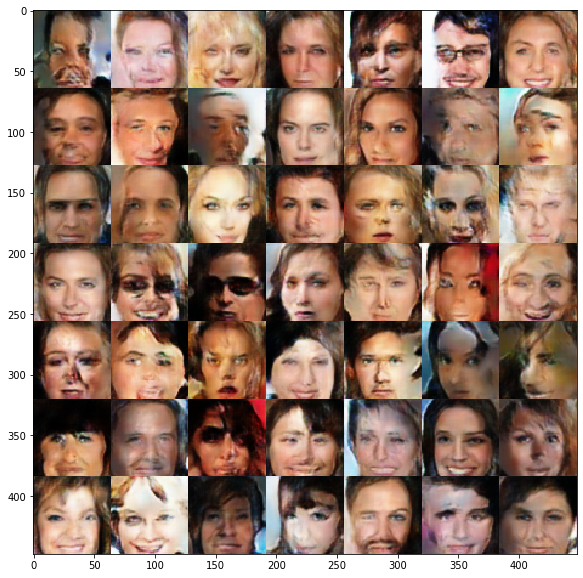

epoch: 11 batch: 0 [D loss: 0.734618] [G loss: 1.011509]
epoch: 11 batch: 1 [D loss: 0.662871] [G loss: 1.022002]
epoch: 11 batch: 2 [D loss: 0.664957] [G loss: 1.035128]
epoch: 11 batch: 3 [D loss: 0.700173] [G loss: 1.039690]
epoch: 11 batch: 4 [D loss: 0.594233] [G loss: 1.093485]
epoch: 11 batch: 5 [D loss: 0.684877] [G loss: 1.064822]
epoch: 11 batch: 6 [D loss: 0.657025] [G loss: 1.028726]
epoch: 11 batch: 7 [D loss: 0.674819] [G loss: 1.005888]
epoch: 11 batch: 8 [D loss: 0.698672] [G loss: 1.053692]
epoch: 11 batch: 9 [D loss: 0.626564] [G loss: 1.054147]
epoch: 11 batch: 10 [D loss: 0.663139] [G loss: 1.045514]
epoch: 11 batch: 11 [D loss: 0.649942] [G loss: 1.025369]
epoch: 11 batch: 12 [D loss: 0.654665] [G loss: 0.997149]
epoch: 11 batch: 13 [D loss: 0.661417] [G loss: 1.031301]
epoch: 11 batch: 14 [D loss: 0.672921] [G loss: 1.044553]
epoch: 11 batch: 15 [D loss: 0.645191] [G loss: 1.013560]
epoch: 11 batch: 16 [D loss: 0.670810] [G loss: 1.012285]
epoch: 11 batch: 17 [D l

epoch: 11 batch: 141 [D loss: 0.645795] [G loss: 1.080326]
epoch: 11 batch: 142 [D loss: 0.635534] [G loss: 0.944581]
epoch: 11 batch: 143 [D loss: 0.669747] [G loss: 0.985004]
epoch: 11 batch: 144 [D loss: 0.671340] [G loss: 1.025482]
epoch: 11 batch: 145 [D loss: 0.652220] [G loss: 1.024405]
epoch: 11 batch: 146 [D loss: 0.660213] [G loss: 0.993053]
epoch: 11 batch: 147 [D loss: 0.659265] [G loss: 1.030329]
epoch: 11 batch: 148 [D loss: 0.720701] [G loss: 1.007807]
epoch: 11 batch: 149 [D loss: 0.629430] [G loss: 0.927444]
epoch: 11 batch: 150 [D loss: 0.662775] [G loss: 1.036522]
epoch: 11 batch: 151 [D loss: 0.662695] [G loss: 0.967313]
epoch: 11 batch: 152 [D loss: 0.698856] [G loss: 1.007612]
epoch: 11 batch: 153 [D loss: 0.673790] [G loss: 1.000945]
epoch: 11 batch: 154 [D loss: 0.651737] [G loss: 1.057105]
epoch: 11 batch: 155 [D loss: 0.652775] [G loss: 1.013268]
epoch: 11 batch: 156 [D loss: 0.677826] [G loss: 0.967490]
epoch: 11 batch: 157 [D loss: 0.691260] [G loss: 1.00951

epoch: 11 batch: 280 [D loss: 0.674614] [G loss: 1.009030]
epoch: 11 batch: 281 [D loss: 0.684388] [G loss: 0.983886]
epoch: 11 batch: 282 [D loss: 0.656398] [G loss: 1.041862]
epoch: 11 batch: 283 [D loss: 0.632477] [G loss: 1.121427]
epoch: 11 batch: 284 [D loss: 0.634221] [G loss: 0.999187]
epoch: 11 batch: 285 [D loss: 0.693438] [G loss: 0.990169]
epoch: 11 batch: 286 [D loss: 0.655083] [G loss: 1.070017]
epoch: 11 batch: 287 [D loss: 0.675411] [G loss: 1.056790]
epoch: 11 batch: 288 [D loss: 0.667493] [G loss: 1.056792]
epoch: 11 batch: 289 [D loss: 0.646407] [G loss: 1.026783]
epoch: 11 batch: 290 [D loss: 0.621471] [G loss: 0.988392]
epoch: 11 batch: 291 [D loss: 0.680327] [G loss: 1.000399]
epoch: 11 batch: 292 [D loss: 0.636041] [G loss: 0.976519]
epoch: 11 batch: 293 [D loss: 0.643983] [G loss: 1.005935]
epoch: 11 batch: 294 [D loss: 0.672791] [G loss: 1.018992]
epoch: 11 batch: 295 [D loss: 0.702936] [G loss: 1.005162]
epoch: 11 batch: 296 [D loss: 0.722990] [G loss: 0.99514

epoch: 11 batch: 419 [D loss: 0.683532] [G loss: 1.059921]
epoch: 11 batch: 420 [D loss: 0.649741] [G loss: 1.019436]
epoch: 11 batch: 421 [D loss: 0.629041] [G loss: 1.018459]
epoch: 11 batch: 422 [D loss: 0.657880] [G loss: 1.014564]
epoch: 11 batch: 423 [D loss: 0.652498] [G loss: 1.032761]
epoch: 11 batch: 424 [D loss: 0.680828] [G loss: 1.054435]
epoch: 11 batch: 425 [D loss: 0.692850] [G loss: 1.013849]
epoch: 11 batch: 426 [D loss: 0.664166] [G loss: 1.001929]
epoch: 11 batch: 427 [D loss: 0.668413] [G loss: 0.935180]
epoch: 11 batch: 428 [D loss: 0.634902] [G loss: 1.023503]
epoch: 11 batch: 429 [D loss: 0.650592] [G loss: 1.014954]
epoch: 11 batch: 430 [D loss: 0.651698] [G loss: 1.031490]
epoch: 11 batch: 431 [D loss: 0.665950] [G loss: 0.937968]
epoch: 11 batch: 432 [D loss: 0.670578] [G loss: 0.975963]
epoch: 11 batch: 433 [D loss: 0.688982] [G loss: 1.005034]
epoch: 11 batch: 434 [D loss: 0.664793] [G loss: 1.075838]
epoch: 11 batch: 435 [D loss: 0.625523] [G loss: 0.98095

epoch: 11 batch: 558 [D loss: 0.642114] [G loss: 0.991356]
epoch: 11 batch: 559 [D loss: 0.647132] [G loss: 1.051233]
epoch: 11 batch: 560 [D loss: 0.661397] [G loss: 1.051654]
epoch: 11 batch: 561 [D loss: 0.682284] [G loss: 0.975852]
epoch: 11 batch: 562 [D loss: 0.640499] [G loss: 1.048825]
epoch: 11 batch: 563 [D loss: 0.661238] [G loss: 1.001019]
epoch: 11 batch: 564 [D loss: 0.644172] [G loss: 1.073176]
epoch: 11 batch: 565 [D loss: 0.662751] [G loss: 1.027432]
epoch: 11 batch: 566 [D loss: 0.672624] [G loss: 1.068626]
epoch: 11 batch: 567 [D loss: 0.658511] [G loss: 0.980867]
epoch: 11 batch: 568 [D loss: 0.688852] [G loss: 0.998997]
epoch: 11 batch: 569 [D loss: 0.667494] [G loss: 1.055648]
epoch: 11 batch: 570 [D loss: 0.649694] [G loss: 1.078969]
epoch: 11 batch: 571 [D loss: 0.651105] [G loss: 1.083526]
epoch: 11 batch: 572 [D loss: 0.686138] [G loss: 1.062245]
epoch: 11 batch: 573 [D loss: 0.629817] [G loss: 0.996549]
epoch: 11 batch: 574 [D loss: 0.683217] [G loss: 1.02130

epoch: 11 batch: 697 [D loss: 0.626007] [G loss: 0.955591]
epoch: 11 batch: 698 [D loss: 0.680143] [G loss: 0.960114]
epoch: 11 batch: 699 [D loss: 0.671112] [G loss: 1.025929]
epoch: 11 batch: 700 [D loss: 0.676130] [G loss: 1.077783]
epoch: 11 batch: 701 [D loss: 0.669649] [G loss: 1.069866]
epoch: 11 batch: 702 [D loss: 0.711793] [G loss: 1.036482]
epoch: 11 batch: 703 [D loss: 0.657059] [G loss: 0.980961]
epoch: 11 batch: 704 [D loss: 0.662391] [G loss: 0.931470]
epoch: 11 batch: 705 [D loss: 0.650244] [G loss: 0.976933]
epoch: 11 batch: 706 [D loss: 0.671225] [G loss: 0.991890]
epoch: 11 batch: 707 [D loss: 0.653932] [G loss: 1.007042]
epoch: 11 batch: 708 [D loss: 0.658270] [G loss: 1.025109]
epoch: 11 batch: 709 [D loss: 0.667559] [G loss: 0.959261]
epoch: 11 batch: 710 [D loss: 0.666691] [G loss: 0.941709]
epoch: 11 batch: 711 [D loss: 0.662189] [G loss: 0.994507]
epoch: 11 batch: 712 [D loss: 0.598932] [G loss: 0.981920]
epoch: 11 batch: 713 [D loss: 0.672771] [G loss: 1.09861

epoch: 11 batch: 836 [D loss: 0.683902] [G loss: 1.027536]
epoch: 11 batch: 837 [D loss: 0.701632] [G loss: 1.074014]
epoch: 11 batch: 838 [D loss: 0.701257] [G loss: 1.036825]
epoch: 11 batch: 839 [D loss: 0.694724] [G loss: 1.055633]
epoch: 11 batch: 840 [D loss: 0.678838] [G loss: 1.080769]
epoch: 11 batch: 841 [D loss: 0.650429] [G loss: 1.056102]
epoch: 11 batch: 842 [D loss: 0.668819] [G loss: 0.993508]
epoch: 11 batch: 843 [D loss: 0.668460] [G loss: 0.963204]
epoch: 11 batch: 844 [D loss: 0.640465] [G loss: 0.985850]
epoch: 11 batch: 845 [D loss: 0.666724] [G loss: 1.020747]
epoch: 11 batch: 846 [D loss: 0.653781] [G loss: 0.966587]
epoch: 11 batch: 847 [D loss: 0.665277] [G loss: 0.995559]
epoch: 11 batch: 848 [D loss: 0.629118] [G loss: 0.996240]
epoch: 11 batch: 849 [D loss: 0.647563] [G loss: 0.991931]
epoch: 11 batch: 850 [D loss: 0.689416] [G loss: 1.030359]
epoch: 11 batch: 851 [D loss: 0.686342] [G loss: 0.986423]
epoch: 11 batch: 852 [D loss: 0.640083] [G loss: 1.04932

epoch: 11 batch: 975 [D loss: 0.657033] [G loss: 0.978092]
epoch: 11 batch: 976 [D loss: 0.620079] [G loss: 1.172893]
epoch: 11 batch: 977 [D loss: 0.713983] [G loss: 0.998446]
epoch: 11 batch: 978 [D loss: 0.617894] [G loss: 1.071994]
epoch: 11 batch: 979 [D loss: 0.634255] [G loss: 1.052417]
epoch: 11 batch: 980 [D loss: 0.688577] [G loss: 1.015615]
epoch: 11 batch: 981 [D loss: 0.649654] [G loss: 0.997361]
epoch: 11 batch: 982 [D loss: 0.663426] [G loss: 1.066691]
epoch: 11 batch: 983 [D loss: 0.674464] [G loss: 0.973453]
epoch: 11 batch: 984 [D loss: 0.660806] [G loss: 1.048266]
epoch: 11 batch: 985 [D loss: 0.639349] [G loss: 1.020156]
epoch: 11 batch: 986 [D loss: 0.683484] [G loss: 1.009944]
epoch: 11 batch: 987 [D loss: 0.661777] [G loss: 1.026027]
epoch: 11 batch: 988 [D loss: 0.670088] [G loss: 0.981555]
epoch: 11 batch: 989 [D loss: 0.672244] [G loss: 1.012138]
epoch: 11 batch: 990 [D loss: 0.661638] [G loss: 1.086941]
epoch: 11 batch: 991 [D loss: 0.702938] [G loss: 1.03606

epoch: 11 batch: 1112 [D loss: 0.664293] [G loss: 1.004833]
epoch: 11 batch: 1113 [D loss: 0.641059] [G loss: 1.036550]
epoch: 11 batch: 1114 [D loss: 0.656567] [G loss: 1.071506]
epoch: 11 batch: 1115 [D loss: 0.675084] [G loss: 0.997025]
epoch: 11 batch: 1116 [D loss: 0.657594] [G loss: 1.026955]
epoch: 11 batch: 1117 [D loss: 0.683341] [G loss: 0.995974]
epoch: 11 batch: 1118 [D loss: 0.663048] [G loss: 1.017750]
epoch: 11 batch: 1119 [D loss: 0.701690] [G loss: 0.993828]
epoch: 11 batch: 1120 [D loss: 0.635837] [G loss: 0.994961]
epoch: 11 batch: 1121 [D loss: 0.666478] [G loss: 1.069625]
epoch: 11 batch: 1122 [D loss: 0.665324] [G loss: 1.057022]
epoch: 11 batch: 1123 [D loss: 0.682321] [G loss: 1.031455]
epoch: 11 batch: 1124 [D loss: 0.635676] [G loss: 1.067301]
epoch: 11 batch: 1125 [D loss: 0.667552] [G loss: 1.024623]
epoch: 11 batch: 1126 [D loss: 0.672446] [G loss: 1.048964]
epoch: 11 batch: 1127 [D loss: 0.675424] [G loss: 0.989901]
epoch: 11 batch: 1128 [D loss: 0.665436]

epoch: 11 batch: 1249 [D loss: 0.659406] [G loss: 1.012240]
epoch: 11 batch: 1250 [D loss: 0.652054] [G loss: 0.996871]
epoch: 11 batch: 1251 [D loss: 0.672976] [G loss: 1.049188]
epoch: 11 batch: 1252 [D loss: 0.683130] [G loss: 0.960059]
epoch: 11 batch: 1253 [D loss: 0.683043] [G loss: 1.032561]
epoch: 11 batch: 1254 [D loss: 0.670665] [G loss: 0.977036]
epoch: 11 batch: 1255 [D loss: 0.654862] [G loss: 1.001822]
epoch: 11 batch: 1256 [D loss: 0.697174] [G loss: 1.032421]
epoch: 11 batch: 1257 [D loss: 0.639230] [G loss: 1.054137]
epoch: 11 batch: 1258 [D loss: 0.688358] [G loss: 0.957670]
epoch: 11 batch: 1259 [D loss: 0.647546] [G loss: 1.000101]
epoch: 11 batch: 1260 [D loss: 0.684799] [G loss: 1.017791]
epoch: 11 batch: 1261 [D loss: 0.687149] [G loss: 1.037264]
epoch: 11 batch: 1262 [D loss: 0.664479] [G loss: 1.001292]
epoch: 11 batch: 1263 [D loss: 0.698544] [G loss: 0.984030]
epoch: 11 batch: 1264 [D loss: 0.625993] [G loss: 1.046147]
epoch: 11 batch: 1265 [D loss: 0.719603]

epoch: 11 batch: 1386 [D loss: 0.720492] [G loss: 1.024321]
epoch: 11 batch: 1387 [D loss: 0.754046] [G loss: 0.974292]
epoch: 11 batch: 1388 [D loss: 0.683664] [G loss: 1.033153]
epoch: 11 batch: 1389 [D loss: 0.659239] [G loss: 1.049120]
epoch: 11 batch: 1390 [D loss: 0.631229] [G loss: 1.051515]
epoch: 11 batch: 1391 [D loss: 0.589521] [G loss: 1.099848]
epoch: 11 batch: 1392 [D loss: 0.645020] [G loss: 1.036453]
epoch: 11 batch: 1393 [D loss: 0.650122] [G loss: 1.010627]
epoch: 11 batch: 1394 [D loss: 0.645037] [G loss: 0.989209]
epoch: 11 batch: 1395 [D loss: 0.647949] [G loss: 1.025715]
epoch: 11 batch: 1396 [D loss: 0.643780] [G loss: 0.967401]
epoch: 11 batch: 1397 [D loss: 0.636245] [G loss: 1.008027]
epoch: 11 batch: 1398 [D loss: 0.672477] [G loss: 0.950236]
epoch: 11 batch: 1399 [D loss: 0.663382] [G loss: 1.002618]
epoch: 11 batch: 1400 [D loss: 0.668650] [G loss: 1.034450]
epoch: 11 batch: 1401 [D loss: 0.681786] [G loss: 0.979013]
epoch: 11 batch: 1402 [D loss: 0.682859]

epoch: 11 batch: 1523 [D loss: 0.665047] [G loss: 1.048474]
epoch: 11 batch: 1524 [D loss: 0.664757] [G loss: 1.032681]
epoch: 11 batch: 1525 [D loss: 0.665758] [G loss: 1.014404]
epoch: 11 batch: 1526 [D loss: 0.698857] [G loss: 0.957965]
epoch: 11 batch: 1527 [D loss: 0.693637] [G loss: 1.021068]
epoch: 11 batch: 1528 [D loss: 0.698265] [G loss: 0.969780]
epoch: 11 batch: 1529 [D loss: 0.603436] [G loss: 0.969859]
epoch: 11 batch: 1530 [D loss: 0.686634] [G loss: 1.012951]
epoch: 11 batch: 1531 [D loss: 0.642864] [G loss: 0.962366]
epoch: 11 batch: 1532 [D loss: 0.668619] [G loss: 1.069607]
epoch: 11 batch: 1533 [D loss: 0.687230] [G loss: 0.995504]
epoch: 11 batch: 1534 [D loss: 0.699598] [G loss: 1.033306]
epoch: 11 batch: 1535 [D loss: 0.697458] [G loss: 1.049905]
epoch: 11 batch: 1536 [D loss: 0.636900] [G loss: 0.953006]
epoch: 11 batch: 1537 [D loss: 0.687155] [G loss: 1.028737]
epoch: 11 batch: 1538 [D loss: 0.682066] [G loss: 0.956394]
epoch: 11 batch: 1539 [D loss: 0.633276]

epoch: 12 batch: 81 [D loss: 0.706429] [G loss: 1.013502]
epoch: 12 batch: 82 [D loss: 0.610966] [G loss: 1.031418]
epoch: 12 batch: 83 [D loss: 0.676171] [G loss: 1.027874]
epoch: 12 batch: 84 [D loss: 0.622158] [G loss: 1.016668]
epoch: 12 batch: 85 [D loss: 0.661013] [G loss: 0.978512]
epoch: 12 batch: 86 [D loss: 0.705831] [G loss: 0.964962]
epoch: 12 batch: 87 [D loss: 0.669908] [G loss: 0.989796]
epoch: 12 batch: 88 [D loss: 0.630258] [G loss: 0.977621]
epoch: 12 batch: 89 [D loss: 0.671576] [G loss: 0.971127]
epoch: 12 batch: 90 [D loss: 0.641579] [G loss: 1.082805]
epoch: 12 batch: 91 [D loss: 0.660456] [G loss: 1.009103]
epoch: 12 batch: 92 [D loss: 0.661800] [G loss: 0.978479]
epoch: 12 batch: 93 [D loss: 0.693334] [G loss: 0.997434]
epoch: 12 batch: 94 [D loss: 0.664272] [G loss: 0.975068]
epoch: 12 batch: 95 [D loss: 0.622251] [G loss: 1.034049]
epoch: 12 batch: 96 [D loss: 0.665283] [G loss: 0.962344]
epoch: 12 batch: 97 [D loss: 0.619064] [G loss: 1.072542]
epoch: 12 batc

epoch: 12 batch: 221 [D loss: 0.659335] [G loss: 0.995536]
epoch: 12 batch: 222 [D loss: 0.642392] [G loss: 1.010688]
epoch: 12 batch: 223 [D loss: 0.682914] [G loss: 1.073660]
epoch: 12 batch: 224 [D loss: 0.678849] [G loss: 1.005427]
epoch: 12 batch: 225 [D loss: 0.671997] [G loss: 0.970222]
epoch: 12 batch: 226 [D loss: 0.695845] [G loss: 1.040689]
epoch: 12 batch: 227 [D loss: 0.679339] [G loss: 1.026227]
epoch: 12 batch: 228 [D loss: 0.705338] [G loss: 0.948685]
epoch: 12 batch: 229 [D loss: 0.696151] [G loss: 0.989688]
epoch: 12 batch: 230 [D loss: 0.688362] [G loss: 0.972479]
epoch: 12 batch: 231 [D loss: 0.611612] [G loss: 1.024577]
epoch: 12 batch: 232 [D loss: 0.666678] [G loss: 1.020116]
epoch: 12 batch: 233 [D loss: 0.693789] [G loss: 0.996506]
epoch: 12 batch: 234 [D loss: 0.637629] [G loss: 1.058018]
epoch: 12 batch: 235 [D loss: 0.649148] [G loss: 1.017699]
epoch: 12 batch: 236 [D loss: 0.666275] [G loss: 1.019875]
epoch: 12 batch: 237 [D loss: 0.676727] [G loss: 1.02880

epoch: 12 batch: 360 [D loss: 0.674818] [G loss: 0.983654]
epoch: 12 batch: 361 [D loss: 0.691732] [G loss: 1.047110]
epoch: 12 batch: 362 [D loss: 0.630457] [G loss: 1.015204]
epoch: 12 batch: 363 [D loss: 0.671876] [G loss: 1.029974]
epoch: 12 batch: 364 [D loss: 0.640739] [G loss: 1.045933]
epoch: 12 batch: 365 [D loss: 0.652675] [G loss: 1.039553]
epoch: 12 batch: 366 [D loss: 0.649861] [G loss: 1.011476]
epoch: 12 batch: 367 [D loss: 0.643661] [G loss: 0.975839]
epoch: 12 batch: 368 [D loss: 0.661653] [G loss: 1.035225]
epoch: 12 batch: 369 [D loss: 0.643241] [G loss: 1.015649]
epoch: 12 batch: 370 [D loss: 0.697227] [G loss: 1.039547]
epoch: 12 batch: 371 [D loss: 0.661931] [G loss: 1.001049]
epoch: 12 batch: 372 [D loss: 0.653862] [G loss: 1.072080]
epoch: 12 batch: 373 [D loss: 0.633460] [G loss: 1.048073]
epoch: 12 batch: 374 [D loss: 0.672392] [G loss: 1.015552]
epoch: 12 batch: 375 [D loss: 0.703398] [G loss: 0.964126]
epoch: 12 batch: 376 [D loss: 0.691085] [G loss: 1.02159

epoch: 12 batch: 499 [D loss: 0.678252] [G loss: 1.116010]
epoch: 12 batch: 500 [D loss: 0.660031] [G loss: 1.031704]
epoch: 12 batch: 501 [D loss: 0.694971] [G loss: 1.055852]
epoch: 12 batch: 502 [D loss: 0.637193] [G loss: 1.041120]
epoch: 12 batch: 503 [D loss: 0.639746] [G loss: 1.036595]
epoch: 12 batch: 504 [D loss: 0.638224] [G loss: 0.992311]
epoch: 12 batch: 505 [D loss: 0.668107] [G loss: 1.004664]
epoch: 12 batch: 506 [D loss: 0.702547] [G loss: 1.009471]
epoch: 12 batch: 507 [D loss: 0.646204] [G loss: 1.015102]
epoch: 12 batch: 508 [D loss: 0.669555] [G loss: 1.039630]
epoch: 12 batch: 509 [D loss: 0.672101] [G loss: 0.996529]
epoch: 12 batch: 510 [D loss: 0.654050] [G loss: 0.972642]
epoch: 12 batch: 511 [D loss: 0.627515] [G loss: 1.129106]
epoch: 12 batch: 512 [D loss: 0.617668] [G loss: 0.979598]
epoch: 12 batch: 513 [D loss: 0.640492] [G loss: 1.043853]
epoch: 12 batch: 514 [D loss: 0.643623] [G loss: 1.085808]
epoch: 12 batch: 515 [D loss: 0.672900] [G loss: 0.96276

epoch: 12 batch: 638 [D loss: 0.669926] [G loss: 1.121070]
epoch: 12 batch: 639 [D loss: 0.673120] [G loss: 1.048400]
epoch: 12 batch: 640 [D loss: 0.645364] [G loss: 1.003096]
epoch: 12 batch: 641 [D loss: 0.640152] [G loss: 0.994719]
epoch: 12 batch: 642 [D loss: 0.661749] [G loss: 1.039219]
epoch: 12 batch: 643 [D loss: 0.666167] [G loss: 0.917247]
epoch: 12 batch: 644 [D loss: 0.659926] [G loss: 1.060580]
epoch: 12 batch: 645 [D loss: 0.677986] [G loss: 0.931685]
epoch: 12 batch: 646 [D loss: 0.685784] [G loss: 0.961401]
epoch: 12 batch: 647 [D loss: 0.666887] [G loss: 1.008469]
epoch: 12 batch: 648 [D loss: 0.657616] [G loss: 1.040923]
epoch: 12 batch: 649 [D loss: 0.688006] [G loss: 0.947393]
epoch: 12 batch: 650 [D loss: 0.651793] [G loss: 0.933695]
epoch: 12 batch: 651 [D loss: 0.652650] [G loss: 0.975921]
epoch: 12 batch: 652 [D loss: 0.700341] [G loss: 1.039989]
epoch: 12 batch: 653 [D loss: 0.689562] [G loss: 0.957362]
epoch: 12 batch: 654 [D loss: 0.651525] [G loss: 0.95484

epoch: 12 batch: 777 [D loss: 0.651128] [G loss: 0.995272]
epoch: 12 batch: 778 [D loss: 0.699136] [G loss: 0.938951]
epoch: 12 batch: 779 [D loss: 0.651133] [G loss: 1.022038]
epoch: 12 batch: 780 [D loss: 0.680530] [G loss: 0.957017]
epoch: 12 batch: 781 [D loss: 0.640332] [G loss: 1.062206]
epoch: 12 batch: 782 [D loss: 0.668301] [G loss: 0.978374]
epoch: 12 batch: 783 [D loss: 0.664330] [G loss: 1.008304]
epoch: 12 batch: 784 [D loss: 0.645309] [G loss: 1.005339]
epoch: 12 batch: 785 [D loss: 0.688032] [G loss: 0.974666]
epoch: 12 batch: 786 [D loss: 0.694613] [G loss: 0.984751]
epoch: 12 batch: 787 [D loss: 0.672172] [G loss: 1.029773]
epoch: 12 batch: 788 [D loss: 0.657836] [G loss: 0.967521]
epoch: 12 batch: 789 [D loss: 0.653805] [G loss: 0.983309]
epoch: 12 batch: 790 [D loss: 0.657773] [G loss: 1.027309]
epoch: 12 batch: 791 [D loss: 0.667925] [G loss: 1.007905]
epoch: 12 batch: 792 [D loss: 0.681871] [G loss: 1.050031]
epoch: 12 batch: 793 [D loss: 0.681481] [G loss: 1.04675

epoch: 12 batch: 916 [D loss: 0.679364] [G loss: 1.042768]
epoch: 12 batch: 917 [D loss: 0.674897] [G loss: 1.047783]
epoch: 12 batch: 918 [D loss: 0.697070] [G loss: 1.010831]
epoch: 12 batch: 919 [D loss: 0.690626] [G loss: 1.047923]
epoch: 12 batch: 920 [D loss: 0.622372] [G loss: 0.917554]
epoch: 12 batch: 921 [D loss: 0.626748] [G loss: 0.935092]
epoch: 12 batch: 922 [D loss: 0.654051] [G loss: 0.939978]
epoch: 12 batch: 923 [D loss: 0.666772] [G loss: 1.008749]
epoch: 12 batch: 924 [D loss: 0.672991] [G loss: 1.060997]
epoch: 12 batch: 925 [D loss: 0.654885] [G loss: 1.002696]
epoch: 12 batch: 926 [D loss: 0.680765] [G loss: 1.023143]
epoch: 12 batch: 927 [D loss: 0.634673] [G loss: 1.021948]
epoch: 12 batch: 928 [D loss: 0.666875] [G loss: 1.059691]
epoch: 12 batch: 929 [D loss: 0.681215] [G loss: 1.077539]
epoch: 12 batch: 930 [D loss: 0.665636] [G loss: 1.051319]
epoch: 12 batch: 931 [D loss: 0.671951] [G loss: 0.934574]
epoch: 12 batch: 932 [D loss: 0.659669] [G loss: 0.99034

epoch: 12 batch: 1054 [D loss: 0.670487] [G loss: 1.042332]
epoch: 12 batch: 1055 [D loss: 0.681314] [G loss: 1.020738]
epoch: 12 batch: 1056 [D loss: 0.677169] [G loss: 1.031199]
epoch: 12 batch: 1057 [D loss: 0.618013] [G loss: 1.045019]
epoch: 12 batch: 1058 [D loss: 0.693470] [G loss: 1.033670]
epoch: 12 batch: 1059 [D loss: 0.631072] [G loss: 0.990196]
epoch: 12 batch: 1060 [D loss: 0.633459] [G loss: 1.015610]
epoch: 12 batch: 1061 [D loss: 0.681243] [G loss: 1.015259]
epoch: 12 batch: 1062 [D loss: 0.663047] [G loss: 1.011958]
epoch: 12 batch: 1063 [D loss: 0.651175] [G loss: 1.063945]
epoch: 12 batch: 1064 [D loss: 0.674721] [G loss: 0.921721]
epoch: 12 batch: 1065 [D loss: 0.667370] [G loss: 0.949677]
epoch: 12 batch: 1066 [D loss: 0.667071] [G loss: 0.968420]
epoch: 12 batch: 1067 [D loss: 0.682681] [G loss: 1.006285]
epoch: 12 batch: 1068 [D loss: 0.636298] [G loss: 1.006609]
epoch: 12 batch: 1069 [D loss: 0.654062] [G loss: 1.022924]
epoch: 12 batch: 1070 [D loss: 0.668027]

epoch: 12 batch: 1191 [D loss: 0.639432] [G loss: 1.049001]
epoch: 12 batch: 1192 [D loss: 0.645946] [G loss: 1.050073]
epoch: 12 batch: 1193 [D loss: 0.687893] [G loss: 0.985210]
epoch: 12 batch: 1194 [D loss: 0.669342] [G loss: 0.950946]
epoch: 12 batch: 1195 [D loss: 0.690496] [G loss: 1.002132]
epoch: 12 batch: 1196 [D loss: 0.676390] [G loss: 0.964954]
epoch: 12 batch: 1197 [D loss: 0.697409] [G loss: 1.050053]
epoch: 12 batch: 1198 [D loss: 0.684601] [G loss: 0.984860]
epoch: 12 batch: 1199 [D loss: 0.664230] [G loss: 0.967750]
epoch: 12 batch: 1200 [D loss: 0.684408] [G loss: 1.042223]
epoch: 12 batch: 1201 [D loss: 0.671999] [G loss: 0.985729]
epoch: 12 batch: 1202 [D loss: 0.694280] [G loss: 0.923756]
epoch: 12 batch: 1203 [D loss: 0.678789] [G loss: 0.937485]
epoch: 12 batch: 1204 [D loss: 0.664682] [G loss: 1.091717]
epoch: 12 batch: 1205 [D loss: 0.685801] [G loss: 1.072236]
epoch: 12 batch: 1206 [D loss: 0.690802] [G loss: 0.986338]
epoch: 12 batch: 1207 [D loss: 0.635963]

epoch: 12 batch: 1328 [D loss: 0.697351] [G loss: 0.991143]
epoch: 12 batch: 1329 [D loss: 0.650340] [G loss: 1.016834]
epoch: 12 batch: 1330 [D loss: 0.673497] [G loss: 0.981141]
epoch: 12 batch: 1331 [D loss: 0.647626] [G loss: 1.050706]
epoch: 12 batch: 1332 [D loss: 0.612190] [G loss: 0.997044]
epoch: 12 batch: 1333 [D loss: 0.639549] [G loss: 1.065220]
epoch: 12 batch: 1334 [D loss: 0.711897] [G loss: 1.021582]
epoch: 12 batch: 1335 [D loss: 0.619114] [G loss: 1.001504]
epoch: 12 batch: 1336 [D loss: 0.629936] [G loss: 0.994828]
epoch: 12 batch: 1337 [D loss: 0.655145] [G loss: 0.980997]
epoch: 12 batch: 1338 [D loss: 0.644782] [G loss: 0.993482]
epoch: 12 batch: 1339 [D loss: 0.633055] [G loss: 1.025645]
epoch: 12 batch: 1340 [D loss: 0.616881] [G loss: 1.049096]
epoch: 12 batch: 1341 [D loss: 0.699390] [G loss: 0.958243]
epoch: 12 batch: 1342 [D loss: 0.700919] [G loss: 1.025404]
epoch: 12 batch: 1343 [D loss: 0.645736] [G loss: 0.879947]
epoch: 12 batch: 1344 [D loss: 0.690462]

epoch: 12 batch: 1465 [D loss: 0.661117] [G loss: 0.984311]
epoch: 12 batch: 1466 [D loss: 0.663455] [G loss: 0.970150]
epoch: 12 batch: 1467 [D loss: 0.670461] [G loss: 1.024612]
epoch: 12 batch: 1468 [D loss: 0.672378] [G loss: 1.010589]
epoch: 12 batch: 1469 [D loss: 0.666263] [G loss: 1.051692]
epoch: 12 batch: 1470 [D loss: 0.676164] [G loss: 1.012098]
epoch: 12 batch: 1471 [D loss: 0.706415] [G loss: 0.911050]
epoch: 12 batch: 1472 [D loss: 0.617255] [G loss: 1.007920]
epoch: 12 batch: 1473 [D loss: 0.673047] [G loss: 0.991232]
epoch: 12 batch: 1474 [D loss: 0.672118] [G loss: 1.092536]
epoch: 12 batch: 1475 [D loss: 0.628397] [G loss: 1.047636]
epoch: 12 batch: 1476 [D loss: 0.687061] [G loss: 1.046601]
epoch: 12 batch: 1477 [D loss: 0.665743] [G loss: 1.149440]
epoch: 12 batch: 1478 [D loss: 0.673503] [G loss: 0.986039]
epoch: 12 batch: 1479 [D loss: 0.673411] [G loss: 0.983274]
epoch: 12 batch: 1480 [D loss: 0.669568] [G loss: 1.031737]
epoch: 12 batch: 1481 [D loss: 0.657706]

epoch: 13 batch: 21 [D loss: 0.663555] [G loss: 0.971958]
epoch: 13 batch: 22 [D loss: 0.641961] [G loss: 1.099962]
epoch: 13 batch: 23 [D loss: 0.667629] [G loss: 0.985331]
epoch: 13 batch: 24 [D loss: 0.694326] [G loss: 0.897807]
epoch: 13 batch: 25 [D loss: 0.663139] [G loss: 1.035059]
epoch: 13 batch: 26 [D loss: 0.639970] [G loss: 0.988393]
epoch: 13 batch: 27 [D loss: 0.657763] [G loss: 0.983219]
epoch: 13 batch: 28 [D loss: 0.663993] [G loss: 1.000380]
epoch: 13 batch: 29 [D loss: 0.684659] [G loss: 0.978889]
epoch: 13 batch: 30 [D loss: 0.655252] [G loss: 0.964950]
epoch: 13 batch: 31 [D loss: 0.667978] [G loss: 1.034173]
epoch: 13 batch: 32 [D loss: 0.644024] [G loss: 1.071467]
epoch: 13 batch: 33 [D loss: 0.664863] [G loss: 0.963800]
epoch: 13 batch: 34 [D loss: 0.651835] [G loss: 1.061505]
epoch: 13 batch: 35 [D loss: 0.671144] [G loss: 1.085961]
epoch: 13 batch: 36 [D loss: 0.655565] [G loss: 0.958288]
epoch: 13 batch: 37 [D loss: 0.657412] [G loss: 1.061668]
epoch: 13 batc

epoch: 13 batch: 162 [D loss: 0.630217] [G loss: 1.036133]
epoch: 13 batch: 163 [D loss: 0.657148] [G loss: 1.036637]
epoch: 13 batch: 164 [D loss: 0.642395] [G loss: 0.982272]
epoch: 13 batch: 165 [D loss: 0.642775] [G loss: 1.009384]
epoch: 13 batch: 166 [D loss: 0.681904] [G loss: 0.978732]
epoch: 13 batch: 167 [D loss: 0.655090] [G loss: 1.007254]
epoch: 13 batch: 168 [D loss: 0.676925] [G loss: 0.997897]
epoch: 13 batch: 169 [D loss: 0.659758] [G loss: 0.999505]
epoch: 13 batch: 170 [D loss: 0.681020] [G loss: 1.038968]
epoch: 13 batch: 171 [D loss: 0.680656] [G loss: 1.032924]
epoch: 13 batch: 172 [D loss: 0.636506] [G loss: 0.972644]
epoch: 13 batch: 173 [D loss: 0.653122] [G loss: 0.954499]
epoch: 13 batch: 174 [D loss: 0.679520] [G loss: 1.011215]
epoch: 13 batch: 175 [D loss: 0.724002] [G loss: 1.002574]
epoch: 13 batch: 176 [D loss: 0.678598] [G loss: 0.951881]
epoch: 13 batch: 177 [D loss: 0.723781] [G loss: 1.012058]
epoch: 13 batch: 178 [D loss: 0.661352] [G loss: 1.06643

epoch: 13 batch: 301 [D loss: 0.658907] [G loss: 1.024319]
epoch: 13 batch: 302 [D loss: 0.628873] [G loss: 1.063848]
epoch: 13 batch: 303 [D loss: 0.671919] [G loss: 1.031308]
epoch: 13 batch: 304 [D loss: 0.676658] [G loss: 1.044611]
epoch: 13 batch: 305 [D loss: 0.692193] [G loss: 1.023214]
epoch: 13 batch: 306 [D loss: 0.670125] [G loss: 0.994665]
epoch: 13 batch: 307 [D loss: 0.634206] [G loss: 1.041839]
epoch: 13 batch: 308 [D loss: 0.671560] [G loss: 1.059459]
epoch: 13 batch: 309 [D loss: 0.647405] [G loss: 1.028089]
epoch: 13 batch: 310 [D loss: 0.671154] [G loss: 0.983028]
epoch: 13 batch: 311 [D loss: 0.660711] [G loss: 0.953472]
epoch: 13 batch: 312 [D loss: 0.653302] [G loss: 1.008416]
epoch: 13 batch: 313 [D loss: 0.694607] [G loss: 0.982923]
epoch: 13 batch: 314 [D loss: 0.644182] [G loss: 1.014362]
epoch: 13 batch: 315 [D loss: 0.629724] [G loss: 0.983832]
epoch: 13 batch: 316 [D loss: 0.661331] [G loss: 0.974719]
epoch: 13 batch: 317 [D loss: 0.629119] [G loss: 1.07158

epoch: 13 batch: 440 [D loss: 0.653642] [G loss: 1.037068]
epoch: 13 batch: 441 [D loss: 0.647789] [G loss: 1.063079]
epoch: 13 batch: 442 [D loss: 0.687488] [G loss: 0.996986]
epoch: 13 batch: 443 [D loss: 0.660074] [G loss: 1.038449]
epoch: 13 batch: 444 [D loss: 0.647314] [G loss: 1.000368]
epoch: 13 batch: 445 [D loss: 0.680148] [G loss: 0.983132]
epoch: 13 batch: 446 [D loss: 0.652124] [G loss: 1.060285]
epoch: 13 batch: 447 [D loss: 0.664759] [G loss: 1.044238]
epoch: 13 batch: 448 [D loss: 0.685009] [G loss: 0.954611]
epoch: 13 batch: 449 [D loss: 0.697077] [G loss: 1.001201]
epoch: 13 batch: 450 [D loss: 0.633320] [G loss: 0.986545]
epoch: 13 batch: 451 [D loss: 0.632103] [G loss: 0.994092]
epoch: 13 batch: 452 [D loss: 0.723211] [G loss: 1.017658]
epoch: 13 batch: 453 [D loss: 0.671574] [G loss: 1.012260]
epoch: 13 batch: 454 [D loss: 0.653493] [G loss: 0.974386]
epoch: 13 batch: 455 [D loss: 0.651563] [G loss: 0.994979]
epoch: 13 batch: 456 [D loss: 0.661085] [G loss: 1.05834

epoch: 13 batch: 579 [D loss: 0.672662] [G loss: 0.954111]
epoch: 13 batch: 580 [D loss: 0.661735] [G loss: 0.973964]
epoch: 13 batch: 581 [D loss: 0.679798] [G loss: 0.949846]
epoch: 13 batch: 582 [D loss: 0.649958] [G loss: 1.023190]
epoch: 13 batch: 583 [D loss: 0.646089] [G loss: 0.997689]
epoch: 13 batch: 584 [D loss: 0.677718] [G loss: 0.998805]
epoch: 13 batch: 585 [D loss: 0.635439] [G loss: 1.062495]
epoch: 13 batch: 586 [D loss: 0.620992] [G loss: 0.992401]
epoch: 13 batch: 587 [D loss: 0.653277] [G loss: 1.015996]
epoch: 13 batch: 588 [D loss: 0.655831] [G loss: 0.998621]
epoch: 13 batch: 589 [D loss: 0.671978] [G loss: 0.997815]
epoch: 13 batch: 590 [D loss: 0.691391] [G loss: 0.988017]
epoch: 13 batch: 591 [D loss: 0.640949] [G loss: 1.037026]
epoch: 13 batch: 592 [D loss: 0.671375] [G loss: 0.980582]
epoch: 13 batch: 593 [D loss: 0.638907] [G loss: 1.036553]
epoch: 13 batch: 594 [D loss: 0.686012] [G loss: 0.990249]
epoch: 13 batch: 595 [D loss: 0.691216] [G loss: 1.02023

epoch: 13 batch: 718 [D loss: 0.688445] [G loss: 0.978198]
epoch: 13 batch: 719 [D loss: 0.697739] [G loss: 0.956752]
epoch: 13 batch: 720 [D loss: 0.644748] [G loss: 1.045844]
epoch: 13 batch: 721 [D loss: 0.704545] [G loss: 1.007947]
epoch: 13 batch: 722 [D loss: 0.678620] [G loss: 0.983034]
epoch: 13 batch: 723 [D loss: 0.665222] [G loss: 1.041599]
epoch: 13 batch: 724 [D loss: 0.661434] [G loss: 0.973673]
epoch: 13 batch: 725 [D loss: 0.662418] [G loss: 1.051863]
epoch: 13 batch: 726 [D loss: 0.649492] [G loss: 0.998053]
epoch: 13 batch: 727 [D loss: 0.663514] [G loss: 1.022261]
epoch: 13 batch: 728 [D loss: 0.671579] [G loss: 1.027998]
epoch: 13 batch: 729 [D loss: 0.704561] [G loss: 1.007358]
epoch: 13 batch: 730 [D loss: 0.664513] [G loss: 0.983644]
epoch: 13 batch: 731 [D loss: 0.663421] [G loss: 1.048432]
epoch: 13 batch: 732 [D loss: 0.669705] [G loss: 1.012214]
epoch: 13 batch: 733 [D loss: 0.636367] [G loss: 1.044122]
epoch: 13 batch: 734 [D loss: 0.671159] [G loss: 1.01785

epoch: 13 batch: 857 [D loss: 0.685665] [G loss: 0.997819]
epoch: 13 batch: 858 [D loss: 0.626554] [G loss: 1.035291]
epoch: 13 batch: 859 [D loss: 0.633506] [G loss: 1.085197]
epoch: 13 batch: 860 [D loss: 0.653864] [G loss: 1.101931]
epoch: 13 batch: 861 [D loss: 0.702627] [G loss: 0.890047]
epoch: 13 batch: 862 [D loss: 0.667873] [G loss: 0.953028]
epoch: 13 batch: 863 [D loss: 0.686032] [G loss: 1.025210]
epoch: 13 batch: 864 [D loss: 0.646203] [G loss: 1.099353]
epoch: 13 batch: 865 [D loss: 0.643283] [G loss: 1.059657]
epoch: 13 batch: 866 [D loss: 0.684682] [G loss: 1.100598]
epoch: 13 batch: 867 [D loss: 0.696897] [G loss: 0.986025]
epoch: 13 batch: 868 [D loss: 0.650136] [G loss: 1.003649]
epoch: 13 batch: 869 [D loss: 0.703442] [G loss: 0.952994]
epoch: 13 batch: 870 [D loss: 0.690362] [G loss: 1.000113]
epoch: 13 batch: 871 [D loss: 0.706671] [G loss: 1.064378]
epoch: 13 batch: 872 [D loss: 0.687763] [G loss: 1.013046]
epoch: 13 batch: 873 [D loss: 0.662986] [G loss: 1.01091

epoch: 13 batch: 996 [D loss: 0.670481] [G loss: 0.909563]
epoch: 13 batch: 997 [D loss: 0.615071] [G loss: 1.018546]
epoch: 13 batch: 998 [D loss: 0.746969] [G loss: 1.038624]
epoch: 13 batch: 999 [D loss: 0.664282] [G loss: 1.038157]
epoch: 13 batch: 1000 [D loss: 0.650034] [G loss: 1.024830]
epoch: 13 batch: 1001 [D loss: 0.676730] [G loss: 1.065186]
epoch: 13 batch: 1002 [D loss: 0.654906] [G loss: 1.058180]
epoch: 13 batch: 1003 [D loss: 0.643184] [G loss: 1.047427]
epoch: 13 batch: 1004 [D loss: 0.702089] [G loss: 1.068402]
epoch: 13 batch: 1005 [D loss: 0.658926] [G loss: 1.065509]
epoch: 13 batch: 1006 [D loss: 0.637878] [G loss: 0.949711]
epoch: 13 batch: 1007 [D loss: 0.657211] [G loss: 1.044804]
epoch: 13 batch: 1008 [D loss: 0.703084] [G loss: 0.953466]
epoch: 13 batch: 1009 [D loss: 0.672297] [G loss: 0.978691]
epoch: 13 batch: 1010 [D loss: 0.618243] [G loss: 1.042302]
epoch: 13 batch: 1011 [D loss: 0.678435] [G loss: 0.940096]
epoch: 13 batch: 1012 [D loss: 0.672990] [G 

epoch: 13 batch: 1133 [D loss: 0.668365] [G loss: 0.993726]
epoch: 13 batch: 1134 [D loss: 0.663261] [G loss: 1.010866]
epoch: 13 batch: 1135 [D loss: 0.678412] [G loss: 1.003616]
epoch: 13 batch: 1136 [D loss: 0.681668] [G loss: 0.941166]
epoch: 13 batch: 1137 [D loss: 0.655715] [G loss: 1.004073]
epoch: 13 batch: 1138 [D loss: 0.663828] [G loss: 0.976182]
epoch: 13 batch: 1139 [D loss: 0.644750] [G loss: 1.063626]
epoch: 13 batch: 1140 [D loss: 0.656703] [G loss: 1.006069]
epoch: 13 batch: 1141 [D loss: 0.625270] [G loss: 0.965898]
epoch: 13 batch: 1142 [D loss: 0.706266] [G loss: 1.044324]
epoch: 13 batch: 1143 [D loss: 0.702375] [G loss: 1.011862]
epoch: 13 batch: 1144 [D loss: 0.661322] [G loss: 0.977773]
epoch: 13 batch: 1145 [D loss: 0.691506] [G loss: 1.022927]
epoch: 13 batch: 1146 [D loss: 0.660016] [G loss: 0.969720]
epoch: 13 batch: 1147 [D loss: 0.664886] [G loss: 1.101501]
epoch: 13 batch: 1148 [D loss: 0.646011] [G loss: 1.031945]
epoch: 13 batch: 1149 [D loss: 0.685912]

epoch: 13 batch: 1270 [D loss: 0.691709] [G loss: 1.033587]
epoch: 13 batch: 1271 [D loss: 0.690637] [G loss: 1.014233]
epoch: 13 batch: 1272 [D loss: 0.663875] [G loss: 0.947735]
epoch: 13 batch: 1273 [D loss: 0.680992] [G loss: 0.998171]
epoch: 13 batch: 1274 [D loss: 0.657213] [G loss: 1.049216]
epoch: 13 batch: 1275 [D loss: 0.684939] [G loss: 0.985101]
epoch: 13 batch: 1276 [D loss: 0.692318] [G loss: 0.985373]
epoch: 13 batch: 1277 [D loss: 0.645982] [G loss: 1.003551]
epoch: 13 batch: 1278 [D loss: 0.683306] [G loss: 0.987389]
epoch: 13 batch: 1279 [D loss: 0.686791] [G loss: 1.004230]
epoch: 13 batch: 1280 [D loss: 0.675115] [G loss: 1.062857]
epoch: 13 batch: 1281 [D loss: 0.703135] [G loss: 1.005580]
epoch: 13 batch: 1282 [D loss: 0.728821] [G loss: 1.006130]
epoch: 13 batch: 1283 [D loss: 0.677630] [G loss: 1.043158]
epoch: 13 batch: 1284 [D loss: 0.661339] [G loss: 1.002796]
epoch: 13 batch: 1285 [D loss: 0.673881] [G loss: 0.969404]
epoch: 13 batch: 1286 [D loss: 0.625112]

epoch: 13 batch: 1407 [D loss: 0.660716] [G loss: 1.063706]
epoch: 13 batch: 1408 [D loss: 0.642279] [G loss: 1.071592]
epoch: 13 batch: 1409 [D loss: 0.624489] [G loss: 0.998824]
epoch: 13 batch: 1410 [D loss: 0.679017] [G loss: 1.012513]
epoch: 13 batch: 1411 [D loss: 0.659309] [G loss: 0.966009]
epoch: 13 batch: 1412 [D loss: 0.670470] [G loss: 1.038079]
epoch: 13 batch: 1413 [D loss: 0.649238] [G loss: 0.996346]
epoch: 13 batch: 1414 [D loss: 0.638792] [G loss: 1.014764]
epoch: 13 batch: 1415 [D loss: 0.662022] [G loss: 0.988786]
epoch: 13 batch: 1416 [D loss: 0.661767] [G loss: 1.035756]
epoch: 13 batch: 1417 [D loss: 0.639750] [G loss: 1.022944]
epoch: 13 batch: 1418 [D loss: 0.658979] [G loss: 1.007075]
epoch: 13 batch: 1419 [D loss: 0.681722] [G loss: 1.069388]
epoch: 13 batch: 1420 [D loss: 0.645098] [G loss: 0.999429]
epoch: 13 batch: 1421 [D loss: 0.678562] [G loss: 0.995025]
epoch: 13 batch: 1422 [D loss: 0.681001] [G loss: 1.050525]
epoch: 13 batch: 1423 [D loss: 0.648063]

epoch: 13 batch: 1544 [D loss: 0.645160] [G loss: 1.052840]
epoch: 13 batch: 1545 [D loss: 0.634941] [G loss: 0.981163]
epoch: 13 batch: 1546 [D loss: 0.658942] [G loss: 0.991101]
epoch: 13 batch: 1547 [D loss: 0.640382] [G loss: 1.031645]
epoch: 13 batch: 1548 [D loss: 0.665884] [G loss: 0.984529]
epoch: 13 batch: 1549 [D loss: 0.636545] [G loss: 1.035656]
epoch: 13 batch: 1550 [D loss: 0.651419] [G loss: 0.994508]
epoch: 13 batch: 1551 [D loss: 0.638670] [G loss: 1.013415]
epoch: 13 batch: 1552 [D loss: 0.671725] [G loss: 0.989640]
epoch: 13 batch: 1553 [D loss: 0.637405] [G loss: 1.017342]
epoch: 13 batch: 1554 [D loss: 0.690846] [G loss: 0.964616]
epoch: 13 batch: 1555 [D loss: 0.698799] [G loss: 0.921154]
epoch: 13 batch: 1556 [D loss: 0.653190] [G loss: 1.020393]
epoch: 13 batch: 1557 [D loss: 0.663263] [G loss: 1.010330]
epoch: 13 batch: 1558 [D loss: 0.713804] [G loss: 0.946259]
epoch: 13 batch: 1559 [D loss: 0.658744] [G loss: 0.976622]
epoch: 13 batch: 1560 [D loss: 0.671080]

epoch: 14 batch: 103 [D loss: 0.663515] [G loss: 0.980703]
epoch: 14 batch: 104 [D loss: 0.676696] [G loss: 0.941437]
epoch: 14 batch: 105 [D loss: 0.653928] [G loss: 1.025508]
epoch: 14 batch: 106 [D loss: 0.689340] [G loss: 0.968692]
epoch: 14 batch: 107 [D loss: 0.684260] [G loss: 1.006061]
epoch: 14 batch: 108 [D loss: 0.651755] [G loss: 1.094806]
epoch: 14 batch: 109 [D loss: 0.669541] [G loss: 1.000428]
epoch: 14 batch: 110 [D loss: 0.715430] [G loss: 0.999602]
epoch: 14 batch: 111 [D loss: 0.644504] [G loss: 1.015136]
epoch: 14 batch: 112 [D loss: 0.680133] [G loss: 0.938820]
epoch: 14 batch: 113 [D loss: 0.676137] [G loss: 1.010101]
epoch: 14 batch: 114 [D loss: 0.679395] [G loss: 0.949968]
epoch: 14 batch: 115 [D loss: 0.650977] [G loss: 1.079257]
epoch: 14 batch: 116 [D loss: 0.683079] [G loss: 0.949674]
epoch: 14 batch: 117 [D loss: 0.621730] [G loss: 1.064715]
epoch: 14 batch: 118 [D loss: 0.658542] [G loss: 0.963833]
epoch: 14 batch: 119 [D loss: 0.637422] [G loss: 1.02987

epoch: 14 batch: 242 [D loss: 0.652664] [G loss: 1.040185]
epoch: 14 batch: 243 [D loss: 0.671340] [G loss: 0.963140]
epoch: 14 batch: 244 [D loss: 0.660780] [G loss: 0.958398]
epoch: 14 batch: 245 [D loss: 0.642327] [G loss: 1.044820]
epoch: 14 batch: 246 [D loss: 0.652554] [G loss: 1.051442]
epoch: 14 batch: 247 [D loss: 0.634031] [G loss: 0.975312]
epoch: 14 batch: 248 [D loss: 0.659621] [G loss: 0.990773]
epoch: 14 batch: 249 [D loss: 0.694429] [G loss: 0.983688]
epoch: 14 batch: 250 [D loss: 0.692347] [G loss: 1.035995]
epoch: 14 batch: 251 [D loss: 0.662899] [G loss: 1.008826]
epoch: 14 batch: 252 [D loss: 0.675642] [G loss: 1.051860]
epoch: 14 batch: 253 [D loss: 0.660029] [G loss: 1.032626]
epoch: 14 batch: 254 [D loss: 0.705477] [G loss: 0.961797]
epoch: 14 batch: 255 [D loss: 0.682240] [G loss: 1.021624]
epoch: 14 batch: 256 [D loss: 0.668863] [G loss: 1.030714]
epoch: 14 batch: 257 [D loss: 0.688382] [G loss: 0.914174]
epoch: 14 batch: 258 [D loss: 0.692665] [G loss: 1.05809

epoch: 14 batch: 381 [D loss: 0.657797] [G loss: 1.072777]
epoch: 14 batch: 382 [D loss: 0.682101] [G loss: 0.941178]
epoch: 14 batch: 383 [D loss: 0.662660] [G loss: 1.014189]
epoch: 14 batch: 384 [D loss: 0.653004] [G loss: 0.990646]
epoch: 14 batch: 385 [D loss: 0.659449] [G loss: 1.051748]
epoch: 14 batch: 386 [D loss: 0.663472] [G loss: 0.960469]
epoch: 14 batch: 387 [D loss: 0.663198] [G loss: 0.955720]
epoch: 14 batch: 388 [D loss: 0.684633] [G loss: 1.052360]
epoch: 14 batch: 389 [D loss: 0.638264] [G loss: 0.998577]
epoch: 14 batch: 390 [D loss: 0.680295] [G loss: 0.871536]
epoch: 14 batch: 391 [D loss: 0.688636] [G loss: 1.008335]
epoch: 14 batch: 392 [D loss: 0.648611] [G loss: 1.011978]
epoch: 14 batch: 393 [D loss: 0.646385] [G loss: 1.035526]
epoch: 14 batch: 394 [D loss: 0.648279] [G loss: 1.042198]
epoch: 14 batch: 395 [D loss: 0.644112] [G loss: 1.035322]
epoch: 14 batch: 396 [D loss: 0.683709] [G loss: 1.023804]
epoch: 14 batch: 397 [D loss: 0.683693] [G loss: 0.99113

epoch: 14 batch: 520 [D loss: 0.651372] [G loss: 0.969750]
epoch: 14 batch: 521 [D loss: 0.645352] [G loss: 0.982940]
epoch: 14 batch: 522 [D loss: 0.643868] [G loss: 1.029084]
epoch: 14 batch: 523 [D loss: 0.640075] [G loss: 0.952882]
epoch: 14 batch: 524 [D loss: 0.693361] [G loss: 1.048966]
epoch: 14 batch: 525 [D loss: 0.673495] [G loss: 0.945456]
epoch: 14 batch: 526 [D loss: 0.640496] [G loss: 1.018369]
epoch: 14 batch: 527 [D loss: 0.651336] [G loss: 1.012308]
epoch: 14 batch: 528 [D loss: 0.672350] [G loss: 1.050271]
epoch: 14 batch: 529 [D loss: 0.664103] [G loss: 1.049360]
epoch: 14 batch: 530 [D loss: 0.657703] [G loss: 0.966202]
epoch: 14 batch: 531 [D loss: 0.662054] [G loss: 0.978139]
epoch: 14 batch: 532 [D loss: 0.642083] [G loss: 0.976025]
epoch: 14 batch: 533 [D loss: 0.655258] [G loss: 1.013604]
epoch: 14 batch: 534 [D loss: 0.656447] [G loss: 0.998585]
epoch: 14 batch: 535 [D loss: 0.659539] [G loss: 1.063389]
epoch: 14 batch: 536 [D loss: 0.665767] [G loss: 1.02856

epoch: 14 batch: 659 [D loss: 0.661173] [G loss: 0.952051]
epoch: 14 batch: 660 [D loss: 0.667571] [G loss: 1.028972]
epoch: 14 batch: 661 [D loss: 0.668055] [G loss: 0.987553]
epoch: 14 batch: 662 [D loss: 0.687223] [G loss: 1.052247]
epoch: 14 batch: 663 [D loss: 0.683993] [G loss: 0.988098]
epoch: 14 batch: 664 [D loss: 0.651489] [G loss: 1.037473]
epoch: 14 batch: 665 [D loss: 0.654701] [G loss: 0.969073]
epoch: 14 batch: 666 [D loss: 0.669633] [G loss: 1.043148]
epoch: 14 batch: 667 [D loss: 0.661461] [G loss: 0.975857]
epoch: 14 batch: 668 [D loss: 0.667325] [G loss: 1.005846]
epoch: 14 batch: 669 [D loss: 0.661049] [G loss: 0.974263]
epoch: 14 batch: 670 [D loss: 0.677321] [G loss: 1.032977]
epoch: 14 batch: 671 [D loss: 0.673854] [G loss: 0.965339]
epoch: 14 batch: 672 [D loss: 0.672495] [G loss: 1.001418]
epoch: 14 batch: 673 [D loss: 0.648015] [G loss: 0.941304]
epoch: 14 batch: 674 [D loss: 0.706342] [G loss: 0.953338]
epoch: 14 batch: 675 [D loss: 0.663147] [G loss: 1.02315

epoch: 14 batch: 798 [D loss: 0.622238] [G loss: 1.044542]
epoch: 14 batch: 799 [D loss: 0.657828] [G loss: 1.029383]
epoch: 14 batch: 800 [D loss: 0.661957] [G loss: 1.006206]
epoch: 14 batch: 801 [D loss: 0.651745] [G loss: 1.042766]
epoch: 14 batch: 802 [D loss: 0.643705] [G loss: 1.012607]
epoch: 14 batch: 803 [D loss: 0.634674] [G loss: 0.988301]
epoch: 14 batch: 804 [D loss: 0.676077] [G loss: 1.015824]
epoch: 14 batch: 805 [D loss: 0.637840] [G loss: 0.988636]
epoch: 14 batch: 806 [D loss: 0.637846] [G loss: 1.044890]
epoch: 14 batch: 807 [D loss: 0.674437] [G loss: 1.034795]
epoch: 14 batch: 808 [D loss: 0.643932] [G loss: 1.011370]
epoch: 14 batch: 809 [D loss: 0.633501] [G loss: 1.019216]
epoch: 14 batch: 810 [D loss: 0.655645] [G loss: 1.033915]
epoch: 14 batch: 811 [D loss: 0.702094] [G loss: 0.990897]
epoch: 14 batch: 812 [D loss: 0.663250] [G loss: 0.977865]
epoch: 14 batch: 813 [D loss: 0.666879] [G loss: 1.068006]
epoch: 14 batch: 814 [D loss: 0.685329] [G loss: 1.01491

epoch: 14 batch: 937 [D loss: 0.654883] [G loss: 0.962766]
epoch: 14 batch: 938 [D loss: 0.679428] [G loss: 1.023138]
epoch: 14 batch: 939 [D loss: 0.672691] [G loss: 1.000900]
epoch: 14 batch: 940 [D loss: 0.659549] [G loss: 1.001133]
epoch: 14 batch: 941 [D loss: 0.665590] [G loss: 0.950169]
epoch: 14 batch: 942 [D loss: 0.704764] [G loss: 0.958665]
epoch: 14 batch: 943 [D loss: 0.624340] [G loss: 1.012330]
epoch: 14 batch: 944 [D loss: 0.676719] [G loss: 1.027620]
epoch: 14 batch: 945 [D loss: 0.662691] [G loss: 0.990133]
epoch: 14 batch: 946 [D loss: 0.651977] [G loss: 1.039849]
epoch: 14 batch: 947 [D loss: 0.680515] [G loss: 0.927718]
epoch: 14 batch: 948 [D loss: 0.656256] [G loss: 0.999235]
epoch: 14 batch: 949 [D loss: 0.646480] [G loss: 0.976834]
epoch: 14 batch: 950 [D loss: 0.626813] [G loss: 1.078041]
epoch: 14 batch: 951 [D loss: 0.687317] [G loss: 1.002509]
epoch: 14 batch: 952 [D loss: 0.673559] [G loss: 0.942320]
epoch: 14 batch: 953 [D loss: 0.678752] [G loss: 0.97599

epoch: 14 batch: 1075 [D loss: 0.658292] [G loss: 0.996718]
epoch: 14 batch: 1076 [D loss: 0.634422] [G loss: 1.024858]
epoch: 14 batch: 1077 [D loss: 0.655173] [G loss: 1.015353]
epoch: 14 batch: 1078 [D loss: 0.645832] [G loss: 0.994066]
epoch: 14 batch: 1079 [D loss: 0.668114] [G loss: 1.091437]
epoch: 14 batch: 1080 [D loss: 0.645564] [G loss: 0.997603]
epoch: 14 batch: 1081 [D loss: 0.646962] [G loss: 0.966868]
epoch: 14 batch: 1082 [D loss: 0.710365] [G loss: 0.959239]
epoch: 14 batch: 1083 [D loss: 0.680809] [G loss: 1.029675]
epoch: 14 batch: 1084 [D loss: 0.634232] [G loss: 0.969883]
epoch: 14 batch: 1085 [D loss: 0.637047] [G loss: 1.013378]
epoch: 14 batch: 1086 [D loss: 0.657801] [G loss: 1.033465]
epoch: 14 batch: 1087 [D loss: 0.663702] [G loss: 1.084335]
epoch: 14 batch: 1088 [D loss: 0.656220] [G loss: 1.060744]
epoch: 14 batch: 1089 [D loss: 0.653620] [G loss: 1.020111]
epoch: 14 batch: 1090 [D loss: 0.690701] [G loss: 0.984306]
epoch: 14 batch: 1091 [D loss: 0.665782]

epoch: 14 batch: 1212 [D loss: 0.693786] [G loss: 0.980682]
epoch: 14 batch: 1213 [D loss: 0.690028] [G loss: 1.038465]
epoch: 14 batch: 1214 [D loss: 0.645834] [G loss: 1.071772]
epoch: 14 batch: 1215 [D loss: 0.711230] [G loss: 1.033118]
epoch: 14 batch: 1216 [D loss: 0.668862] [G loss: 0.947041]
epoch: 14 batch: 1217 [D loss: 0.652169] [G loss: 0.990367]
epoch: 14 batch: 1218 [D loss: 0.683988] [G loss: 0.952318]
epoch: 14 batch: 1219 [D loss: 0.689783] [G loss: 0.988831]
epoch: 14 batch: 1220 [D loss: 0.658187] [G loss: 1.006228]
epoch: 14 batch: 1221 [D loss: 0.636998] [G loss: 0.963328]
epoch: 14 batch: 1222 [D loss: 0.677898] [G loss: 1.020923]
epoch: 14 batch: 1223 [D loss: 0.699781] [G loss: 0.961035]
epoch: 14 batch: 1224 [D loss: 0.659060] [G loss: 1.015337]
epoch: 14 batch: 1225 [D loss: 0.670528] [G loss: 0.980215]
epoch: 14 batch: 1226 [D loss: 0.689802] [G loss: 0.948035]
epoch: 14 batch: 1227 [D loss: 0.667016] [G loss: 1.034003]
epoch: 14 batch: 1228 [D loss: 0.656213]

epoch: 14 batch: 1349 [D loss: 0.673254] [G loss: 0.980989]
epoch: 14 batch: 1350 [D loss: 0.673595] [G loss: 0.946521]
epoch: 14 batch: 1351 [D loss: 0.644728] [G loss: 0.940564]
epoch: 14 batch: 1352 [D loss: 0.695039] [G loss: 0.993980]
epoch: 14 batch: 1353 [D loss: 0.656314] [G loss: 1.005272]
epoch: 14 batch: 1354 [D loss: 0.654841] [G loss: 0.997262]
epoch: 14 batch: 1355 [D loss: 0.665771] [G loss: 0.976344]
epoch: 14 batch: 1356 [D loss: 0.668937] [G loss: 0.977546]
epoch: 14 batch: 1357 [D loss: 0.653523] [G loss: 1.010788]
epoch: 14 batch: 1358 [D loss: 0.669788] [G loss: 0.900575]
epoch: 14 batch: 1359 [D loss: 0.674425] [G loss: 0.962975]
epoch: 14 batch: 1360 [D loss: 0.634669] [G loss: 0.984726]
epoch: 14 batch: 1361 [D loss: 0.644830] [G loss: 1.007691]
epoch: 14 batch: 1362 [D loss: 0.684346] [G loss: 1.000701]
epoch: 14 batch: 1363 [D loss: 0.678524] [G loss: 0.970289]
epoch: 14 batch: 1364 [D loss: 0.672666] [G loss: 0.947921]
epoch: 14 batch: 1365 [D loss: 0.633588]

epoch: 14 batch: 1486 [D loss: 0.635009] [G loss: 1.034560]
epoch: 14 batch: 1487 [D loss: 0.704378] [G loss: 0.966268]
epoch: 14 batch: 1488 [D loss: 0.668432] [G loss: 0.974665]
epoch: 14 batch: 1489 [D loss: 0.672654] [G loss: 0.985006]
epoch: 14 batch: 1490 [D loss: 0.670940] [G loss: 0.977144]
epoch: 14 batch: 1491 [D loss: 0.629525] [G loss: 1.032091]
epoch: 14 batch: 1492 [D loss: 0.687914] [G loss: 1.044945]
epoch: 14 batch: 1493 [D loss: 0.619472] [G loss: 1.041231]
epoch: 14 batch: 1494 [D loss: 0.658126] [G loss: 1.030949]
epoch: 14 batch: 1495 [D loss: 0.666832] [G loss: 1.075326]
epoch: 14 batch: 1496 [D loss: 0.637680] [G loss: 1.040319]
epoch: 14 batch: 1497 [D loss: 0.685393] [G loss: 1.074552]
epoch: 14 batch: 1498 [D loss: 0.678282] [G loss: 0.975574]
epoch: 14 batch: 1499 [D loss: 0.674716] [G loss: 0.987684]
epoch: 14 batch: 1500 [D loss: 0.666110] [G loss: 0.986800]
epoch: 14 batch: 1501 [D loss: 0.697704] [G loss: 1.007539]
epoch: 14 batch: 1502 [D loss: 0.658637]

epoch: 15 batch: 43 [D loss: 0.643725] [G loss: 1.005697]
epoch: 15 batch: 44 [D loss: 0.686313] [G loss: 0.977413]
epoch: 15 batch: 45 [D loss: 0.663346] [G loss: 0.975290]
epoch: 15 batch: 46 [D loss: 0.661980] [G loss: 0.968557]
epoch: 15 batch: 47 [D loss: 0.683292] [G loss: 1.015377]
epoch: 15 batch: 48 [D loss: 0.674847] [G loss: 0.989999]
epoch: 15 batch: 49 [D loss: 0.655205] [G loss: 0.971098]
epoch: 15 batch: 50 [D loss: 0.639690] [G loss: 1.003954]
epoch: 15 batch: 51 [D loss: 0.692596] [G loss: 0.960159]
epoch: 15 batch: 52 [D loss: 0.628539] [G loss: 1.048338]
epoch: 15 batch: 53 [D loss: 0.649149] [G loss: 1.068903]
epoch: 15 batch: 54 [D loss: 0.704740] [G loss: 0.982749]
epoch: 15 batch: 55 [D loss: 0.630345] [G loss: 1.073103]
epoch: 15 batch: 56 [D loss: 0.644291] [G loss: 0.957034]
epoch: 15 batch: 57 [D loss: 0.673918] [G loss: 1.058023]
epoch: 15 batch: 58 [D loss: 0.663246] [G loss: 1.082159]
epoch: 15 batch: 59 [D loss: 0.685948] [G loss: 1.032267]
epoch: 15 batc

epoch: 15 batch: 183 [D loss: 0.715135] [G loss: 0.983055]
epoch: 15 batch: 184 [D loss: 0.651442] [G loss: 1.079080]
epoch: 15 batch: 185 [D loss: 0.664505] [G loss: 0.980793]
epoch: 15 batch: 186 [D loss: 0.688620] [G loss: 0.981793]
epoch: 15 batch: 187 [D loss: 0.659628] [G loss: 1.022554]
epoch: 15 batch: 188 [D loss: 0.612651] [G loss: 1.074903]
epoch: 15 batch: 189 [D loss: 0.666811] [G loss: 1.036108]
epoch: 15 batch: 190 [D loss: 0.684594] [G loss: 0.984718]
epoch: 15 batch: 191 [D loss: 0.661841] [G loss: 0.971196]
epoch: 15 batch: 192 [D loss: 0.666327] [G loss: 0.976570]
epoch: 15 batch: 193 [D loss: 0.677038] [G loss: 0.958830]
epoch: 15 batch: 194 [D loss: 0.656597] [G loss: 1.000906]
epoch: 15 batch: 195 [D loss: 0.675373] [G loss: 1.043056]
epoch: 15 batch: 196 [D loss: 0.659249] [G loss: 0.987904]
epoch: 15 batch: 197 [D loss: 0.692346] [G loss: 1.020481]
epoch: 15 batch: 198 [D loss: 0.654782] [G loss: 1.013867]
epoch: 15 batch: 199 [D loss: 0.667093] [G loss: 0.94719

epoch: 15 batch: 322 [D loss: 0.639582] [G loss: 0.974563]
epoch: 15 batch: 323 [D loss: 0.654135] [G loss: 1.008093]
epoch: 15 batch: 324 [D loss: 0.676108] [G loss: 0.947937]
epoch: 15 batch: 325 [D loss: 0.641674] [G loss: 1.017366]
epoch: 15 batch: 326 [D loss: 0.638641] [G loss: 0.943125]
epoch: 15 batch: 327 [D loss: 0.658725] [G loss: 1.025437]
epoch: 15 batch: 328 [D loss: 0.707585] [G loss: 1.027438]
epoch: 15 batch: 329 [D loss: 0.684808] [G loss: 1.001595]
epoch: 15 batch: 330 [D loss: 0.636499] [G loss: 0.955232]
epoch: 15 batch: 331 [D loss: 0.658061] [G loss: 0.992959]
epoch: 15 batch: 332 [D loss: 0.637346] [G loss: 0.993607]
epoch: 15 batch: 333 [D loss: 0.669849] [G loss: 1.055240]
epoch: 15 batch: 334 [D loss: 0.680158] [G loss: 1.041736]
epoch: 15 batch: 335 [D loss: 0.603064] [G loss: 1.038880]
epoch: 15 batch: 336 [D loss: 0.670547] [G loss: 1.042322]
epoch: 15 batch: 337 [D loss: 0.611844] [G loss: 1.039546]
epoch: 15 batch: 338 [D loss: 0.684118] [G loss: 1.02062

epoch: 15 batch: 461 [D loss: 0.671281] [G loss: 0.959061]
epoch: 15 batch: 462 [D loss: 0.649267] [G loss: 0.953247]
epoch: 15 batch: 463 [D loss: 0.706888] [G loss: 1.048085]
epoch: 15 batch: 464 [D loss: 0.752163] [G loss: 0.961784]
epoch: 15 batch: 465 [D loss: 0.628712] [G loss: 0.992159]
epoch: 15 batch: 466 [D loss: 0.602874] [G loss: 1.032280]
epoch: 15 batch: 467 [D loss: 0.665919] [G loss: 1.044220]
epoch: 15 batch: 468 [D loss: 0.673948] [G loss: 1.018364]
epoch: 15 batch: 469 [D loss: 0.628348] [G loss: 1.006568]
epoch: 15 batch: 470 [D loss: 0.598266] [G loss: 0.944134]
epoch: 15 batch: 471 [D loss: 0.636842] [G loss: 1.010245]
epoch: 15 batch: 472 [D loss: 0.609157] [G loss: 0.996583]
epoch: 15 batch: 473 [D loss: 0.675213] [G loss: 1.028319]
epoch: 15 batch: 474 [D loss: 0.662848] [G loss: 1.009827]
epoch: 15 batch: 475 [D loss: 0.644528] [G loss: 1.014671]
epoch: 15 batch: 476 [D loss: 0.687454] [G loss: 1.051016]
epoch: 15 batch: 477 [D loss: 0.661267] [G loss: 1.02708

epoch: 15 batch: 600 [D loss: 0.692286] [G loss: 0.968103]
epoch: 15 batch: 601 [D loss: 0.686291] [G loss: 0.954189]
epoch: 15 batch: 602 [D loss: 0.635713] [G loss: 1.018464]
epoch: 15 batch: 603 [D loss: 0.623760] [G loss: 0.953752]
epoch: 15 batch: 604 [D loss: 0.673926] [G loss: 1.003634]
epoch: 15 batch: 605 [D loss: 0.658440] [G loss: 0.977409]
epoch: 15 batch: 606 [D loss: 0.654832] [G loss: 1.007287]
epoch: 15 batch: 607 [D loss: 0.659560] [G loss: 1.037787]
epoch: 15 batch: 608 [D loss: 0.672873] [G loss: 0.961471]
epoch: 15 batch: 609 [D loss: 0.726109] [G loss: 1.028180]
epoch: 15 batch: 610 [D loss: 0.663576] [G loss: 0.971036]
epoch: 15 batch: 611 [D loss: 0.701237] [G loss: 0.943383]
epoch: 15 batch: 612 [D loss: 0.686344] [G loss: 0.959688]
epoch: 15 batch: 613 [D loss: 0.673658] [G loss: 0.990247]
epoch: 15 batch: 614 [D loss: 0.730524] [G loss: 0.988422]
epoch: 15 batch: 615 [D loss: 0.678017] [G loss: 1.009915]
epoch: 15 batch: 616 [D loss: 0.667870] [G loss: 0.97560

epoch: 15 batch: 739 [D loss: 0.607058] [G loss: 1.005350]
epoch: 15 batch: 740 [D loss: 0.684645] [G loss: 0.913326]
epoch: 15 batch: 741 [D loss: 0.650877] [G loss: 1.020764]
epoch: 15 batch: 742 [D loss: 0.669127] [G loss: 0.943449]
epoch: 15 batch: 743 [D loss: 0.694700] [G loss: 0.980109]
epoch: 15 batch: 744 [D loss: 0.690916] [G loss: 0.935394]
epoch: 15 batch: 745 [D loss: 0.653987] [G loss: 0.981874]
epoch: 15 batch: 746 [D loss: 0.644862] [G loss: 1.044983]
epoch: 15 batch: 747 [D loss: 0.652486] [G loss: 0.974089]
epoch: 15 batch: 748 [D loss: 0.665778] [G loss: 1.005806]
epoch: 15 batch: 749 [D loss: 0.650686] [G loss: 1.069431]
epoch: 15 batch: 750 [D loss: 0.673417] [G loss: 1.014817]
epoch: 15 batch: 751 [D loss: 0.651414] [G loss: 1.027868]
epoch: 15 batch: 752 [D loss: 0.654508] [G loss: 0.991584]
epoch: 15 batch: 753 [D loss: 0.672712] [G loss: 0.994566]
epoch: 15 batch: 754 [D loss: 0.684589] [G loss: 0.989694]
epoch: 15 batch: 755 [D loss: 0.651868] [G loss: 1.02341

epoch: 15 batch: 878 [D loss: 0.709148] [G loss: 0.988118]
epoch: 15 batch: 879 [D loss: 0.656872] [G loss: 1.017512]
epoch: 15 batch: 880 [D loss: 0.661391] [G loss: 0.961572]
epoch: 15 batch: 881 [D loss: 0.681314] [G loss: 1.056217]
epoch: 15 batch: 882 [D loss: 0.683249] [G loss: 1.075598]
epoch: 15 batch: 883 [D loss: 0.670968] [G loss: 1.012248]
epoch: 15 batch: 884 [D loss: 0.721047] [G loss: 1.026472]
epoch: 15 batch: 885 [D loss: 0.636977] [G loss: 1.021164]
epoch: 15 batch: 886 [D loss: 0.670194] [G loss: 0.986627]
epoch: 15 batch: 887 [D loss: 0.651697] [G loss: 1.015171]
epoch: 15 batch: 888 [D loss: 0.639616] [G loss: 1.001543]
epoch: 15 batch: 889 [D loss: 0.626643] [G loss: 1.069824]
epoch: 15 batch: 890 [D loss: 0.674173] [G loss: 1.047702]
epoch: 15 batch: 891 [D loss: 0.662405] [G loss: 1.059544]
epoch: 15 batch: 892 [D loss: 0.662345] [G loss: 1.028302]
epoch: 15 batch: 893 [D loss: 0.670142] [G loss: 0.983559]
epoch: 15 batch: 894 [D loss: 0.659829] [G loss: 1.00996

epoch: 15 batch: 1017 [D loss: 0.682037] [G loss: 1.084665]
epoch: 15 batch: 1018 [D loss: 0.654708] [G loss: 0.997218]
epoch: 15 batch: 1019 [D loss: 0.691731] [G loss: 1.043946]
epoch: 15 batch: 1020 [D loss: 0.662730] [G loss: 0.998924]
epoch: 15 batch: 1021 [D loss: 0.674045] [G loss: 0.967906]
epoch: 15 batch: 1022 [D loss: 0.642858] [G loss: 1.007248]
epoch: 15 batch: 1023 [D loss: 0.657657] [G loss: 1.039063]
epoch: 15 batch: 1024 [D loss: 0.702212] [G loss: 1.025288]
epoch: 15 batch: 1025 [D loss: 0.704189] [G loss: 0.878690]
epoch: 15 batch: 1026 [D loss: 0.680659] [G loss: 1.019444]
epoch: 15 batch: 1027 [D loss: 0.666580] [G loss: 0.952861]
epoch: 15 batch: 1028 [D loss: 0.617326] [G loss: 0.945190]
epoch: 15 batch: 1029 [D loss: 0.678635] [G loss: 0.958086]
epoch: 15 batch: 1030 [D loss: 0.641394] [G loss: 1.034315]
epoch: 15 batch: 1031 [D loss: 0.642351] [G loss: 1.065967]
epoch: 15 batch: 1032 [D loss: 0.648741] [G loss: 1.016387]
epoch: 15 batch: 1033 [D loss: 0.669445]

epoch: 15 batch: 1154 [D loss: 0.637747] [G loss: 1.005981]
epoch: 15 batch: 1155 [D loss: 0.686758] [G loss: 1.031705]
epoch: 15 batch: 1156 [D loss: 0.651992] [G loss: 0.953015]
epoch: 15 batch: 1157 [D loss: 0.657397] [G loss: 0.983943]
epoch: 15 batch: 1158 [D loss: 0.641007] [G loss: 0.948720]
epoch: 15 batch: 1159 [D loss: 0.688907] [G loss: 1.052889]
epoch: 15 batch: 1160 [D loss: 0.657685] [G loss: 0.989170]
epoch: 15 batch: 1161 [D loss: 0.655315] [G loss: 0.953829]
epoch: 15 batch: 1162 [D loss: 0.638970] [G loss: 1.008059]
epoch: 15 batch: 1163 [D loss: 0.684940] [G loss: 1.057315]
epoch: 15 batch: 1164 [D loss: 0.680963] [G loss: 1.022781]
epoch: 15 batch: 1165 [D loss: 0.680954] [G loss: 1.060345]
epoch: 15 batch: 1166 [D loss: 0.662234] [G loss: 0.988380]
epoch: 15 batch: 1167 [D loss: 0.641292] [G loss: 0.992433]
epoch: 15 batch: 1168 [D loss: 0.635958] [G loss: 1.004376]
epoch: 15 batch: 1169 [D loss: 0.677703] [G loss: 1.031850]
epoch: 15 batch: 1170 [D loss: 0.675999]

epoch: 15 batch: 1291 [D loss: 0.676895] [G loss: 0.981891]
epoch: 15 batch: 1292 [D loss: 0.613448] [G loss: 0.982785]
epoch: 15 batch: 1293 [D loss: 0.688134] [G loss: 0.999502]
epoch: 15 batch: 1294 [D loss: 0.669115] [G loss: 0.937545]
epoch: 15 batch: 1295 [D loss: 0.635387] [G loss: 1.082062]
epoch: 15 batch: 1296 [D loss: 0.669632] [G loss: 0.972785]
epoch: 15 batch: 1297 [D loss: 0.675753] [G loss: 0.942835]
epoch: 15 batch: 1298 [D loss: 0.664694] [G loss: 0.943969]
epoch: 15 batch: 1299 [D loss: 0.652794] [G loss: 1.001720]
epoch: 15 batch: 1300 [D loss: 0.685639] [G loss: 0.986460]
epoch: 15 batch: 1301 [D loss: 0.651236] [G loss: 0.995587]
epoch: 15 batch: 1302 [D loss: 0.628025] [G loss: 0.943685]
epoch: 15 batch: 1303 [D loss: 0.657020] [G loss: 1.003242]
epoch: 15 batch: 1304 [D loss: 0.649246] [G loss: 0.981943]
epoch: 15 batch: 1305 [D loss: 0.674305] [G loss: 0.950719]
epoch: 15 batch: 1306 [D loss: 0.688612] [G loss: 1.085620]
epoch: 15 batch: 1307 [D loss: 0.723656]

epoch: 15 batch: 1428 [D loss: 0.671174] [G loss: 1.078919]
epoch: 15 batch: 1429 [D loss: 0.672743] [G loss: 1.033872]
epoch: 15 batch: 1430 [D loss: 0.693989] [G loss: 0.960765]
epoch: 15 batch: 1431 [D loss: 0.646896] [G loss: 1.053207]
epoch: 15 batch: 1432 [D loss: 0.642265] [G loss: 1.016026]
epoch: 15 batch: 1433 [D loss: 0.643507] [G loss: 0.958164]
epoch: 15 batch: 1434 [D loss: 0.627951] [G loss: 1.022176]
epoch: 15 batch: 1435 [D loss: 0.680087] [G loss: 0.977625]
epoch: 15 batch: 1436 [D loss: 0.628572] [G loss: 0.935226]
epoch: 15 batch: 1437 [D loss: 0.699837] [G loss: 1.038530]
epoch: 15 batch: 1438 [D loss: 0.676787] [G loss: 0.924104]
epoch: 15 batch: 1439 [D loss: 0.647279] [G loss: 0.971880]
epoch: 15 batch: 1440 [D loss: 0.701378] [G loss: 1.000703]
epoch: 15 batch: 1441 [D loss: 0.655746] [G loss: 0.962256]
epoch: 15 batch: 1442 [D loss: 0.652049] [G loss: 0.984441]
epoch: 15 batch: 1443 [D loss: 0.626788] [G loss: 1.034346]
epoch: 15 batch: 1444 [D loss: 0.658747]

epoch: 15 batch: 1565 [D loss: 0.677736] [G loss: 1.028427]
epoch: 15 batch: 1566 [D loss: 0.648654] [G loss: 1.015081]
epoch: 15 batch: 1567 [D loss: 0.665858] [G loss: 0.986482]
epoch: 15 batch: 1568 [D loss: 0.642878] [G loss: 1.039839]
epoch: 15 batch: 1569 [D loss: 0.633864] [G loss: 0.958524]
epoch: 15 batch: 1570 [D loss: 0.650354] [G loss: 0.972461]
epoch: 15 batch: 1571 [D loss: 0.692152] [G loss: 1.005937]
epoch: 15 batch: 1572 [D loss: 0.602080] [G loss: 1.023325]
epoch: 15 batch: 1573 [D loss: 0.668493] [G loss: 1.035206]
epoch: 15 batch: 1574 [D loss: 0.637207] [G loss: 0.992923]
epoch: 15 batch: 1575 [D loss: 0.689755] [G loss: 0.997143]
epoch: 15 batch: 1576 [D loss: 0.666211] [G loss: 0.988746]
epoch: 15 batch: 1577 [D loss: 0.689719] [G loss: 0.935760]
epoch: 15 batch: 1578 [D loss: 0.655272] [G loss: 1.017555]
epoch: 15 batch: 1579 [D loss: 0.682102] [G loss: 1.026204]
epoch: 15 batch: 1580 [D loss: 0.622127] [G loss: 0.948307]
epoch: 15 batch: 1581 [D loss: 0.672533]

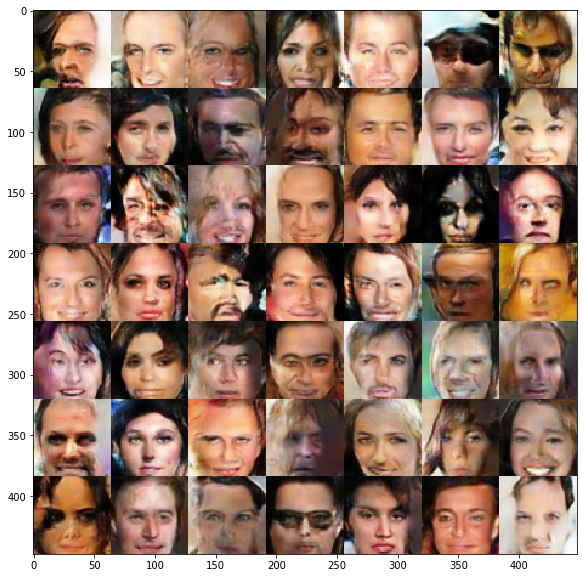

epoch: 16 batch: 0 [D loss: 0.690339] [G loss: 1.015657]
epoch: 16 batch: 1 [D loss: 0.656403] [G loss: 1.046456]
epoch: 16 batch: 2 [D loss: 0.681874] [G loss: 1.009619]
epoch: 16 batch: 3 [D loss: 0.670822] [G loss: 0.928526]
epoch: 16 batch: 4 [D loss: 0.637577] [G loss: 1.038818]
epoch: 16 batch: 5 [D loss: 0.617701] [G loss: 1.077198]
epoch: 16 batch: 6 [D loss: 0.674356] [G loss: 0.976506]
epoch: 16 batch: 7 [D loss: 0.667105] [G loss: 1.003941]
epoch: 16 batch: 8 [D loss: 0.655708] [G loss: 0.982989]
epoch: 16 batch: 9 [D loss: 0.645062] [G loss: 0.950451]
epoch: 16 batch: 10 [D loss: 0.651416] [G loss: 1.003647]
epoch: 16 batch: 11 [D loss: 0.683286] [G loss: 0.962172]
epoch: 16 batch: 12 [D loss: 0.687633] [G loss: 1.028136]
epoch: 16 batch: 13 [D loss: 0.674248] [G loss: 0.993425]
epoch: 16 batch: 14 [D loss: 0.669773] [G loss: 1.048316]
epoch: 16 batch: 15 [D loss: 0.671167] [G loss: 0.985156]
epoch: 16 batch: 16 [D loss: 0.647331] [G loss: 1.086627]
epoch: 16 batch: 17 [D l

epoch: 16 batch: 141 [D loss: 0.655507] [G loss: 1.025233]
epoch: 16 batch: 142 [D loss: 0.667262] [G loss: 0.952932]
epoch: 16 batch: 143 [D loss: 0.649090] [G loss: 0.928335]
epoch: 16 batch: 144 [D loss: 0.642195] [G loss: 1.008626]
epoch: 16 batch: 145 [D loss: 0.660099] [G loss: 0.946232]
epoch: 16 batch: 146 [D loss: 0.673303] [G loss: 1.028533]
epoch: 16 batch: 147 [D loss: 0.639152] [G loss: 0.951629]
epoch: 16 batch: 148 [D loss: 0.669493] [G loss: 0.995686]
epoch: 16 batch: 149 [D loss: 0.666757] [G loss: 0.906705]
epoch: 16 batch: 150 [D loss: 0.645793] [G loss: 0.960773]
epoch: 16 batch: 151 [D loss: 0.650075] [G loss: 1.054798]
epoch: 16 batch: 152 [D loss: 0.683387] [G loss: 0.994328]
epoch: 16 batch: 153 [D loss: 0.669610] [G loss: 1.004804]
epoch: 16 batch: 154 [D loss: 0.669630] [G loss: 0.941258]
epoch: 16 batch: 155 [D loss: 0.660004] [G loss: 0.980143]
epoch: 16 batch: 156 [D loss: 0.682454] [G loss: 0.979635]
epoch: 16 batch: 157 [D loss: 0.653289] [G loss: 0.99441

epoch: 16 batch: 280 [D loss: 0.661781] [G loss: 0.971120]
epoch: 16 batch: 281 [D loss: 0.675203] [G loss: 1.046358]
epoch: 16 batch: 282 [D loss: 0.616150] [G loss: 1.088948]
epoch: 16 batch: 283 [D loss: 0.664104] [G loss: 1.067039]
epoch: 16 batch: 284 [D loss: 0.661413] [G loss: 1.024061]
epoch: 16 batch: 285 [D loss: 0.699953] [G loss: 1.085459]
epoch: 16 batch: 286 [D loss: 0.639892] [G loss: 0.982011]
epoch: 16 batch: 287 [D loss: 0.673099] [G loss: 0.965852]
epoch: 16 batch: 288 [D loss: 0.678339] [G loss: 1.018642]
epoch: 16 batch: 289 [D loss: 0.676304] [G loss: 1.038355]
epoch: 16 batch: 290 [D loss: 0.650841] [G loss: 1.061590]
epoch: 16 batch: 291 [D loss: 0.675754] [G loss: 1.017298]
epoch: 16 batch: 292 [D loss: 0.650803] [G loss: 0.956698]
epoch: 16 batch: 293 [D loss: 0.644893] [G loss: 1.009628]
epoch: 16 batch: 294 [D loss: 0.667784] [G loss: 0.948978]
epoch: 16 batch: 295 [D loss: 0.689202] [G loss: 0.943568]
epoch: 16 batch: 296 [D loss: 0.687032] [G loss: 0.98851

epoch: 16 batch: 419 [D loss: 0.653397] [G loss: 0.949861]
epoch: 16 batch: 420 [D loss: 0.672411] [G loss: 1.002889]
epoch: 16 batch: 421 [D loss: 0.651794] [G loss: 0.979986]
epoch: 16 batch: 422 [D loss: 0.681117] [G loss: 0.984924]
epoch: 16 batch: 423 [D loss: 0.656195] [G loss: 0.951141]
epoch: 16 batch: 424 [D loss: 0.669541] [G loss: 0.963212]
epoch: 16 batch: 425 [D loss: 0.683946] [G loss: 0.999257]
epoch: 16 batch: 426 [D loss: 0.677687] [G loss: 0.954961]
epoch: 16 batch: 427 [D loss: 0.658643] [G loss: 0.997190]
epoch: 16 batch: 428 [D loss: 0.649166] [G loss: 0.970022]
epoch: 16 batch: 429 [D loss: 0.663515] [G loss: 0.991606]
epoch: 16 batch: 430 [D loss: 0.618065] [G loss: 1.014100]
epoch: 16 batch: 431 [D loss: 0.704153] [G loss: 0.990835]
epoch: 16 batch: 432 [D loss: 0.683495] [G loss: 1.003893]
epoch: 16 batch: 433 [D loss: 0.659649] [G loss: 0.958358]
epoch: 16 batch: 434 [D loss: 0.658916] [G loss: 0.986703]
epoch: 16 batch: 435 [D loss: 0.677042] [G loss: 0.97572

epoch: 16 batch: 558 [D loss: 0.636863] [G loss: 0.982475]
epoch: 16 batch: 559 [D loss: 0.690297] [G loss: 0.976879]
epoch: 16 batch: 560 [D loss: 0.672039] [G loss: 0.950155]
epoch: 16 batch: 561 [D loss: 0.653453] [G loss: 0.986497]
epoch: 16 batch: 562 [D loss: 0.679842] [G loss: 1.002684]
epoch: 16 batch: 563 [D loss: 0.658064] [G loss: 1.012715]
epoch: 16 batch: 564 [D loss: 0.659534] [G loss: 1.010749]
epoch: 16 batch: 565 [D loss: 0.708778] [G loss: 1.018175]
epoch: 16 batch: 566 [D loss: 0.648601] [G loss: 0.920921]
epoch: 16 batch: 567 [D loss: 0.652108] [G loss: 0.989638]
epoch: 16 batch: 568 [D loss: 0.631593] [G loss: 1.006669]
epoch: 16 batch: 569 [D loss: 0.646970] [G loss: 0.955663]
epoch: 16 batch: 570 [D loss: 0.671467] [G loss: 0.940400]
epoch: 16 batch: 571 [D loss: 0.662562] [G loss: 0.944961]
epoch: 16 batch: 572 [D loss: 0.655400] [G loss: 1.013725]
epoch: 16 batch: 573 [D loss: 0.647117] [G loss: 0.969284]
epoch: 16 batch: 574 [D loss: 0.643327] [G loss: 0.98885

epoch: 16 batch: 697 [D loss: 0.639997] [G loss: 0.968087]
epoch: 16 batch: 698 [D loss: 0.694631] [G loss: 0.996165]
epoch: 16 batch: 699 [D loss: 0.683096] [G loss: 1.050139]
epoch: 16 batch: 700 [D loss: 0.715315] [G loss: 0.983992]
epoch: 16 batch: 701 [D loss: 0.681276] [G loss: 1.018342]
epoch: 16 batch: 702 [D loss: 0.679376] [G loss: 1.047126]
epoch: 16 batch: 703 [D loss: 0.629501] [G loss: 1.015083]
epoch: 16 batch: 704 [D loss: 0.678544] [G loss: 0.995874]
epoch: 16 batch: 705 [D loss: 0.643673] [G loss: 0.961866]
epoch: 16 batch: 706 [D loss: 0.702787] [G loss: 0.953650]
epoch: 16 batch: 707 [D loss: 0.675970] [G loss: 1.020192]
epoch: 16 batch: 708 [D loss: 0.639888] [G loss: 0.948456]
epoch: 16 batch: 709 [D loss: 0.682866] [G loss: 0.941503]
epoch: 16 batch: 710 [D loss: 0.675241] [G loss: 0.982917]
epoch: 16 batch: 711 [D loss: 0.615369] [G loss: 1.032090]
epoch: 16 batch: 712 [D loss: 0.635085] [G loss: 0.974373]
epoch: 16 batch: 713 [D loss: 0.662361] [G loss: 0.92063

epoch: 16 batch: 836 [D loss: 0.694172] [G loss: 1.025776]
epoch: 16 batch: 837 [D loss: 0.664899] [G loss: 0.974474]
epoch: 16 batch: 838 [D loss: 0.681222] [G loss: 0.911421]
epoch: 16 batch: 839 [D loss: 0.663220] [G loss: 0.920319]
epoch: 16 batch: 840 [D loss: 0.663978] [G loss: 0.972533]
epoch: 16 batch: 841 [D loss: 0.682894] [G loss: 1.056240]
epoch: 16 batch: 842 [D loss: 0.653849] [G loss: 0.977831]
epoch: 16 batch: 843 [D loss: 0.679585] [G loss: 1.001954]
epoch: 16 batch: 844 [D loss: 0.658708] [G loss: 1.011553]
epoch: 16 batch: 845 [D loss: 0.708006] [G loss: 0.965821]
epoch: 16 batch: 846 [D loss: 0.650302] [G loss: 1.009432]
epoch: 16 batch: 847 [D loss: 0.640231] [G loss: 0.940907]
epoch: 16 batch: 848 [D loss: 0.669571] [G loss: 0.998793]
epoch: 16 batch: 849 [D loss: 0.632066] [G loss: 1.022347]
epoch: 16 batch: 850 [D loss: 0.641401] [G loss: 1.018241]
epoch: 16 batch: 851 [D loss: 0.660329] [G loss: 0.937638]
epoch: 16 batch: 852 [D loss: 0.640009] [G loss: 1.02233

epoch: 16 batch: 975 [D loss: 0.647685] [G loss: 1.001612]
epoch: 16 batch: 976 [D loss: 0.670517] [G loss: 0.979752]
epoch: 16 batch: 977 [D loss: 0.651986] [G loss: 0.960955]
epoch: 16 batch: 978 [D loss: 0.641375] [G loss: 1.003659]
epoch: 16 batch: 979 [D loss: 0.627297] [G loss: 0.969095]
epoch: 16 batch: 980 [D loss: 0.692017] [G loss: 0.988162]
epoch: 16 batch: 981 [D loss: 0.700933] [G loss: 1.011894]
epoch: 16 batch: 982 [D loss: 0.657274] [G loss: 1.013256]
epoch: 16 batch: 983 [D loss: 0.627651] [G loss: 0.969408]
epoch: 16 batch: 984 [D loss: 0.709592] [G loss: 0.966632]
epoch: 16 batch: 985 [D loss: 0.656377] [G loss: 0.967943]
epoch: 16 batch: 986 [D loss: 0.695571] [G loss: 0.966475]
epoch: 16 batch: 987 [D loss: 0.686970] [G loss: 1.030827]
epoch: 16 batch: 988 [D loss: 0.652474] [G loss: 1.041948]
epoch: 16 batch: 989 [D loss: 0.640550] [G loss: 0.993926]
epoch: 16 batch: 990 [D loss: 0.645980] [G loss: 1.054638]
epoch: 16 batch: 991 [D loss: 0.670632] [G loss: 0.98349

epoch: 16 batch: 1112 [D loss: 0.653910] [G loss: 0.959315]
epoch: 16 batch: 1113 [D loss: 0.633208] [G loss: 1.002790]
epoch: 16 batch: 1114 [D loss: 0.645343] [G loss: 0.966872]
epoch: 16 batch: 1115 [D loss: 0.657602] [G loss: 0.998099]
epoch: 16 batch: 1116 [D loss: 0.625442] [G loss: 0.960901]
epoch: 16 batch: 1117 [D loss: 0.696928] [G loss: 1.020131]
epoch: 16 batch: 1118 [D loss: 0.669460] [G loss: 1.012365]
epoch: 16 batch: 1119 [D loss: 0.643799] [G loss: 1.039983]
epoch: 16 batch: 1120 [D loss: 0.661697] [G loss: 0.924583]
epoch: 16 batch: 1121 [D loss: 0.687159] [G loss: 0.988127]
epoch: 16 batch: 1122 [D loss: 0.668520] [G loss: 0.998426]
epoch: 16 batch: 1123 [D loss: 0.661096] [G loss: 0.974886]
epoch: 16 batch: 1124 [D loss: 0.667438] [G loss: 1.008068]
epoch: 16 batch: 1125 [D loss: 0.689935] [G loss: 0.967423]
epoch: 16 batch: 1126 [D loss: 0.650426] [G loss: 1.000240]
epoch: 16 batch: 1127 [D loss: 0.710360] [G loss: 0.896092]
epoch: 16 batch: 1128 [D loss: 0.646134]

epoch: 16 batch: 1249 [D loss: 0.690538] [G loss: 0.969341]
epoch: 16 batch: 1250 [D loss: 0.653242] [G loss: 0.975816]
epoch: 16 batch: 1251 [D loss: 0.665774] [G loss: 0.978832]
epoch: 16 batch: 1252 [D loss: 0.639696] [G loss: 1.023489]
epoch: 16 batch: 1253 [D loss: 0.704229] [G loss: 1.001419]
epoch: 16 batch: 1254 [D loss: 0.659898] [G loss: 0.965915]
epoch: 16 batch: 1255 [D loss: 0.620726] [G loss: 1.062848]
epoch: 16 batch: 1256 [D loss: 0.669472] [G loss: 0.968379]
epoch: 16 batch: 1257 [D loss: 0.659428] [G loss: 0.954838]
epoch: 16 batch: 1258 [D loss: 0.653005] [G loss: 1.021733]
epoch: 16 batch: 1259 [D loss: 0.678341] [G loss: 0.966642]
epoch: 16 batch: 1260 [D loss: 0.651447] [G loss: 1.026893]
epoch: 16 batch: 1261 [D loss: 0.651977] [G loss: 0.989958]
epoch: 16 batch: 1262 [D loss: 0.645574] [G loss: 0.954447]
epoch: 16 batch: 1263 [D loss: 0.721343] [G loss: 0.928304]
epoch: 16 batch: 1264 [D loss: 0.640985] [G loss: 1.036412]
epoch: 16 batch: 1265 [D loss: 0.640791]

epoch: 16 batch: 1386 [D loss: 0.686940] [G loss: 0.868727]
epoch: 16 batch: 1387 [D loss: 0.668120] [G loss: 1.013472]
epoch: 16 batch: 1388 [D loss: 0.689256] [G loss: 1.066328]
epoch: 16 batch: 1389 [D loss: 0.645865] [G loss: 0.924010]
epoch: 16 batch: 1390 [D loss: 0.693286] [G loss: 1.025345]
epoch: 16 batch: 1391 [D loss: 0.632964] [G loss: 1.047158]
epoch: 16 batch: 1392 [D loss: 0.654952] [G loss: 1.025439]
epoch: 16 batch: 1393 [D loss: 0.678927] [G loss: 0.967229]
epoch: 16 batch: 1394 [D loss: 0.659550] [G loss: 0.986005]
epoch: 16 batch: 1395 [D loss: 0.660877] [G loss: 0.958049]
epoch: 16 batch: 1396 [D loss: 0.677541] [G loss: 1.058605]
epoch: 16 batch: 1397 [D loss: 0.649322] [G loss: 0.962652]
epoch: 16 batch: 1398 [D loss: 0.681627] [G loss: 1.009643]
epoch: 16 batch: 1399 [D loss: 0.658164] [G loss: 0.968647]
epoch: 16 batch: 1400 [D loss: 0.680665] [G loss: 0.990420]
epoch: 16 batch: 1401 [D loss: 0.691148] [G loss: 1.003749]
epoch: 16 batch: 1402 [D loss: 0.635399]

epoch: 16 batch: 1523 [D loss: 0.584934] [G loss: 1.057060]
epoch: 16 batch: 1524 [D loss: 0.693978] [G loss: 0.980117]
epoch: 16 batch: 1525 [D loss: 0.660104] [G loss: 0.966685]
epoch: 16 batch: 1526 [D loss: 0.667474] [G loss: 0.959447]
epoch: 16 batch: 1527 [D loss: 0.660220] [G loss: 0.916000]
epoch: 16 batch: 1528 [D loss: 0.679458] [G loss: 0.894426]
epoch: 16 batch: 1529 [D loss: 0.638860] [G loss: 1.030350]
epoch: 16 batch: 1530 [D loss: 0.743756] [G loss: 0.942294]
epoch: 16 batch: 1531 [D loss: 0.634896] [G loss: 1.039400]
epoch: 16 batch: 1532 [D loss: 0.648987] [G loss: 1.083695]
epoch: 16 batch: 1533 [D loss: 0.642860] [G loss: 0.992895]
epoch: 16 batch: 1534 [D loss: 0.660876] [G loss: 1.091397]
epoch: 16 batch: 1535 [D loss: 0.725343] [G loss: 0.996196]
epoch: 16 batch: 1536 [D loss: 0.657538] [G loss: 0.964052]
epoch: 16 batch: 1537 [D loss: 0.646407] [G loss: 0.926113]
epoch: 16 batch: 1538 [D loss: 0.692276] [G loss: 1.026003]
epoch: 16 batch: 1539 [D loss: 0.683849]

epoch: 17 batch: 81 [D loss: 0.655295] [G loss: 1.014567]
epoch: 17 batch: 82 [D loss: 0.661198] [G loss: 0.958780]
epoch: 17 batch: 83 [D loss: 0.632287] [G loss: 0.995315]
epoch: 17 batch: 84 [D loss: 0.632889] [G loss: 0.977840]
epoch: 17 batch: 85 [D loss: 0.640565] [G loss: 0.994936]
epoch: 17 batch: 86 [D loss: 0.655560] [G loss: 0.942004]
epoch: 17 batch: 87 [D loss: 0.642615] [G loss: 1.052127]
epoch: 17 batch: 88 [D loss: 0.671919] [G loss: 0.980126]
epoch: 17 batch: 89 [D loss: 0.633832] [G loss: 0.955213]
epoch: 17 batch: 90 [D loss: 0.660752] [G loss: 0.998595]
epoch: 17 batch: 91 [D loss: 0.653887] [G loss: 1.047586]
epoch: 17 batch: 92 [D loss: 0.680251] [G loss: 1.000498]
epoch: 17 batch: 93 [D loss: 0.656320] [G loss: 0.944690]
epoch: 17 batch: 94 [D loss: 0.670174] [G loss: 1.038096]
epoch: 17 batch: 95 [D loss: 0.632337] [G loss: 1.020739]
epoch: 17 batch: 96 [D loss: 0.660750] [G loss: 1.028867]
epoch: 17 batch: 97 [D loss: 0.655713] [G loss: 0.993773]
epoch: 17 batc

epoch: 17 batch: 221 [D loss: 0.647802] [G loss: 1.082658]
epoch: 17 batch: 222 [D loss: 0.681027] [G loss: 0.980431]
epoch: 17 batch: 223 [D loss: 0.629965] [G loss: 0.912751]
epoch: 17 batch: 224 [D loss: 0.700881] [G loss: 0.983895]
epoch: 17 batch: 225 [D loss: 0.663966] [G loss: 0.956272]
epoch: 17 batch: 226 [D loss: 0.616867] [G loss: 0.997804]
epoch: 17 batch: 227 [D loss: 0.657441] [G loss: 1.021807]
epoch: 17 batch: 228 [D loss: 0.649429] [G loss: 0.991887]
epoch: 17 batch: 229 [D loss: 0.692438] [G loss: 0.992105]
epoch: 17 batch: 230 [D loss: 0.667002] [G loss: 0.929721]
epoch: 17 batch: 231 [D loss: 0.648186] [G loss: 0.963273]
epoch: 17 batch: 232 [D loss: 0.719718] [G loss: 0.988992]
epoch: 17 batch: 233 [D loss: 0.696697] [G loss: 1.005107]
epoch: 17 batch: 234 [D loss: 0.691295] [G loss: 0.986848]
epoch: 17 batch: 235 [D loss: 0.625935] [G loss: 0.996690]
epoch: 17 batch: 236 [D loss: 0.661412] [G loss: 1.039663]
epoch: 17 batch: 237 [D loss: 0.681008] [G loss: 1.03642

epoch: 17 batch: 360 [D loss: 0.665484] [G loss: 1.002336]
epoch: 17 batch: 361 [D loss: 0.665333] [G loss: 0.985555]
epoch: 17 batch: 362 [D loss: 0.642417] [G loss: 0.985115]
epoch: 17 batch: 363 [D loss: 0.665978] [G loss: 1.016587]
epoch: 17 batch: 364 [D loss: 0.656928] [G loss: 0.967097]
epoch: 17 batch: 365 [D loss: 0.664079] [G loss: 1.002098]
epoch: 17 batch: 366 [D loss: 0.653048] [G loss: 1.022706]
epoch: 17 batch: 367 [D loss: 0.696212] [G loss: 1.018884]
epoch: 17 batch: 368 [D loss: 0.646868] [G loss: 1.006735]
epoch: 17 batch: 369 [D loss: 0.637525] [G loss: 0.993203]
epoch: 17 batch: 370 [D loss: 0.641751] [G loss: 1.034378]
epoch: 17 batch: 371 [D loss: 0.692430] [G loss: 0.974736]
epoch: 17 batch: 372 [D loss: 0.653488] [G loss: 0.973983]
epoch: 17 batch: 373 [D loss: 0.648473] [G loss: 0.971069]
epoch: 17 batch: 374 [D loss: 0.644536] [G loss: 1.048652]
epoch: 17 batch: 375 [D loss: 0.667804] [G loss: 1.013656]
epoch: 17 batch: 376 [D loss: 0.657610] [G loss: 1.04469

epoch: 17 batch: 499 [D loss: 0.667545] [G loss: 0.979185]
epoch: 17 batch: 500 [D loss: 0.658943] [G loss: 1.027985]
epoch: 17 batch: 501 [D loss: 0.636993] [G loss: 1.027183]
epoch: 17 batch: 502 [D loss: 0.670458] [G loss: 0.944147]
epoch: 17 batch: 503 [D loss: 0.651383] [G loss: 0.978916]
epoch: 17 batch: 504 [D loss: 0.667305] [G loss: 0.989481]
epoch: 17 batch: 505 [D loss: 0.694077] [G loss: 0.966221]
epoch: 17 batch: 506 [D loss: 0.666854] [G loss: 1.007693]
epoch: 17 batch: 507 [D loss: 0.621782] [G loss: 1.013712]
epoch: 17 batch: 508 [D loss: 0.655556] [G loss: 0.933178]
epoch: 17 batch: 509 [D loss: 0.666371] [G loss: 1.009391]
epoch: 17 batch: 510 [D loss: 0.676528] [G loss: 0.936970]
epoch: 17 batch: 511 [D loss: 0.665857] [G loss: 0.999198]
epoch: 17 batch: 512 [D loss: 0.622224] [G loss: 0.978219]
epoch: 17 batch: 513 [D loss: 0.645145] [G loss: 0.964850]
epoch: 17 batch: 514 [D loss: 0.627866] [G loss: 1.036021]
epoch: 17 batch: 515 [D loss: 0.653418] [G loss: 0.99218

epoch: 17 batch: 638 [D loss: 0.668282] [G loss: 1.008768]
epoch: 17 batch: 639 [D loss: 0.661361] [G loss: 1.022030]
epoch: 17 batch: 640 [D loss: 0.654974] [G loss: 0.917975]
epoch: 17 batch: 641 [D loss: 0.672815] [G loss: 0.987215]
epoch: 17 batch: 642 [D loss: 0.674551] [G loss: 0.990717]
epoch: 17 batch: 643 [D loss: 0.668099] [G loss: 0.996125]
epoch: 17 batch: 644 [D loss: 0.688390] [G loss: 0.964033]
epoch: 17 batch: 645 [D loss: 0.686536] [G loss: 0.952774]
epoch: 17 batch: 646 [D loss: 0.670362] [G loss: 1.018238]
epoch: 17 batch: 647 [D loss: 0.672366] [G loss: 0.928381]
epoch: 17 batch: 648 [D loss: 0.652355] [G loss: 0.943774]
epoch: 17 batch: 649 [D loss: 0.694468] [G loss: 0.993763]
epoch: 17 batch: 650 [D loss: 0.680757] [G loss: 0.985486]
epoch: 17 batch: 651 [D loss: 0.688763] [G loss: 0.948947]
epoch: 17 batch: 652 [D loss: 0.681133] [G loss: 1.001184]
epoch: 17 batch: 653 [D loss: 0.693430] [G loss: 0.964531]
epoch: 17 batch: 654 [D loss: 0.695262] [G loss: 0.94160

epoch: 17 batch: 777 [D loss: 0.649727] [G loss: 1.074965]
epoch: 17 batch: 778 [D loss: 0.659345] [G loss: 0.996276]
epoch: 17 batch: 779 [D loss: 0.670280] [G loss: 1.072378]
epoch: 17 batch: 780 [D loss: 0.674964] [G loss: 1.083117]
epoch: 17 batch: 781 [D loss: 0.640648] [G loss: 0.983336]
epoch: 17 batch: 782 [D loss: 0.671726] [G loss: 1.040763]
epoch: 17 batch: 783 [D loss: 0.649548] [G loss: 0.946987]
epoch: 17 batch: 784 [D loss: 0.674249] [G loss: 0.937527]
epoch: 17 batch: 785 [D loss: 0.647956] [G loss: 1.016836]
epoch: 17 batch: 786 [D loss: 0.659278] [G loss: 0.982163]
epoch: 17 batch: 787 [D loss: 0.675010] [G loss: 0.982908]
epoch: 17 batch: 788 [D loss: 0.636136] [G loss: 1.038260]
epoch: 17 batch: 789 [D loss: 0.678481] [G loss: 1.012155]
epoch: 17 batch: 790 [D loss: 0.720341] [G loss: 1.006420]
epoch: 17 batch: 791 [D loss: 0.689682] [G loss: 0.943192]
epoch: 17 batch: 792 [D loss: 0.667237] [G loss: 0.950444]
epoch: 17 batch: 793 [D loss: 0.651050] [G loss: 0.93033

epoch: 17 batch: 916 [D loss: 0.674295] [G loss: 0.937160]
epoch: 17 batch: 917 [D loss: 0.673280] [G loss: 0.995797]
epoch: 17 batch: 918 [D loss: 0.663563] [G loss: 0.972371]
epoch: 17 batch: 919 [D loss: 0.632101] [G loss: 0.936976]
epoch: 17 batch: 920 [D loss: 0.669666] [G loss: 0.938818]
epoch: 17 batch: 921 [D loss: 0.641000] [G loss: 1.025639]
epoch: 17 batch: 922 [D loss: 0.655235] [G loss: 1.031882]
epoch: 17 batch: 923 [D loss: 0.672319] [G loss: 0.991418]
epoch: 17 batch: 924 [D loss: 0.675186] [G loss: 0.914556]
epoch: 17 batch: 925 [D loss: 0.670635] [G loss: 0.982988]
epoch: 17 batch: 926 [D loss: 0.638277] [G loss: 1.026397]
epoch: 17 batch: 927 [D loss: 0.661788] [G loss: 0.954057]
epoch: 17 batch: 928 [D loss: 0.649028] [G loss: 0.998259]
epoch: 17 batch: 929 [D loss: 0.655074] [G loss: 0.913810]
epoch: 17 batch: 930 [D loss: 0.641717] [G loss: 0.990808]
epoch: 17 batch: 931 [D loss: 0.628603] [G loss: 0.984908]
epoch: 17 batch: 932 [D loss: 0.655444] [G loss: 0.99309

epoch: 17 batch: 1054 [D loss: 0.699902] [G loss: 1.029995]
epoch: 17 batch: 1055 [D loss: 0.648074] [G loss: 1.010543]
epoch: 17 batch: 1056 [D loss: 0.693060] [G loss: 0.990223]
epoch: 17 batch: 1057 [D loss: 0.656372] [G loss: 0.891760]
epoch: 17 batch: 1058 [D loss: 0.645912] [G loss: 0.991628]
epoch: 17 batch: 1059 [D loss: 0.646870] [G loss: 0.957259]
epoch: 17 batch: 1060 [D loss: 0.643758] [G loss: 0.956847]
epoch: 17 batch: 1061 [D loss: 0.670881] [G loss: 1.007353]
epoch: 17 batch: 1062 [D loss: 0.665218] [G loss: 0.990282]
epoch: 17 batch: 1063 [D loss: 0.582073] [G loss: 0.977223]
epoch: 17 batch: 1064 [D loss: 0.655181] [G loss: 0.962674]
epoch: 17 batch: 1065 [D loss: 0.694900] [G loss: 0.999266]
epoch: 17 batch: 1066 [D loss: 0.681854] [G loss: 0.983283]
epoch: 17 batch: 1067 [D loss: 0.663510] [G loss: 0.954984]
epoch: 17 batch: 1068 [D loss: 0.610639] [G loss: 0.988895]
epoch: 17 batch: 1069 [D loss: 0.682693] [G loss: 0.988379]
epoch: 17 batch: 1070 [D loss: 0.627491]

epoch: 17 batch: 1191 [D loss: 0.638550] [G loss: 1.078878]
epoch: 17 batch: 1192 [D loss: 0.622895] [G loss: 1.089585]
epoch: 17 batch: 1193 [D loss: 0.681969] [G loss: 1.011060]
epoch: 17 batch: 1194 [D loss: 0.709878] [G loss: 0.933086]
epoch: 17 batch: 1195 [D loss: 0.634698] [G loss: 1.012241]
epoch: 17 batch: 1196 [D loss: 0.653702] [G loss: 0.973765]
epoch: 17 batch: 1197 [D loss: 0.684643] [G loss: 1.008449]
epoch: 17 batch: 1198 [D loss: 0.650085] [G loss: 0.959844]
epoch: 17 batch: 1199 [D loss: 0.661812] [G loss: 0.985298]
epoch: 17 batch: 1200 [D loss: 0.649760] [G loss: 0.975536]
epoch: 17 batch: 1201 [D loss: 0.662461] [G loss: 0.987982]
epoch: 17 batch: 1202 [D loss: 0.627954] [G loss: 0.982814]
epoch: 17 batch: 1203 [D loss: 0.707346] [G loss: 0.974183]
epoch: 17 batch: 1204 [D loss: 0.688363] [G loss: 0.966109]
epoch: 17 batch: 1205 [D loss: 0.677509] [G loss: 0.951980]
epoch: 17 batch: 1206 [D loss: 0.673826] [G loss: 0.998479]
epoch: 17 batch: 1207 [D loss: 0.648802]

epoch: 17 batch: 1328 [D loss: 0.670171] [G loss: 0.944137]
epoch: 17 batch: 1329 [D loss: 0.640402] [G loss: 1.012941]
epoch: 17 batch: 1330 [D loss: 0.656051] [G loss: 1.012476]
epoch: 17 batch: 1331 [D loss: 0.683292] [G loss: 1.009129]
epoch: 17 batch: 1332 [D loss: 0.672227] [G loss: 1.033852]
epoch: 17 batch: 1333 [D loss: 0.624637] [G loss: 1.029284]
epoch: 17 batch: 1334 [D loss: 0.680798] [G loss: 1.011528]
epoch: 17 batch: 1335 [D loss: 0.635025] [G loss: 0.975689]
epoch: 17 batch: 1336 [D loss: 0.640833] [G loss: 0.972115]
epoch: 17 batch: 1337 [D loss: 0.677359] [G loss: 1.057688]
epoch: 17 batch: 1338 [D loss: 0.676504] [G loss: 1.010956]
epoch: 17 batch: 1339 [D loss: 0.662044] [G loss: 1.010491]
epoch: 17 batch: 1340 [D loss: 0.696044] [G loss: 1.026003]
epoch: 17 batch: 1341 [D loss: 0.627675] [G loss: 1.059743]
epoch: 17 batch: 1342 [D loss: 0.678654] [G loss: 0.960538]
epoch: 17 batch: 1343 [D loss: 0.665061] [G loss: 0.995895]
epoch: 17 batch: 1344 [D loss: 0.678570]

epoch: 17 batch: 1465 [D loss: 0.649586] [G loss: 1.059664]
epoch: 17 batch: 1466 [D loss: 0.660416] [G loss: 0.917622]
epoch: 17 batch: 1467 [D loss: 0.645303] [G loss: 1.033488]
epoch: 17 batch: 1468 [D loss: 0.688492] [G loss: 0.961747]
epoch: 17 batch: 1469 [D loss: 0.650942] [G loss: 1.029369]
epoch: 17 batch: 1470 [D loss: 0.633835] [G loss: 1.081499]
epoch: 17 batch: 1471 [D loss: 0.636766] [G loss: 0.874900]
epoch: 17 batch: 1472 [D loss: 0.636968] [G loss: 1.007804]
epoch: 17 batch: 1473 [D loss: 0.640164] [G loss: 0.941971]
epoch: 17 batch: 1474 [D loss: 0.692605] [G loss: 1.018814]
epoch: 17 batch: 1475 [D loss: 0.651947] [G loss: 0.993463]
epoch: 17 batch: 1476 [D loss: 0.671923] [G loss: 1.005860]
epoch: 17 batch: 1477 [D loss: 0.664258] [G loss: 0.947233]
epoch: 17 batch: 1478 [D loss: 0.664652] [G loss: 1.074407]
epoch: 17 batch: 1479 [D loss: 0.672432] [G loss: 0.981639]
epoch: 17 batch: 1480 [D loss: 0.643911] [G loss: 0.998516]
epoch: 17 batch: 1481 [D loss: 0.683824]

epoch: 18 batch: 21 [D loss: 0.641933] [G loss: 1.048690]
epoch: 18 batch: 22 [D loss: 0.644474] [G loss: 1.008646]
epoch: 18 batch: 23 [D loss: 0.651816] [G loss: 1.024525]
epoch: 18 batch: 24 [D loss: 0.670479] [G loss: 0.933129]
epoch: 18 batch: 25 [D loss: 0.668354] [G loss: 0.979550]
epoch: 18 batch: 26 [D loss: 0.662472] [G loss: 0.945815]
epoch: 18 batch: 27 [D loss: 0.655263] [G loss: 0.848754]
epoch: 18 batch: 28 [D loss: 0.648081] [G loss: 0.984321]
epoch: 18 batch: 29 [D loss: 0.647589] [G loss: 1.013971]
epoch: 18 batch: 30 [D loss: 0.667067] [G loss: 0.929872]
epoch: 18 batch: 31 [D loss: 0.675318] [G loss: 0.933089]
epoch: 18 batch: 32 [D loss: 0.753175] [G loss: 0.922537]
epoch: 18 batch: 33 [D loss: 0.661651] [G loss: 1.013453]
epoch: 18 batch: 34 [D loss: 0.622743] [G loss: 0.976882]
epoch: 18 batch: 35 [D loss: 0.690612] [G loss: 0.958807]
epoch: 18 batch: 36 [D loss: 0.657521] [G loss: 0.986414]
epoch: 18 batch: 37 [D loss: 0.678850] [G loss: 0.996478]
epoch: 18 batc

epoch: 18 batch: 162 [D loss: 0.663203] [G loss: 0.969960]
epoch: 18 batch: 163 [D loss: 0.677615] [G loss: 0.946221]
epoch: 18 batch: 164 [D loss: 0.639194] [G loss: 0.981687]
epoch: 18 batch: 165 [D loss: 0.664534] [G loss: 1.002027]
epoch: 18 batch: 166 [D loss: 0.656259] [G loss: 0.946722]
epoch: 18 batch: 167 [D loss: 0.652266] [G loss: 1.023599]
epoch: 18 batch: 168 [D loss: 0.662457] [G loss: 0.998729]
epoch: 18 batch: 169 [D loss: 0.666847] [G loss: 0.973272]
epoch: 18 batch: 170 [D loss: 0.669497] [G loss: 0.945186]
epoch: 18 batch: 171 [D loss: 0.676036] [G loss: 1.001578]
epoch: 18 batch: 172 [D loss: 0.663270] [G loss: 1.060389]
epoch: 18 batch: 173 [D loss: 0.644111] [G loss: 0.991159]
epoch: 18 batch: 174 [D loss: 0.676816] [G loss: 0.898588]
epoch: 18 batch: 175 [D loss: 0.633025] [G loss: 0.937520]
epoch: 18 batch: 176 [D loss: 0.617946] [G loss: 1.042948]
epoch: 18 batch: 177 [D loss: 0.695955] [G loss: 0.915143]
epoch: 18 batch: 178 [D loss: 0.645889] [G loss: 0.99263

epoch: 18 batch: 301 [D loss: 0.653929] [G loss: 1.035587]
epoch: 18 batch: 302 [D loss: 0.624218] [G loss: 0.992948]
epoch: 18 batch: 303 [D loss: 0.663728] [G loss: 1.041397]
epoch: 18 batch: 304 [D loss: 0.672516] [G loss: 1.037308]
epoch: 18 batch: 305 [D loss: 0.672581] [G loss: 0.942437]
epoch: 18 batch: 306 [D loss: 0.680346] [G loss: 0.949695]
epoch: 18 batch: 307 [D loss: 0.642643] [G loss: 1.040006]
epoch: 18 batch: 308 [D loss: 0.671914] [G loss: 0.989436]
epoch: 18 batch: 309 [D loss: 0.666330] [G loss: 0.985266]
epoch: 18 batch: 310 [D loss: 0.630379] [G loss: 0.926598]
epoch: 18 batch: 311 [D loss: 0.655769] [G loss: 0.989020]
epoch: 18 batch: 312 [D loss: 0.664512] [G loss: 1.043127]
epoch: 18 batch: 313 [D loss: 0.678636] [G loss: 0.982395]
epoch: 18 batch: 314 [D loss: 0.648310] [G loss: 0.972819]
epoch: 18 batch: 315 [D loss: 0.627299] [G loss: 0.979362]
epoch: 18 batch: 316 [D loss: 0.676954] [G loss: 0.970097]
epoch: 18 batch: 317 [D loss: 0.645690] [G loss: 1.03960

epoch: 18 batch: 440 [D loss: 0.661881] [G loss: 0.948559]
epoch: 18 batch: 441 [D loss: 0.642062] [G loss: 0.969349]
epoch: 18 batch: 442 [D loss: 0.679553] [G loss: 1.030610]
epoch: 18 batch: 443 [D loss: 0.636171] [G loss: 0.983146]
epoch: 18 batch: 444 [D loss: 0.653223] [G loss: 0.999656]
epoch: 18 batch: 445 [D loss: 0.658431] [G loss: 1.001061]
epoch: 18 batch: 446 [D loss: 0.619902] [G loss: 1.007966]
epoch: 18 batch: 447 [D loss: 0.665769] [G loss: 1.008470]
epoch: 18 batch: 448 [D loss: 0.674928] [G loss: 0.951810]
epoch: 18 batch: 449 [D loss: 0.676869] [G loss: 0.988302]
epoch: 18 batch: 450 [D loss: 0.639144] [G loss: 1.041490]
epoch: 18 batch: 451 [D loss: 0.685356] [G loss: 0.995561]
epoch: 18 batch: 452 [D loss: 0.689128] [G loss: 0.925676]
epoch: 18 batch: 453 [D loss: 0.642644] [G loss: 1.000650]
epoch: 18 batch: 454 [D loss: 0.693761] [G loss: 1.008542]
epoch: 18 batch: 455 [D loss: 0.637385] [G loss: 0.956009]
epoch: 18 batch: 456 [D loss: 0.651553] [G loss: 0.96813

epoch: 18 batch: 579 [D loss: 0.644601] [G loss: 1.022193]
epoch: 18 batch: 580 [D loss: 0.669121] [G loss: 0.911466]
epoch: 18 batch: 581 [D loss: 0.693927] [G loss: 0.985737]
epoch: 18 batch: 582 [D loss: 0.675658] [G loss: 0.953728]
epoch: 18 batch: 583 [D loss: 0.649316] [G loss: 0.913398]
epoch: 18 batch: 584 [D loss: 0.688140] [G loss: 0.964610]
epoch: 18 batch: 585 [D loss: 0.676798] [G loss: 1.044557]
epoch: 18 batch: 586 [D loss: 0.668444] [G loss: 1.045757]
epoch: 18 batch: 587 [D loss: 0.627638] [G loss: 0.988575]
epoch: 18 batch: 588 [D loss: 0.677823] [G loss: 1.049220]
epoch: 18 batch: 589 [D loss: 0.644018] [G loss: 0.980203]
epoch: 18 batch: 590 [D loss: 0.706829] [G loss: 1.015204]
epoch: 18 batch: 591 [D loss: 0.676221] [G loss: 0.999403]
epoch: 18 batch: 592 [D loss: 0.661806] [G loss: 1.034148]
epoch: 18 batch: 593 [D loss: 0.669751] [G loss: 1.016744]
epoch: 18 batch: 594 [D loss: 0.626155] [G loss: 1.004409]
epoch: 18 batch: 595 [D loss: 0.655599] [G loss: 0.95468

epoch: 18 batch: 718 [D loss: 0.660113] [G loss: 0.968039]
epoch: 18 batch: 719 [D loss: 0.669762] [G loss: 1.009769]
epoch: 18 batch: 720 [D loss: 0.663255] [G loss: 0.989924]
epoch: 18 batch: 721 [D loss: 0.661672] [G loss: 0.953668]
epoch: 18 batch: 722 [D loss: 0.670601] [G loss: 0.938606]
epoch: 18 batch: 723 [D loss: 0.688815] [G loss: 0.958130]
epoch: 18 batch: 724 [D loss: 0.670240] [G loss: 0.926004]
epoch: 18 batch: 725 [D loss: 0.643240] [G loss: 0.972107]
epoch: 18 batch: 726 [D loss: 0.697853] [G loss: 0.985063]
epoch: 18 batch: 727 [D loss: 0.644928] [G loss: 1.008805]
epoch: 18 batch: 728 [D loss: 0.671784] [G loss: 0.946043]
epoch: 18 batch: 729 [D loss: 0.663669] [G loss: 1.021198]
epoch: 18 batch: 730 [D loss: 0.699393] [G loss: 0.930418]
epoch: 18 batch: 731 [D loss: 0.666572] [G loss: 1.005219]
epoch: 18 batch: 732 [D loss: 0.651128] [G loss: 0.978904]
epoch: 18 batch: 733 [D loss: 0.653686] [G loss: 0.950933]
epoch: 18 batch: 734 [D loss: 0.691383] [G loss: 0.94341

epoch: 18 batch: 857 [D loss: 0.640924] [G loss: 0.998599]
epoch: 18 batch: 858 [D loss: 0.648203] [G loss: 1.068105]
epoch: 18 batch: 859 [D loss: 0.627412] [G loss: 0.960721]
epoch: 18 batch: 860 [D loss: 0.669608] [G loss: 1.007282]
epoch: 18 batch: 861 [D loss: 0.660852] [G loss: 0.987285]
epoch: 18 batch: 862 [D loss: 0.670850] [G loss: 1.029737]
epoch: 18 batch: 863 [D loss: 0.661114] [G loss: 0.975507]
epoch: 18 batch: 864 [D loss: 0.654974] [G loss: 0.974267]
epoch: 18 batch: 865 [D loss: 0.601312] [G loss: 0.980280]
epoch: 18 batch: 866 [D loss: 0.638576] [G loss: 1.025567]
epoch: 18 batch: 867 [D loss: 0.673177] [G loss: 1.097388]
epoch: 18 batch: 868 [D loss: 0.675838] [G loss: 1.007244]
epoch: 18 batch: 869 [D loss: 0.685115] [G loss: 0.961791]
epoch: 18 batch: 870 [D loss: 0.636941] [G loss: 0.919740]
epoch: 18 batch: 871 [D loss: 0.662204] [G loss: 1.045997]
epoch: 18 batch: 872 [D loss: 0.686985] [G loss: 1.055020]
epoch: 18 batch: 873 [D loss: 0.666150] [G loss: 0.98348

epoch: 18 batch: 996 [D loss: 0.646188] [G loss: 0.941230]
epoch: 18 batch: 997 [D loss: 0.655411] [G loss: 1.006768]
epoch: 18 batch: 998 [D loss: 0.659679] [G loss: 0.998304]
epoch: 18 batch: 999 [D loss: 0.666036] [G loss: 0.945012]
epoch: 18 batch: 1000 [D loss: 0.653307] [G loss: 0.979223]
epoch: 18 batch: 1001 [D loss: 0.682736] [G loss: 0.975471]
epoch: 18 batch: 1002 [D loss: 0.629844] [G loss: 1.033165]
epoch: 18 batch: 1003 [D loss: 0.653775] [G loss: 0.973538]
epoch: 18 batch: 1004 [D loss: 0.616944] [G loss: 0.936924]
epoch: 18 batch: 1005 [D loss: 0.677663] [G loss: 0.944909]
epoch: 18 batch: 1006 [D loss: 0.644882] [G loss: 0.983263]
epoch: 18 batch: 1007 [D loss: 0.674204] [G loss: 0.969332]
epoch: 18 batch: 1008 [D loss: 0.710828] [G loss: 0.889898]
epoch: 18 batch: 1009 [D loss: 0.666215] [G loss: 0.954385]
epoch: 18 batch: 1010 [D loss: 0.599891] [G loss: 1.039111]
epoch: 18 batch: 1011 [D loss: 0.627491] [G loss: 1.066471]
epoch: 18 batch: 1012 [D loss: 0.674706] [G 

epoch: 18 batch: 1133 [D loss: 0.671017] [G loss: 0.959251]
epoch: 18 batch: 1134 [D loss: 0.648008] [G loss: 0.963240]
epoch: 18 batch: 1135 [D loss: 0.676548] [G loss: 0.999295]
epoch: 18 batch: 1136 [D loss: 0.618495] [G loss: 0.946888]
epoch: 18 batch: 1137 [D loss: 0.651078] [G loss: 0.979225]
epoch: 18 batch: 1138 [D loss: 0.630352] [G loss: 0.981314]
epoch: 18 batch: 1139 [D loss: 0.668794] [G loss: 0.923623]
epoch: 18 batch: 1140 [D loss: 0.700319] [G loss: 0.951002]
epoch: 18 batch: 1141 [D loss: 0.650255] [G loss: 1.027965]
epoch: 18 batch: 1142 [D loss: 0.649794] [G loss: 0.998361]
epoch: 18 batch: 1143 [D loss: 0.692315] [G loss: 1.034572]
epoch: 18 batch: 1144 [D loss: 0.668613] [G loss: 0.974078]
epoch: 18 batch: 1145 [D loss: 0.649260] [G loss: 0.945515]
epoch: 18 batch: 1146 [D loss: 0.691217] [G loss: 0.986603]
epoch: 18 batch: 1147 [D loss: 0.682592] [G loss: 0.972447]
epoch: 18 batch: 1148 [D loss: 0.672761] [G loss: 0.950803]
epoch: 18 batch: 1149 [D loss: 0.665047]

epoch: 18 batch: 1270 [D loss: 0.649361] [G loss: 0.888662]
epoch: 18 batch: 1271 [D loss: 0.685411] [G loss: 0.985150]
epoch: 18 batch: 1272 [D loss: 0.644334] [G loss: 0.995218]
epoch: 18 batch: 1273 [D loss: 0.627956] [G loss: 0.969936]
epoch: 18 batch: 1274 [D loss: 0.652940] [G loss: 0.991071]
epoch: 18 batch: 1275 [D loss: 0.679826] [G loss: 0.971503]
epoch: 18 batch: 1276 [D loss: 0.610918] [G loss: 0.950032]
epoch: 18 batch: 1277 [D loss: 0.670350] [G loss: 0.910035]
epoch: 18 batch: 1278 [D loss: 0.634451] [G loss: 1.022992]
epoch: 18 batch: 1279 [D loss: 0.651290] [G loss: 1.018909]
epoch: 18 batch: 1280 [D loss: 0.666107] [G loss: 0.985244]
epoch: 18 batch: 1281 [D loss: 0.696463] [G loss: 0.970056]
epoch: 18 batch: 1282 [D loss: 0.653479] [G loss: 0.971747]
epoch: 18 batch: 1283 [D loss: 0.688108] [G loss: 1.049265]
epoch: 18 batch: 1284 [D loss: 0.627890] [G loss: 0.971748]
epoch: 18 batch: 1285 [D loss: 0.686253] [G loss: 0.977173]
epoch: 18 batch: 1286 [D loss: 0.631284]

epoch: 18 batch: 1407 [D loss: 0.679512] [G loss: 0.937226]
epoch: 18 batch: 1408 [D loss: 0.651907] [G loss: 0.964396]
epoch: 18 batch: 1409 [D loss: 0.614790] [G loss: 1.001278]
epoch: 18 batch: 1410 [D loss: 0.669039] [G loss: 1.027821]
epoch: 18 batch: 1411 [D loss: 0.648225] [G loss: 0.949431]
epoch: 18 batch: 1412 [D loss: 0.695115] [G loss: 0.959013]
epoch: 18 batch: 1413 [D loss: 0.670205] [G loss: 1.004682]
epoch: 18 batch: 1414 [D loss: 0.651820] [G loss: 1.004921]
epoch: 18 batch: 1415 [D loss: 0.677507] [G loss: 1.043697]
epoch: 18 batch: 1416 [D loss: 0.675732] [G loss: 0.941033]
epoch: 18 batch: 1417 [D loss: 0.631307] [G loss: 0.998562]
epoch: 18 batch: 1418 [D loss: 0.667547] [G loss: 0.934363]
epoch: 18 batch: 1419 [D loss: 0.646981] [G loss: 1.013947]
epoch: 18 batch: 1420 [D loss: 0.662991] [G loss: 0.986212]
epoch: 18 batch: 1421 [D loss: 0.661337] [G loss: 1.044414]
epoch: 18 batch: 1422 [D loss: 0.706935] [G loss: 0.991864]
epoch: 18 batch: 1423 [D loss: 0.666763]

epoch: 18 batch: 1544 [D loss: 0.717764] [G loss: 0.948673]
epoch: 18 batch: 1545 [D loss: 0.667617] [G loss: 1.018503]
epoch: 18 batch: 1546 [D loss: 0.603499] [G loss: 1.009202]
epoch: 18 batch: 1547 [D loss: 0.669406] [G loss: 1.012965]
epoch: 18 batch: 1548 [D loss: 0.645846] [G loss: 0.961713]
epoch: 18 batch: 1549 [D loss: 0.663336] [G loss: 0.947465]
epoch: 18 batch: 1550 [D loss: 0.649435] [G loss: 0.971009]
epoch: 18 batch: 1551 [D loss: 0.625879] [G loss: 0.983156]
epoch: 18 batch: 1552 [D loss: 0.648435] [G loss: 1.065611]
epoch: 18 batch: 1553 [D loss: 0.697735] [G loss: 1.011637]
epoch: 18 batch: 1554 [D loss: 0.672079] [G loss: 0.959547]
epoch: 18 batch: 1555 [D loss: 0.649079] [G loss: 0.866984]
epoch: 18 batch: 1556 [D loss: 0.625993] [G loss: 1.049954]
epoch: 18 batch: 1557 [D loss: 0.699798] [G loss: 1.002190]
epoch: 18 batch: 1558 [D loss: 0.697785] [G loss: 0.896172]
epoch: 18 batch: 1559 [D loss: 0.641550] [G loss: 1.004423]
epoch: 18 batch: 1560 [D loss: 0.694893]

epoch: 19 batch: 103 [D loss: 0.677559] [G loss: 1.005983]
epoch: 19 batch: 104 [D loss: 0.649624] [G loss: 0.988336]
epoch: 19 batch: 105 [D loss: 0.634683] [G loss: 0.984221]
epoch: 19 batch: 106 [D loss: 0.671497] [G loss: 0.948606]
epoch: 19 batch: 107 [D loss: 0.654587] [G loss: 1.010194]
epoch: 19 batch: 108 [D loss: 0.669351] [G loss: 0.986939]
epoch: 19 batch: 109 [D loss: 0.679030] [G loss: 0.955703]
epoch: 19 batch: 110 [D loss: 0.672619] [G loss: 1.065784]
epoch: 19 batch: 111 [D loss: 0.639097] [G loss: 1.019246]
epoch: 19 batch: 112 [D loss: 0.633037] [G loss: 0.981650]
epoch: 19 batch: 113 [D loss: 0.668122] [G loss: 1.041098]
epoch: 19 batch: 114 [D loss: 0.678109] [G loss: 0.984656]
epoch: 19 batch: 115 [D loss: 0.630018] [G loss: 1.005288]
epoch: 19 batch: 116 [D loss: 0.636895] [G loss: 0.976533]
epoch: 19 batch: 117 [D loss: 0.635865] [G loss: 1.049136]
epoch: 19 batch: 118 [D loss: 0.643720] [G loss: 0.954315]
epoch: 19 batch: 119 [D loss: 0.644927] [G loss: 0.89345

epoch: 19 batch: 242 [D loss: 0.706176] [G loss: 0.908077]
epoch: 19 batch: 243 [D loss: 0.658983] [G loss: 0.964966]
epoch: 19 batch: 244 [D loss: 0.691630] [G loss: 1.067538]
epoch: 19 batch: 245 [D loss: 0.634069] [G loss: 0.948653]
epoch: 19 batch: 246 [D loss: 0.710064] [G loss: 0.991110]
epoch: 19 batch: 247 [D loss: 0.653948] [G loss: 1.017742]
epoch: 19 batch: 248 [D loss: 0.666704] [G loss: 0.995439]
epoch: 19 batch: 249 [D loss: 0.669934] [G loss: 0.931188]
epoch: 19 batch: 250 [D loss: 0.654922] [G loss: 1.050356]
epoch: 19 batch: 251 [D loss: 0.670381] [G loss: 0.969176]
epoch: 19 batch: 252 [D loss: 0.659476] [G loss: 0.959067]
epoch: 19 batch: 253 [D loss: 0.630543] [G loss: 0.991416]
epoch: 19 batch: 254 [D loss: 0.662984] [G loss: 0.967490]
epoch: 19 batch: 255 [D loss: 0.678462] [G loss: 0.944249]
epoch: 19 batch: 256 [D loss: 0.627615] [G loss: 0.997511]
epoch: 19 batch: 257 [D loss: 0.654326] [G loss: 0.958205]
epoch: 19 batch: 258 [D loss: 0.684384] [G loss: 0.98361

epoch: 19 batch: 381 [D loss: 0.657392] [G loss: 0.929563]
epoch: 19 batch: 382 [D loss: 0.646035] [G loss: 1.021968]
epoch: 19 batch: 383 [D loss: 0.691039] [G loss: 0.962489]
epoch: 19 batch: 384 [D loss: 0.645594] [G loss: 0.949259]
epoch: 19 batch: 385 [D loss: 0.624375] [G loss: 0.971842]
epoch: 19 batch: 386 [D loss: 0.672501] [G loss: 0.978773]
epoch: 19 batch: 387 [D loss: 0.680274] [G loss: 0.933410]
epoch: 19 batch: 388 [D loss: 0.673205] [G loss: 1.013934]
epoch: 19 batch: 389 [D loss: 0.674237] [G loss: 0.987059]
epoch: 19 batch: 390 [D loss: 0.646401] [G loss: 1.011429]
epoch: 19 batch: 391 [D loss: 0.683222] [G loss: 0.983691]
epoch: 19 batch: 392 [D loss: 0.635150] [G loss: 1.029227]
epoch: 19 batch: 393 [D loss: 0.667896] [G loss: 0.988830]
epoch: 19 batch: 394 [D loss: 0.650956] [G loss: 1.025200]
epoch: 19 batch: 395 [D loss: 0.652811] [G loss: 0.986938]
epoch: 19 batch: 396 [D loss: 0.667531] [G loss: 0.972495]
epoch: 19 batch: 397 [D loss: 0.667120] [G loss: 0.98946

epoch: 19 batch: 520 [D loss: 0.651207] [G loss: 0.990344]
epoch: 19 batch: 521 [D loss: 0.634165] [G loss: 1.012046]
epoch: 19 batch: 522 [D loss: 0.641889] [G loss: 1.004289]
epoch: 19 batch: 523 [D loss: 0.659270] [G loss: 1.007759]
epoch: 19 batch: 524 [D loss: 0.657259] [G loss: 0.961168]
epoch: 19 batch: 525 [D loss: 0.682673] [G loss: 0.996706]
epoch: 19 batch: 526 [D loss: 0.671749] [G loss: 0.996521]
epoch: 19 batch: 527 [D loss: 0.704055] [G loss: 1.047347]
epoch: 19 batch: 528 [D loss: 0.641645] [G loss: 0.978588]
epoch: 19 batch: 529 [D loss: 0.689442] [G loss: 0.971232]
epoch: 19 batch: 530 [D loss: 0.671332] [G loss: 0.977372]
epoch: 19 batch: 531 [D loss: 0.663610] [G loss: 1.056744]
epoch: 19 batch: 532 [D loss: 0.651096] [G loss: 1.039296]
epoch: 19 batch: 533 [D loss: 0.687058] [G loss: 1.040271]
epoch: 19 batch: 534 [D loss: 0.669814] [G loss: 1.020408]
epoch: 19 batch: 535 [D loss: 0.646892] [G loss: 1.023327]
epoch: 19 batch: 536 [D loss: 0.644421] [G loss: 0.99529

epoch: 19 batch: 659 [D loss: 0.658935] [G loss: 1.024075]
epoch: 19 batch: 660 [D loss: 0.630413] [G loss: 0.985006]
epoch: 19 batch: 661 [D loss: 0.695278] [G loss: 1.009484]
epoch: 19 batch: 662 [D loss: 0.642752] [G loss: 1.001530]
epoch: 19 batch: 663 [D loss: 0.667424] [G loss: 0.969448]
epoch: 19 batch: 664 [D loss: 0.644197] [G loss: 0.956752]
epoch: 19 batch: 665 [D loss: 0.672853] [G loss: 0.991254]
epoch: 19 batch: 666 [D loss: 0.676128] [G loss: 0.966091]
epoch: 19 batch: 667 [D loss: 0.679863] [G loss: 0.984993]
epoch: 19 batch: 668 [D loss: 0.655642] [G loss: 0.941645]
epoch: 19 batch: 669 [D loss: 0.670453] [G loss: 0.958983]
epoch: 19 batch: 670 [D loss: 0.622252] [G loss: 0.972244]
epoch: 19 batch: 671 [D loss: 0.658507] [G loss: 0.985405]
epoch: 19 batch: 672 [D loss: 0.680797] [G loss: 0.972733]
epoch: 19 batch: 673 [D loss: 0.677428] [G loss: 0.990295]
epoch: 19 batch: 674 [D loss: 0.652517] [G loss: 0.990069]
epoch: 19 batch: 675 [D loss: 0.653889] [G loss: 0.94405

epoch: 19 batch: 798 [D loss: 0.676262] [G loss: 1.039419]
epoch: 19 batch: 799 [D loss: 0.681186] [G loss: 0.944273]
epoch: 19 batch: 800 [D loss: 0.658681] [G loss: 0.988961]
epoch: 19 batch: 801 [D loss: 0.671850] [G loss: 1.029523]
epoch: 19 batch: 802 [D loss: 0.637273] [G loss: 0.953440]
epoch: 19 batch: 803 [D loss: 0.648151] [G loss: 0.950412]
epoch: 19 batch: 804 [D loss: 0.697283] [G loss: 1.022350]
epoch: 19 batch: 805 [D loss: 0.622414] [G loss: 1.027013]
epoch: 19 batch: 806 [D loss: 0.647057] [G loss: 1.052746]
epoch: 19 batch: 807 [D loss: 0.689505] [G loss: 0.982454]
epoch: 19 batch: 808 [D loss: 0.669102] [G loss: 0.983526]
epoch: 19 batch: 809 [D loss: 0.680713] [G loss: 0.965350]
epoch: 19 batch: 810 [D loss: 0.642431] [G loss: 0.987984]
epoch: 19 batch: 811 [D loss: 0.672135] [G loss: 1.011188]
epoch: 19 batch: 812 [D loss: 0.646638] [G loss: 0.988289]
epoch: 19 batch: 813 [D loss: 0.627941] [G loss: 1.029312]
epoch: 19 batch: 814 [D loss: 0.663929] [G loss: 1.03377

epoch: 19 batch: 937 [D loss: 0.633235] [G loss: 0.936137]
epoch: 19 batch: 938 [D loss: 0.699570] [G loss: 0.955980]
epoch: 19 batch: 939 [D loss: 0.681079] [G loss: 1.002219]
epoch: 19 batch: 940 [D loss: 0.649081] [G loss: 1.003041]
epoch: 19 batch: 941 [D loss: 0.659866] [G loss: 0.982113]
epoch: 19 batch: 942 [D loss: 0.671870] [G loss: 0.978983]
epoch: 19 batch: 943 [D loss: 0.623748] [G loss: 1.060171]
epoch: 19 batch: 944 [D loss: 0.655603] [G loss: 0.988819]
epoch: 19 batch: 945 [D loss: 0.681769] [G loss: 0.953870]
epoch: 19 batch: 946 [D loss: 0.623813] [G loss: 1.030882]
epoch: 19 batch: 947 [D loss: 0.669464] [G loss: 1.011656]
epoch: 19 batch: 948 [D loss: 0.646635] [G loss: 1.017392]
epoch: 19 batch: 949 [D loss: 0.653722] [G loss: 0.967875]
epoch: 19 batch: 950 [D loss: 0.642522] [G loss: 0.971162]
epoch: 19 batch: 951 [D loss: 0.639473] [G loss: 0.973206]
epoch: 19 batch: 952 [D loss: 0.629817] [G loss: 1.013823]
epoch: 19 batch: 953 [D loss: 0.641062] [G loss: 1.05210

epoch: 19 batch: 1075 [D loss: 0.679337] [G loss: 1.005137]
epoch: 19 batch: 1076 [D loss: 0.671765] [G loss: 0.979650]
epoch: 19 batch: 1077 [D loss: 0.660867] [G loss: 0.946439]
epoch: 19 batch: 1078 [D loss: 0.661987] [G loss: 1.040595]
epoch: 19 batch: 1079 [D loss: 0.628406] [G loss: 1.004728]
epoch: 19 batch: 1080 [D loss: 0.702170] [G loss: 1.014776]
epoch: 19 batch: 1081 [D loss: 0.682243] [G loss: 0.985694]
epoch: 19 batch: 1082 [D loss: 0.643117] [G loss: 1.006033]
epoch: 19 batch: 1083 [D loss: 0.651624] [G loss: 0.972852]
epoch: 19 batch: 1084 [D loss: 0.628332] [G loss: 0.891547]
epoch: 19 batch: 1085 [D loss: 0.646981] [G loss: 0.965371]
epoch: 19 batch: 1086 [D loss: 0.685322] [G loss: 0.964224]
epoch: 19 batch: 1087 [D loss: 0.627809] [G loss: 0.906707]
epoch: 19 batch: 1088 [D loss: 0.642568] [G loss: 0.975169]
epoch: 19 batch: 1089 [D loss: 0.630180] [G loss: 1.012736]
epoch: 19 batch: 1090 [D loss: 0.706064] [G loss: 0.969408]
epoch: 19 batch: 1091 [D loss: 0.665710]

epoch: 19 batch: 1212 [D loss: 0.648699] [G loss: 0.942117]
epoch: 19 batch: 1213 [D loss: 0.660417] [G loss: 0.950951]
epoch: 19 batch: 1214 [D loss: 0.640218] [G loss: 0.974550]
epoch: 19 batch: 1215 [D loss: 0.712059] [G loss: 1.009273]
epoch: 19 batch: 1216 [D loss: 0.688721] [G loss: 0.994028]
epoch: 19 batch: 1217 [D loss: 0.668488] [G loss: 0.985446]
epoch: 19 batch: 1218 [D loss: 0.655684] [G loss: 0.999740]
epoch: 19 batch: 1219 [D loss: 0.652958] [G loss: 0.997554]
epoch: 19 batch: 1220 [D loss: 0.647749] [G loss: 0.971645]
epoch: 19 batch: 1221 [D loss: 0.661578] [G loss: 0.990767]
epoch: 19 batch: 1222 [D loss: 0.655179] [G loss: 0.996249]
epoch: 19 batch: 1223 [D loss: 0.666798] [G loss: 1.001231]
epoch: 19 batch: 1224 [D loss: 0.657867] [G loss: 0.952254]
epoch: 19 batch: 1225 [D loss: 0.659250] [G loss: 0.992723]
epoch: 19 batch: 1226 [D loss: 0.680850] [G loss: 0.999312]
epoch: 19 batch: 1227 [D loss: 0.700681] [G loss: 0.972640]
epoch: 19 batch: 1228 [D loss: 0.629473]

epoch: 19 batch: 1349 [D loss: 0.661503] [G loss: 0.981786]
epoch: 19 batch: 1350 [D loss: 0.658338] [G loss: 1.012092]
epoch: 19 batch: 1351 [D loss: 0.672236] [G loss: 1.007315]
epoch: 19 batch: 1352 [D loss: 0.694385] [G loss: 1.009643]
epoch: 19 batch: 1353 [D loss: 0.678135] [G loss: 1.084281]
epoch: 19 batch: 1354 [D loss: 0.644976] [G loss: 0.972135]
epoch: 19 batch: 1355 [D loss: 0.669949] [G loss: 0.995991]
epoch: 19 batch: 1356 [D loss: 0.640488] [G loss: 1.027395]
epoch: 19 batch: 1357 [D loss: 0.658234] [G loss: 0.951059]
epoch: 19 batch: 1358 [D loss: 0.641565] [G loss: 1.007837]
epoch: 19 batch: 1359 [D loss: 0.647722] [G loss: 0.956165]
epoch: 19 batch: 1360 [D loss: 0.657066] [G loss: 0.944363]
epoch: 19 batch: 1361 [D loss: 0.655110] [G loss: 1.003881]
epoch: 19 batch: 1362 [D loss: 0.664127] [G loss: 1.011436]
epoch: 19 batch: 1363 [D loss: 0.655362] [G loss: 0.913072]
epoch: 19 batch: 1364 [D loss: 0.674163] [G loss: 0.940178]
epoch: 19 batch: 1365 [D loss: 0.631311]

epoch: 19 batch: 1486 [D loss: 0.620123] [G loss: 0.980793]
epoch: 19 batch: 1487 [D loss: 0.697712] [G loss: 0.950907]
epoch: 19 batch: 1488 [D loss: 0.673313] [G loss: 0.991690]
epoch: 19 batch: 1489 [D loss: 0.682559] [G loss: 0.978605]
epoch: 19 batch: 1490 [D loss: 0.634864] [G loss: 0.981088]
epoch: 19 batch: 1491 [D loss: 0.649177] [G loss: 1.022753]
epoch: 19 batch: 1492 [D loss: 0.655486] [G loss: 0.954950]
epoch: 19 batch: 1493 [D loss: 0.644253] [G loss: 1.008744]
epoch: 19 batch: 1494 [D loss: 0.657043] [G loss: 1.006124]
epoch: 19 batch: 1495 [D loss: 0.639182] [G loss: 0.972350]
epoch: 19 batch: 1496 [D loss: 0.641245] [G loss: 0.987989]
epoch: 19 batch: 1497 [D loss: 0.685043] [G loss: 0.941976]
epoch: 19 batch: 1498 [D loss: 0.683376] [G loss: 0.895645]
epoch: 19 batch: 1499 [D loss: 0.673488] [G loss: 1.031405]
epoch: 19 batch: 1500 [D loss: 0.656473] [G loss: 0.998505]
epoch: 19 batch: 1501 [D loss: 0.615008] [G loss: 0.964793]
epoch: 19 batch: 1502 [D loss: 0.665450]

In [8]:
# training dcgan
gan = DCGAN()
# gan = WGAN()
gan.train(X_train, epochs=20, batch_size=128, save_interval=5)

# You must use "output_fig" function to save your array of images into figure!
# Submit your results.png to google drive

In [9]:
def output_fig(images_array, file_name="./results"):
    plt.figure(figsize=(6, 6), dpi=100)
    plt.imshow(helper.images_square_grid(images_array))
    plt.axis("off")
    plt.savefig(file_name+'.png', bbox_inches='tight', pad_inches=0)    

## Pseudo code for you

loading model...
(9, 64, 64, 3) 0.99997884 -0.9999936
(9, 64, 64, 3) 254.9973 0.00081315637


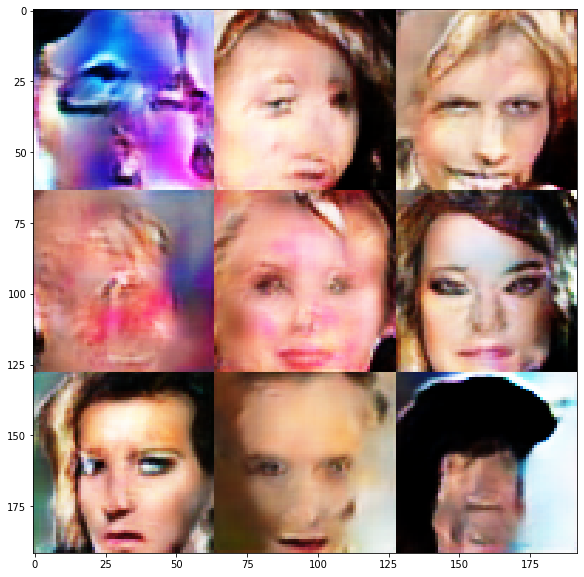

(9, 64, 64, 3) 0.99953324 -0.99989766
(9, 64, 64, 3) 254.94048 0.0130485


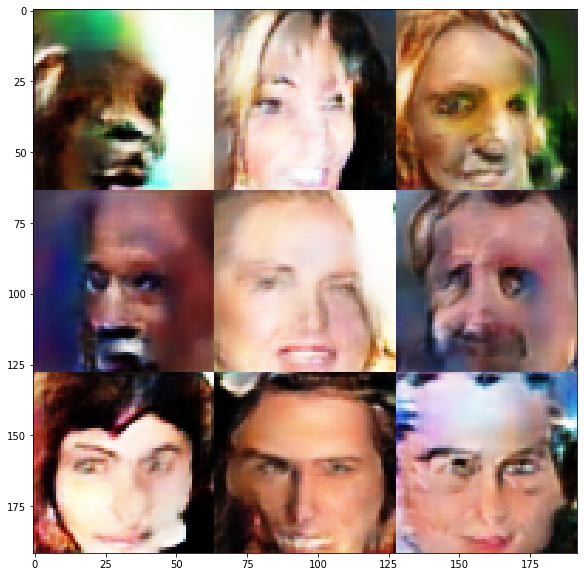

(9, 64, 64, 3) 0.9999982 -0.99995273
(9, 64, 64, 3) 254.99977 0.0060264766


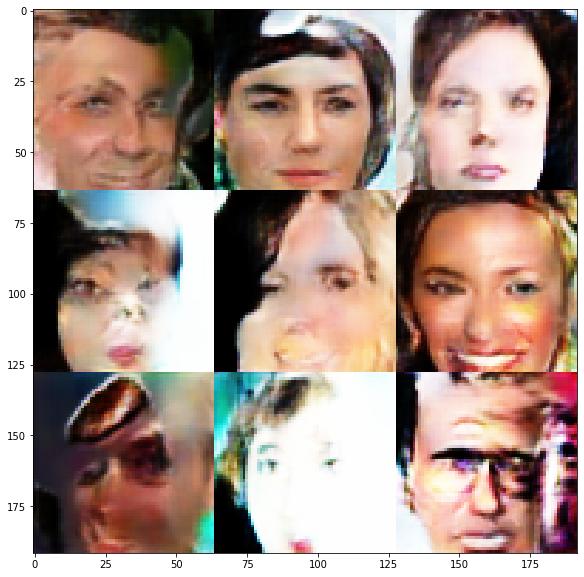

(9, 64, 64, 3) 0.9998737 -0.99997526
(9, 64, 64, 3) 254.98389 0.0031538308


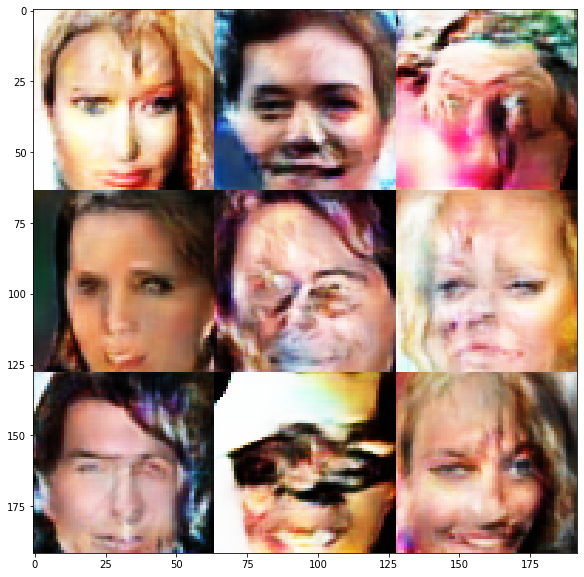

(9, 64, 64, 3) 0.99959314 -0.9992738
(9, 64, 64, 3) 254.94812 0.09259343


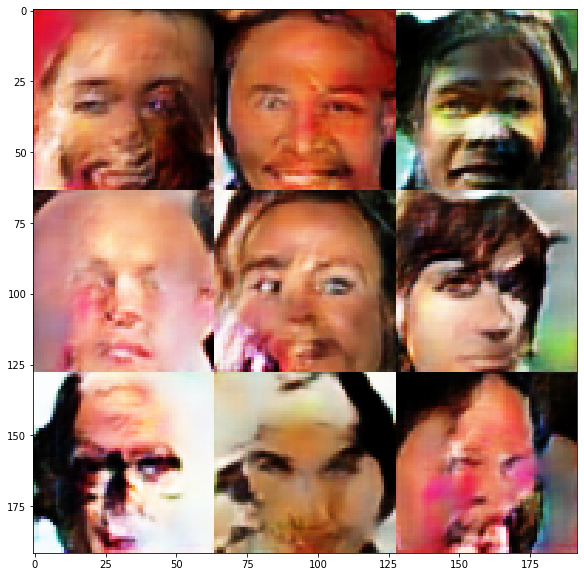

(9, 64, 64, 3) 0.9999991 -0.99982107
(9, 64, 64, 3) 254.99988 0.022813976


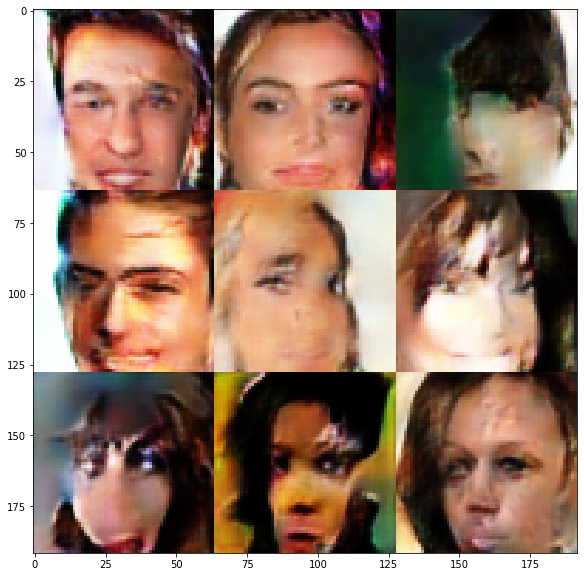

(9, 64, 64, 3) 0.99955523 -0.99994206
(9, 64, 64, 3) 254.9433 0.0073868036


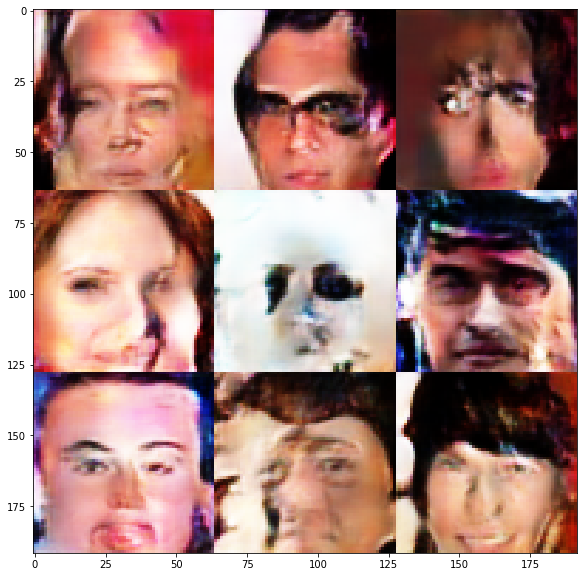

(9, 64, 64, 3) 0.9993268 -0.9999982
(9, 64, 64, 3) 254.91417 0.00022798777


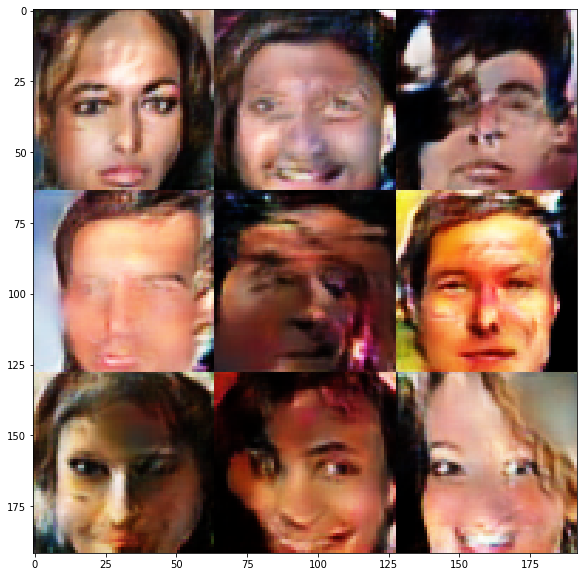

(9, 64, 64, 3) 0.99997187 -0.99992865
(9, 64, 64, 3) 254.99641 0.009096712


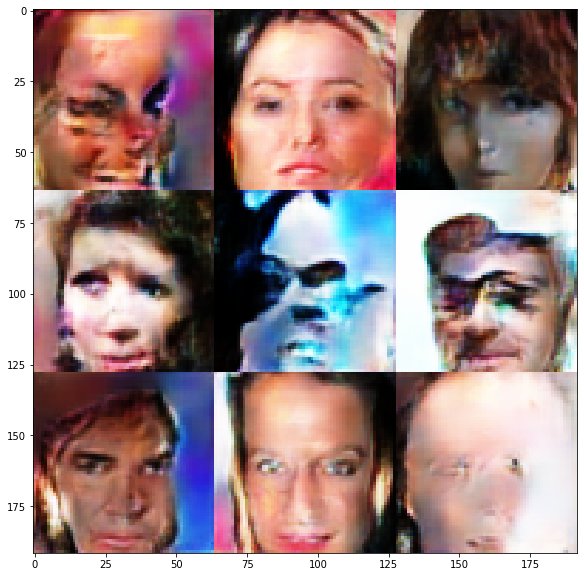

(9, 64, 64, 3) 0.9996305 -0.99999917
(9, 64, 64, 3) 254.95288 0.00010639429


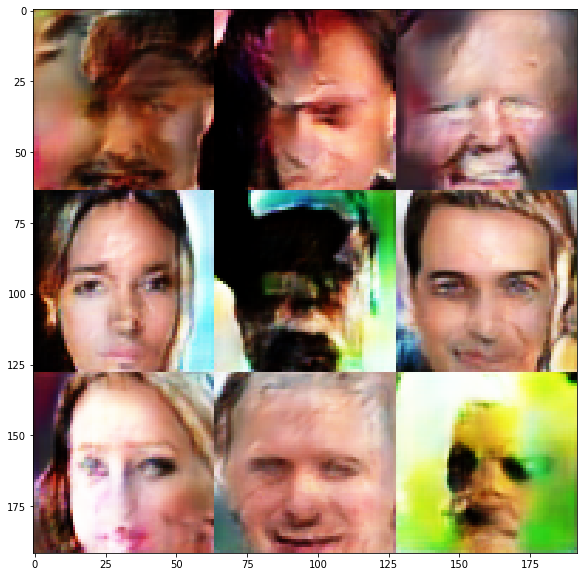

(9, 64, 64, 3) 0.99985373 -0.9998468
(9, 64, 64, 3) 254.98135 0.019530952


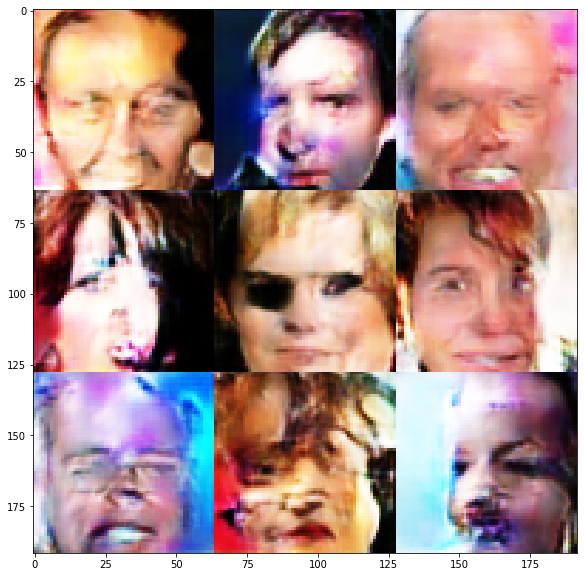

(9, 64, 64, 3) 0.99980557 -0.9989774
(9, 64, 64, 3) 254.9752 0.1303786


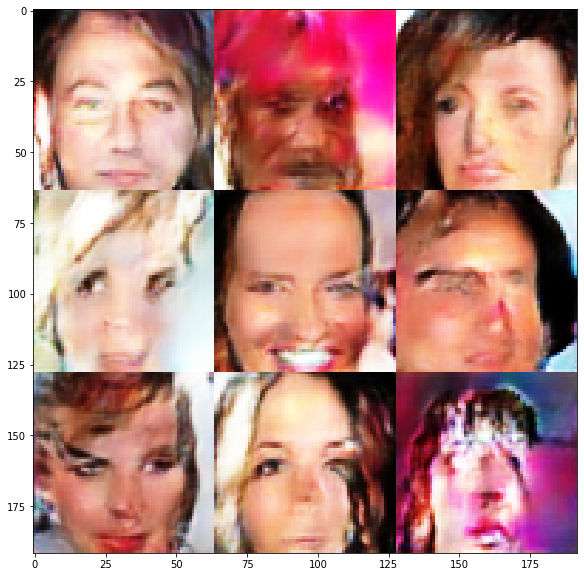

(9, 64, 64, 3) 0.99960345 -0.99966794
(9, 64, 64, 3) 254.94945 0.04233733


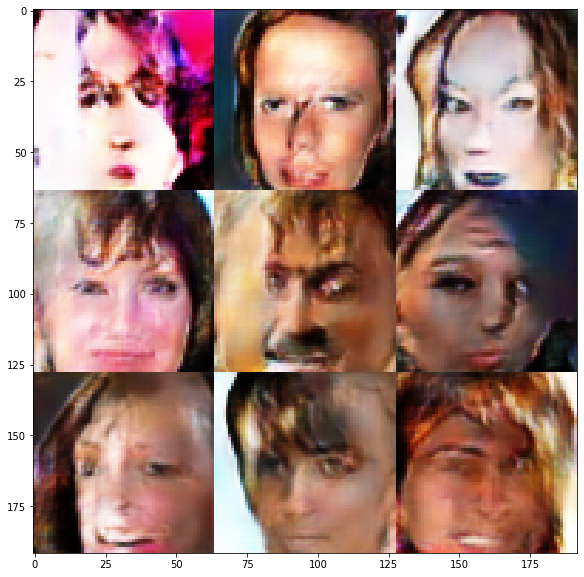

(9, 64, 64, 3) 0.9999266 -0.999972
(9, 64, 64, 3) 254.99063 0.0035718083


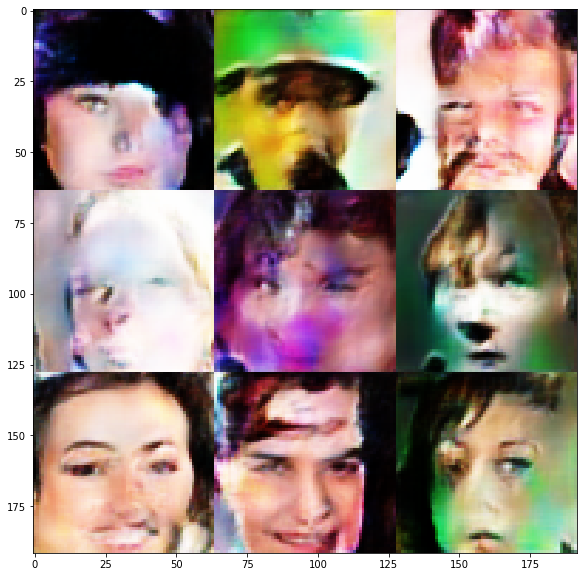

(9, 64, 64, 3) 0.9999025 -0.9998213
(9, 64, 64, 3) 254.98756 0.022783577


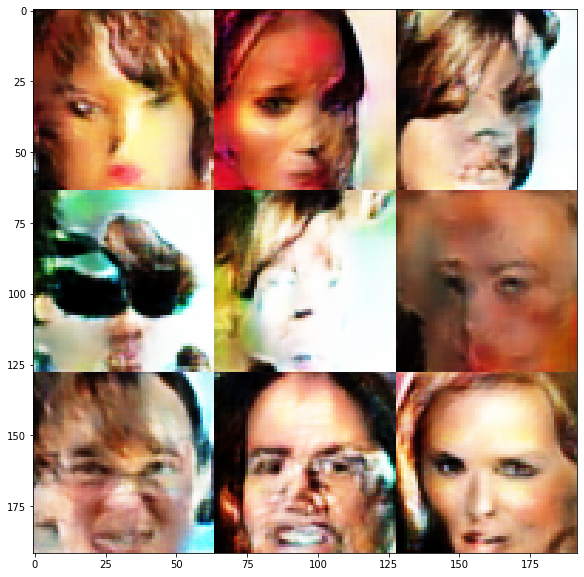

(9, 64, 64, 3) 0.99915457 -0.9990134
(9, 64, 64, 3) 254.89221 0.12578845


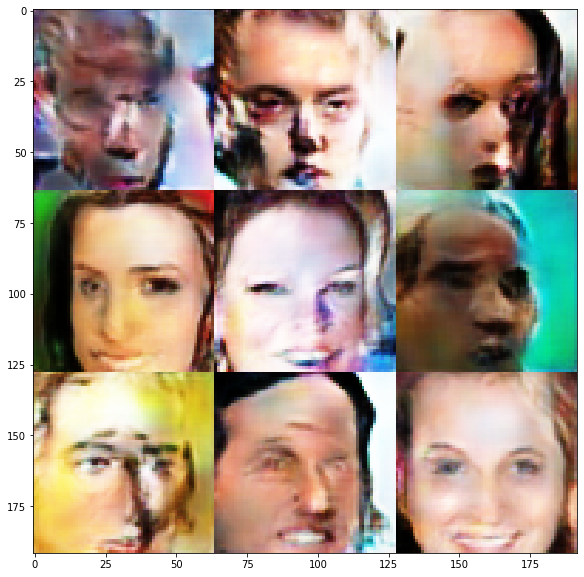

(9, 64, 64, 3) 0.99991995 -0.9999592
(9, 64, 64, 3) 254.98979 0.0052057207


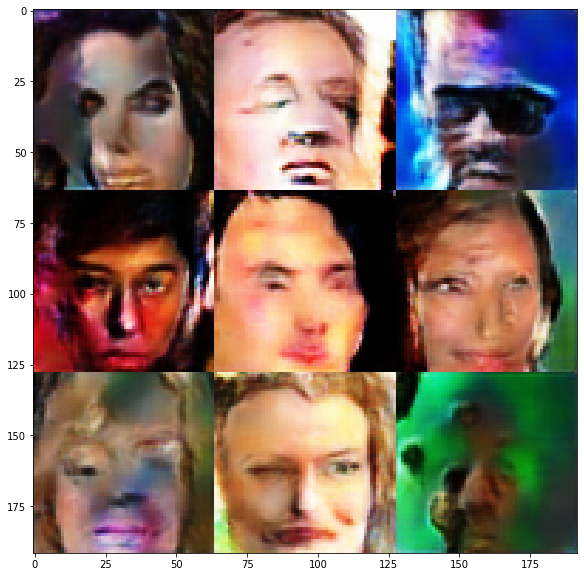

(9, 64, 64, 3) 0.9997795 -0.9999181
(9, 64, 64, 3) 254.97188 0.01044184


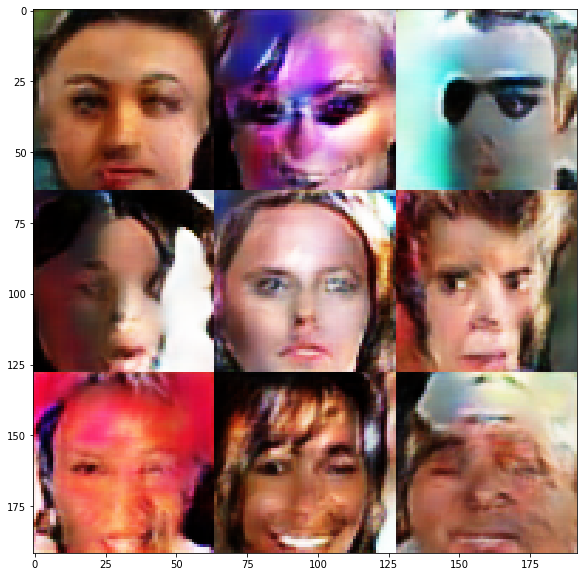

(9, 64, 64, 3) 0.99997336 -0.99999064
(9, 64, 64, 3) 254.9966 0.001193136


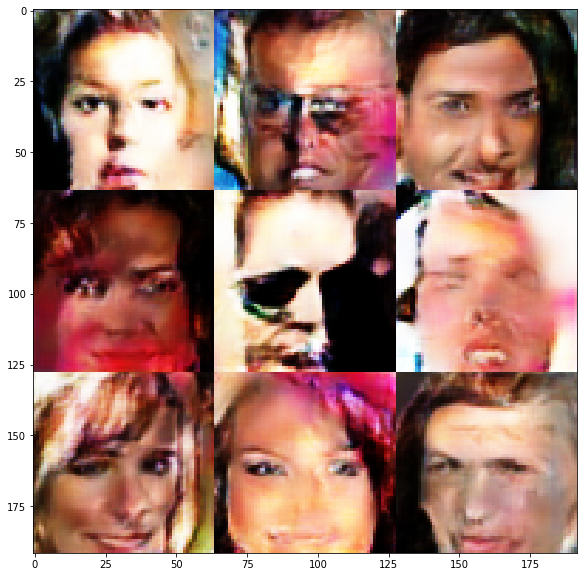

(9, 64, 64, 3) 0.99938864 -0.9997494
(9, 64, 64, 3) 254.92206 0.031948686


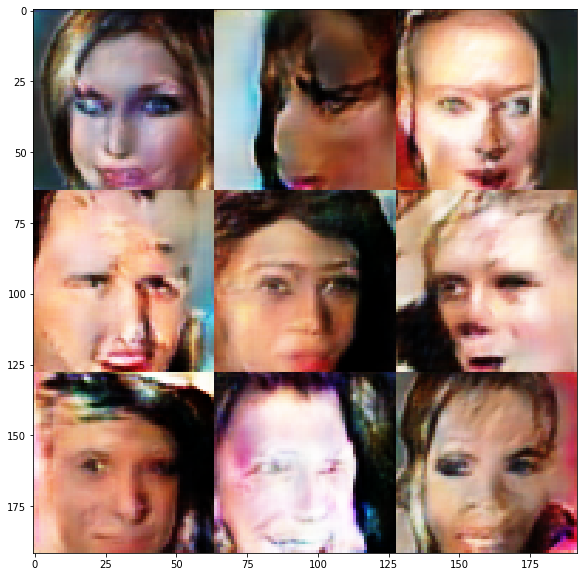

In [31]:
from keras.models import load_model
print('loading model...')
# gan.generator.save('dcgan/generator0019.h5')
# gan = load_model('dcgan/models/generator0025.h5')
gan = load_model('dcgan/generator0019.h5')
# gan = load_model('wgan/generator0003.h5')

# for i in range(20):
#     noise_vec = np.random.normal(-1, 1, (3*3, 100))
#     generated_images = dcgan.predict(noise_vec)
#     print(generated_images.shape, generated_images.max(), generated_images.min())
#     generated_images = (generated_images + 1) * 127.5
#     print(generated_images.shape, generated_images.max(), generated_images.min())
#     print(generated_images.shape) # should be (32, width, height, 3)
#     output_fig(generated_images, file_name="dcgan/output_images/{}_image".format(str.zfill(str(i), 3)))

for i in range(20):
    r, c = 3, 3
    noise = np.random.normal(0, 1, (r*c, 100))
    gen_imgs = gan.predict(noise)
    print(gen_imgs.shape, gen_imgs.max(), gen_imgs.min())

    # Rescale images 0 - 255
    gen_imgs = (gen_imgs + 1) * 127.5
    print(gen_imgs.shape, gen_imgs.max(), gen_imgs.min())

    plt.figure(figsize=(10, 10))
    fig = helper.images_square_grid(gen_imgs)
    plt.imshow(fig)
    plt.savefig("dcgan/output_images/{}_image".format(str.zfill(str(i), 3)))
    plt.show()
plt.close()